# Aphid-Ladybeetle study

In [1]:
import numpy as np  # linear algebra
from numba import jit

import arviz as az
from arviz.utils import Numba
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd
import pymc3 as pm  # for uncertainty quantification and model calibration
import theano  # to control better pymc3 backend and write a wrapper
import theano.tensor as t  # for the wrapper to a custom model to pymc3
import time
import warnings

np.seterr('warn')
warnings.filterwarnings("ignore")
az.style.use("arviz-darkgrid")

Numba.enable_numba()

seed = 1234
np.random.seed(seed)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Obtaining Initial Conditions

We need to define Initial Conditions as functions in order to define them for each discretization point. Here we will fit ICs as polynomial functions.

Loading data:

### 2018_Lin_and_Pennings

In [2]:
data_dir = "../data/2018 Lin and Pennings/appendix/"
aphid_data = pd.read_csv(data_dir + 'aphid.CSV')
ladybeetle_data = pd.read_csv(data_dir + 'ladybeetle.CSV')

In [3]:
aphid_data

Location  Time  Date  Location_code  Patch_ID  Density
0        NaN     1   NaN            NaN       NaN   2343.0
1        NaN     2   NaN            NaN       NaN   2611.0
2        NaN     3   NaN            NaN       NaN   2554.0
3        NaN     4   NaN            NaN       NaN   2297.0
4        NaN     5   NaN            NaN       NaN   3077.0
5        NaN     6   NaN            NaN       NaN   3080.0
6        NaN     7   NaN            NaN       NaN   2969.0
7        NaN     8   NaN            NaN       NaN   2558.0
8        NaN     9   NaN            NaN       NaN   2423.0
9        NaN    10   NaN            NaN       NaN   2802.0
10       NaN    11   NaN            NaN       NaN   2579.0
11       NaN    14   NaN            NaN       NaN   2038.0
12       NaN    15   NaN            NaN       NaN   1916.0
13       NaN    16   NaN            NaN       NaN   1788.0
14       NaN    17   NaN            NaN       NaN   1114.0
15       NaN    18   NaN            NaN       NaN    818.0
16       NaN    19   NaN            NaN       NaN    652.0
17       NaN    20   NaN            NaN       NaN    627.0
18       NaN    21   NaN            NaN       NaN    727.0
19       NaN    22   NaN            NaN       NaN    557.0
20       NaN    23   NaN            NaN       NaN    606.0
21       NaN    24   NaN            NaN       NaN    562.0
22       NaN    25   NaN            NaN       NaN    662.0
23       NaN    29   NaN            NaN       NaN    659.0
24       NaN    30   NaN            NaN       NaN    625.0
25       NaN    31   NaN            NaN       NaN    556.0
26       NaN    32   NaN            NaN       NaN    588.0
27       NaN    35   NaN            NaN       NaN    621.0
28       NaN    36   NaN            NaN       NaN    616.0
29       NaN    37   NaN            NaN       NaN    421.0
30       NaN    38   NaN            NaN       NaN    381.0
31       NaN    39   NaN            NaN       NaN    219.0
32       NaN    40   NaN            NaN       NaN    234.0
33       NaN    41   NaN            NaN       NaN    191.0

In [4]:
ladybeetle_data

Location  Time  Date  Location_code  Patch_ID  Density
0        NaN     1   NaN            NaN       NaN      7.0
1        NaN     2   NaN            NaN       NaN      8.0
2        NaN     3   NaN            NaN       NaN      7.0
3        NaN     4   NaN            NaN       NaN      5.0
4        NaN     5   NaN            NaN       NaN      4.0
5        NaN     6   NaN            NaN       NaN      3.0
6        NaN     7   NaN            NaN       NaN      2.0
7        NaN     8   NaN            NaN       NaN      3.0
8        NaN     9   NaN            NaN       NaN      4.0
9        NaN    10   NaN            NaN       NaN      3.0
10       NaN    11   NaN            NaN       NaN      1.0
11       NaN    14   NaN            NaN       NaN      9.0
12       NaN    15   NaN            NaN       NaN      7.0
13       NaN    16   NaN            NaN       NaN      7.0
14       NaN    17   NaN            NaN       NaN      7.0
15       NaN    18   NaN            NaN       NaN      6.0
16       NaN    19   NaN            NaN       NaN      6.0
17       NaN    20   NaN            NaN       NaN      3.0
18       NaN    21   NaN            NaN       NaN      2.0
19       NaN    22   NaN            NaN       NaN      3.0
20       NaN    23   NaN            NaN       NaN      4.0
21       NaN    24   NaN            NaN       NaN      2.0
22       NaN    25   NaN            NaN       NaN      1.0
23       NaN    29   NaN            NaN       NaN      7.0
24       NaN    30   NaN            NaN       NaN      5.0
25       NaN    31   NaN            NaN       NaN      2.0
26       NaN    32   NaN            NaN       NaN      1.0
27       NaN    35   NaN            NaN       NaN      5.0
28       NaN    36   NaN            NaN       NaN      6.0
29       NaN    37   NaN            NaN       NaN      4.0
30       NaN    38   NaN            NaN       NaN      3.0
31       NaN    39   NaN            NaN       NaN      2.0
32       NaN    40   NaN            NaN       NaN      2.0
33       NaN    41   NaN            NaN       NaN      0.0

Retrieving IC data:

In [5]:
aphid_ic = aphid_data[aphid_data.Time == 1].Density.values[0]
ladybeetle_ic = ladybeetle_data[ladybeetle_data.Time == 1].Density.values[0]

In [6]:
aphid_ic

2343.0

In [7]:
ladybeetle_ic

7.0

In [8]:
y0 = aphid_ic, ladybeetle_ic

y0

(2343.0, 7.0)

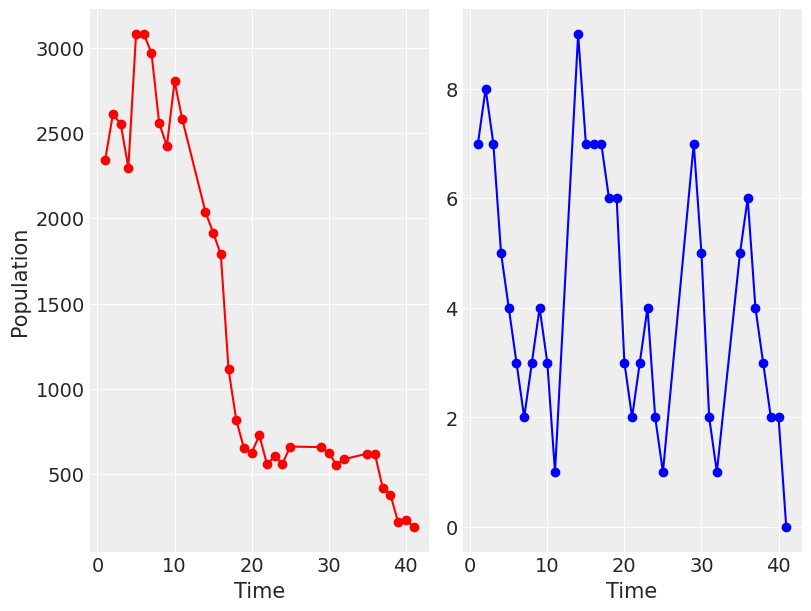

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

ax1.plot(aphid_data.Time.values, aphid_data.Density.values, '-o', c='r')
ax1.set(xlabel='Time', ylabel='Population')
ax2.plot(ladybeetle_data.Time.values, ladybeetle_data.Density.values, '-o', c='b')
ax2.set(xlabel='Time')
plt.show()

# Constant Prey Growth FR1 model

In [10]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def CP1_model(
    t,
    X,
    r1 = 1,
    a1 = 1,
):
    u, v = X
    u_prime = r1 - a1 * u * v 
    v_prime = 0
    return u_prime, v_prime

def CP1_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 1,
    a1 = 1,
):
    solution_ODE = solve_ivp(
        fun=CP1_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,a1),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [11]:
def CP1_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [12]:
from scipy import optimize

seed = 1234

r1=6.13939027780853
a1=0.04436839266096163
denom_min = 0.1
denom_max = 1.9
bounds_CP1 = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
]

result_CP1 = optimize.differential_evolution(
    CP1_least_squares_error_ode,
    bounds=bounds_CP1,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        CP1_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=20000, # 2000
    polish=True,
    disp=True,
    seed = seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_CP1)

differential_evolution step 1: f(x)= 5.16334e+06
parameters = [1.5271376 0.0052649]

differential_evolution step 2: f(x)= 5.16334e+06
parameters = [1.5271376 0.0052649]

differential_evolution step 3: f(x)= 5.11233e+06
parameters = [0.85154425 0.00541076]

differential_evolution step 4: f(x)= 5.11233e+06
parameters = [0.85154425 0.00541076]

differential_evolution step 5: f(x)= 5.11233e+06
parameters = [0.85154425 0.00541076]

differential_evolution step 6: f(x)= 5.11233e+06
parameters = [0.85154425 0.00541076]

differential_evolution step 7: f(x)= 5.11233e+06
parameters = [0.85154425 0.00541076]

differential_evolution step 8: f(x)= 5.10701e+06
parameters = [0.67120513 0.00564415]

differential_evolution step 9: f(x)= 5.10255e+06
parameters = [0.66898826 0.00557357]

differential_evolution step 10: f(x)= 5.10255e+06
parameters = [0.66898826 0.00557357]

differential_evolution step 11: f(x)= 5.10147e+06
parameters = [0.62786592 0.00551851]

differential_evolution step 12: f(x)= 5.10147

* Retrieving the calibrated parameter values:

In [13]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    a1_deterministic,
) = result_CP1.x

solution_ODE_CP1 = CP1_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_CP1.x
)
t_computed_CP1, y_computed_CP1 = solution_ODE_CP1.t, solution_ODE_CP1.y
u_CP1, v_CP1 = y_computed_CP1

parameters_dict = {
    "Model": "CP1",
    u"$r1$": r1_deterministic,
    u"$a1$": a1_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "a1=" + str(a1_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=0.6139422091654572
a1=0.005539962772780432


#### Simulation

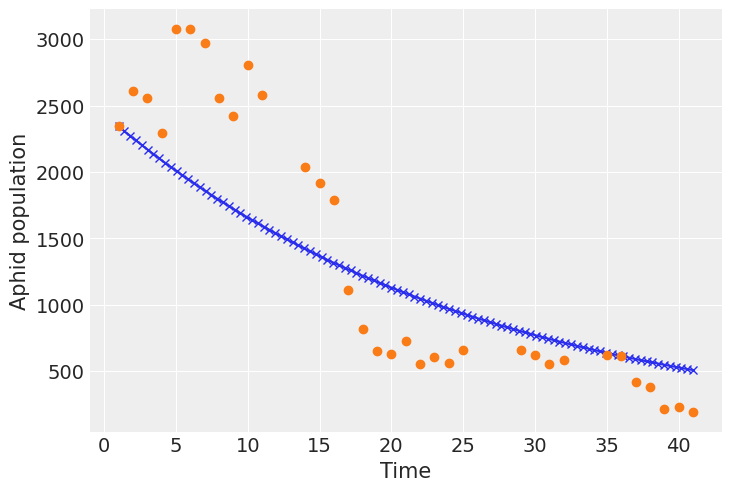

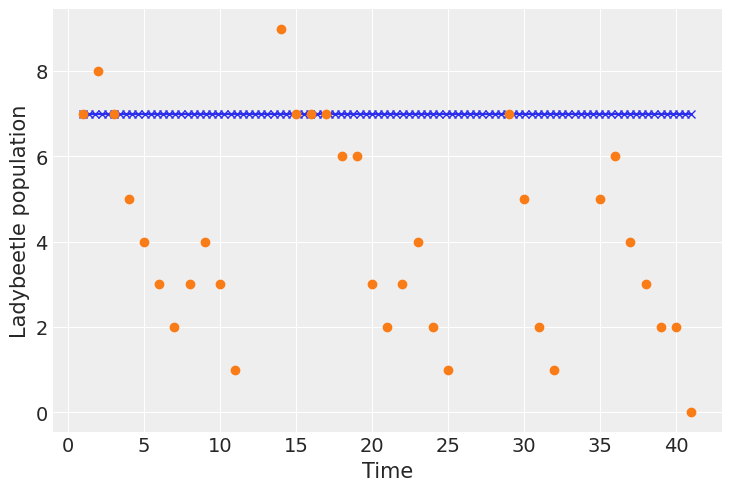

In [14]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_CP1, u_CP1, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_CP1, v_CP1, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [15]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    a1,
]
factors_names = [
    r"$r1$",
    r"$a1$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [16]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = CP1_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        CP1_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 12/12 [00:00<00:00, 273.13it/s]


In [17]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$a1$   0.959271
$r1$  0.0407287

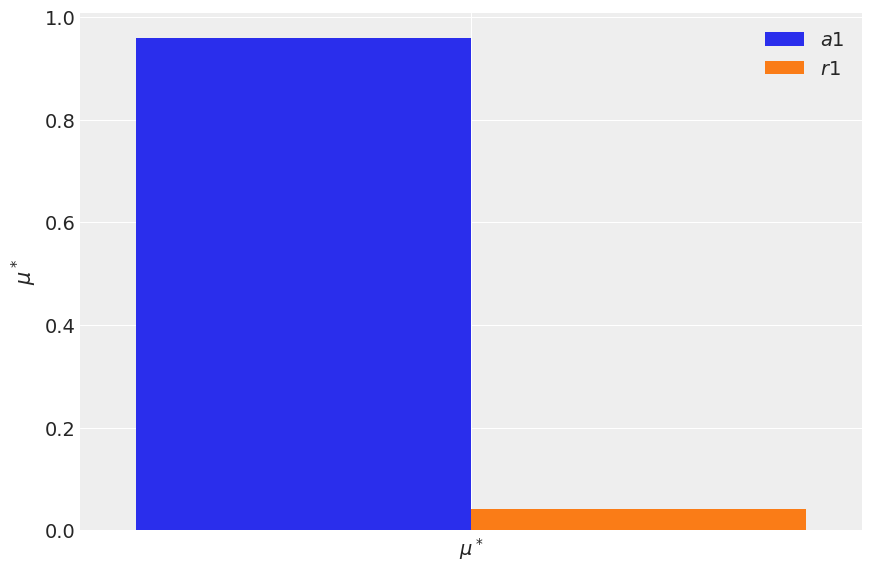

In [18]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares_CP1.png", dpi=300)
plt.show()

### Prey (pest) population

In [19]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    a1,
]
factors_names = [
    r"$r1$",
    r"$a1$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [20]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_CP1 = CP1_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_CP1.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 12/12 [00:00<00:00, 174.19it/s]


In [21]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 171.04it/s]


Time        $r1$      $a1$
0    1.404040  0.00885787  0.991142
1    1.808081  0.00935296  0.990647
2    2.212121  0.00991653  0.990083
3    2.616162   0.0105223  0.989478
4    3.020202    0.011235  0.988765
..        ...         ...       ...
94  39.383838    0.466405  0.533595
95  39.787879     0.46681   0.53319
96  40.191919    0.467179  0.532821
97  40.595960    0.467517  0.532483
98  41.000000    0.467827  0.532173

[99 rows x 3 columns]

In [22]:
df_sigmai

Time        $r1$      $a1$
0    1.404040  0.00477739  0.995223
1    1.808081  0.00460574  0.995394
2    2.212121  0.00486271  0.995137
3    2.616162  0.00458711  0.995413
4    3.020202  0.00461444  0.995386
..        ...         ...       ...
94  39.383838    0.116508  0.883492
95  39.787879    0.116868  0.883132
96  40.191919      0.1172    0.8828
97  40.595960    0.117506  0.882494
98  41.000000    0.117789  0.882211

[99 rows x 3 columns]

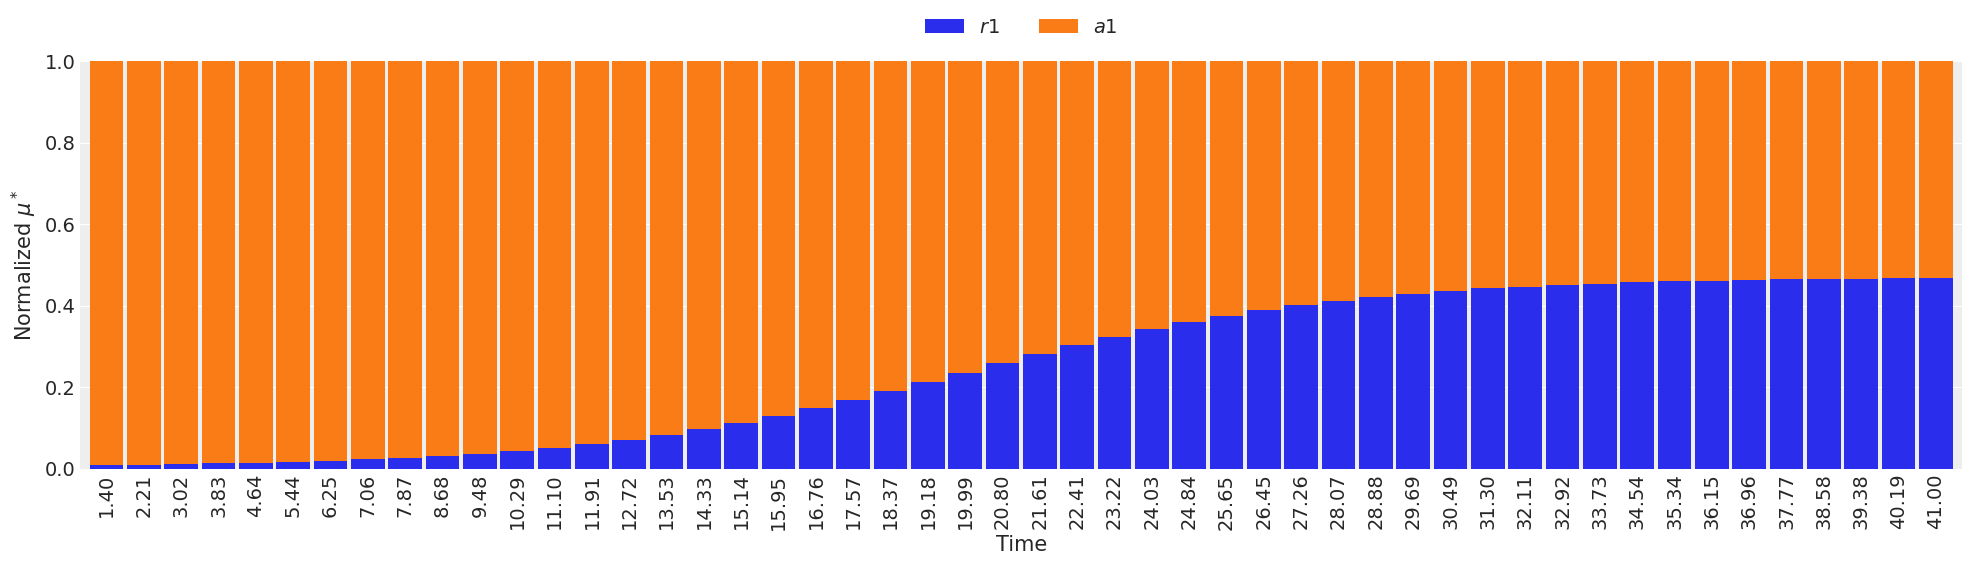

In [23]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_CP1.png", dpi=300)
plt.show()

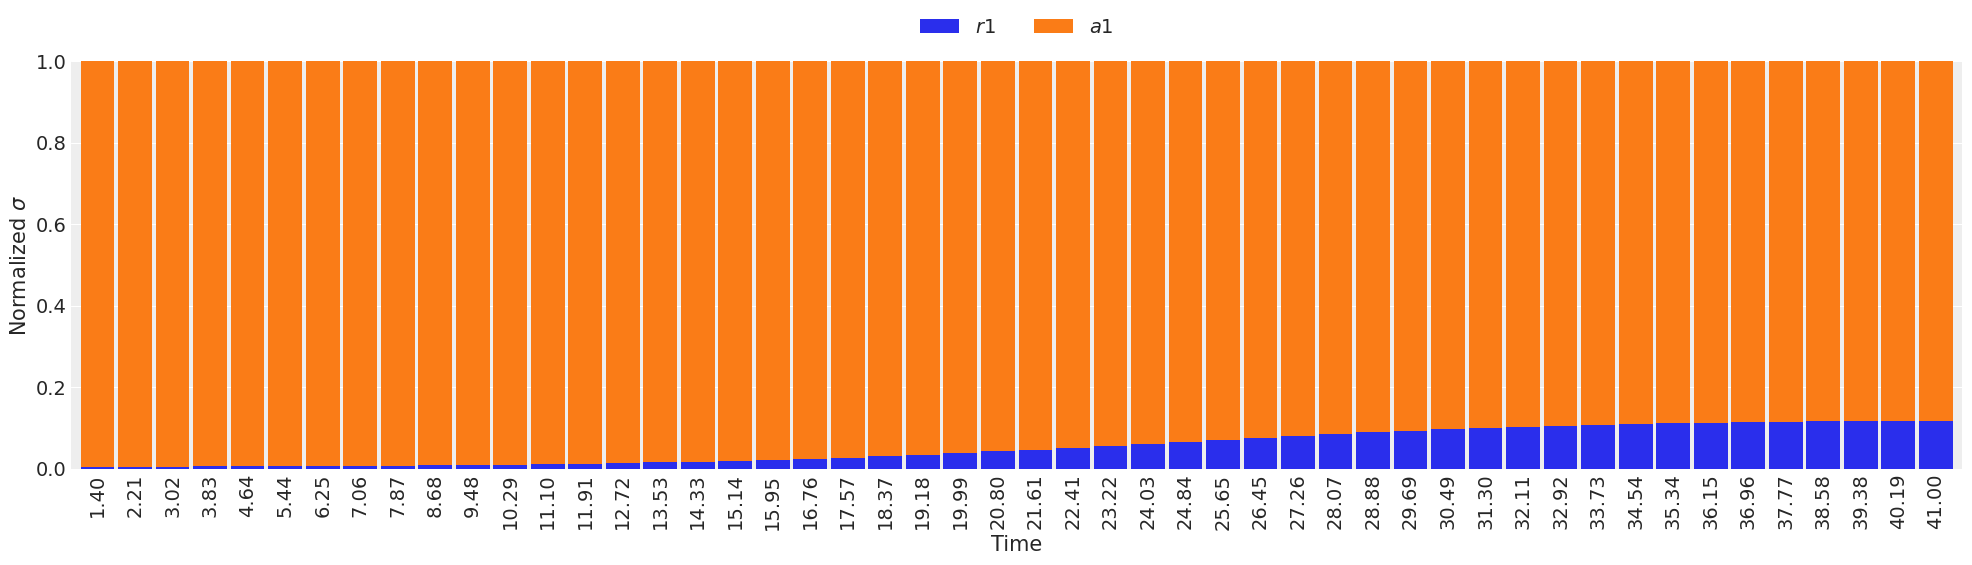

In [24]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_CP1.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [25]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [26]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_CP1,
    u_CP1,
    v_CP1,
    CP1_model,
    mean_values_params
)

pest_time_derivative_array

array([-721.54661775, -710.51827842, -699.74465639, -688.84812302,
       -678.11780073, -667.54409986, -657.12581214, -646.86293759,
       -636.75547619, -626.80342796, -617.00679288, -607.36557096,
       -597.87976221, -588.54936661, -579.37438418, -570.34491983,
       -561.44698486, -552.68047855, -544.0454009 , -535.54175192,
       -527.1695316 , -518.92873995, -510.81937696, -502.84144264,
       -494.99493698, -487.63819253, -479.94542401, -472.38169593,
       -464.94509797, -457.63371981, -450.44565115, -443.37898166,
       -436.43180104, -429.60219895, -422.8882651 , -416.28808915,
       -409.79926263, -403.41763387, -397.14074949, -390.96638402,
       -384.89231199, -378.91630795, -373.03614643, -367.24960196,
       -361.55444907, -355.94846231, -350.4294162 , -344.99508528,
       -339.64324408, -334.37166715, -329.178129  , -324.06040418,
       -319.01626723, -314.04349267, -309.14396247, -304.32118222,
       -299.57394902, -294.90104602, -290.3012564 , -285.77336

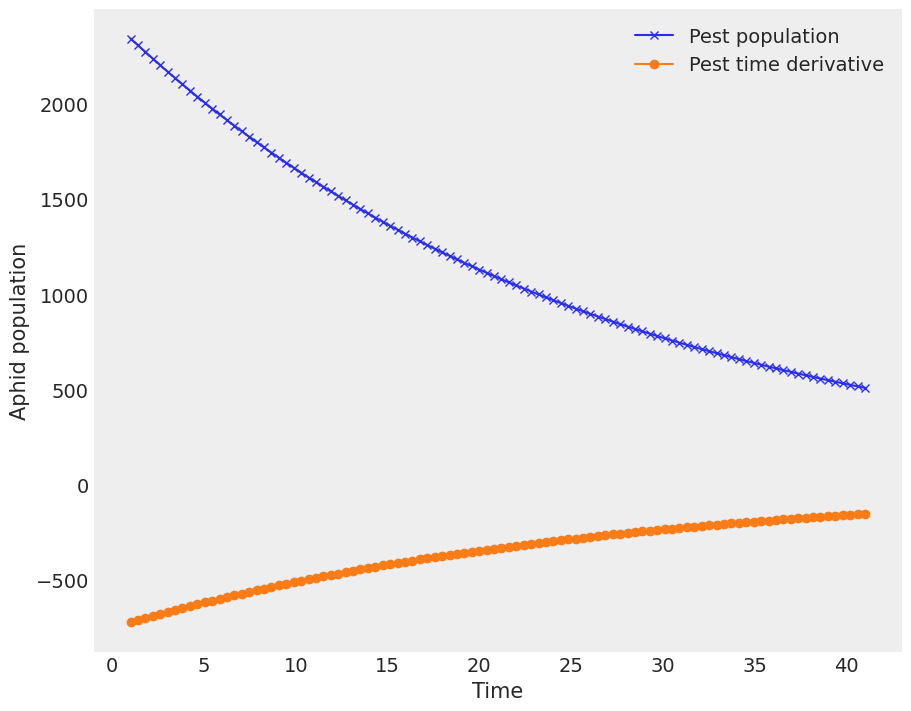

In [27]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_CP1, u_CP1, '-x', label='Pest population')
plt.plot(t_computed_CP1, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative_CP1.png", dpi=300)
plt.show()

In [28]:
mean_values_params = [
    r1,
    a1,
]
factors_names = [
    r"$r1$",
    r"$a1$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [29]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_CP1 = CP1_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_CP1.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        CP1_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 12/12 [00:00<00:00, 109.17it/s]


In [30]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 213.16it/s]


Time        $r1$      $a1$
0    1.404040  0.00939194  0.990608
1    1.808081   0.0108322  0.989168
2    2.212121   0.0129398   0.98706
3    2.616162   0.0163195   0.98368
4    3.020202   0.0224371  0.977563
..        ...         ...       ...
94  39.383838  0.00313765  0.996862
95  39.787879  0.00320214  0.996798
96  40.191919  0.00317641  0.996824
97  40.595960  0.00305231  0.996948
98  41.000000  0.00285018   0.99715

[99 rows x 3 columns]

In [31]:
df_sigmai

Time        $r1$      $a1$
0    1.404040  0.00430162  0.995698
1    1.808081  0.00447441  0.995526
2    2.212121  0.00461169  0.995388
3    2.616162   0.0049927  0.995007
4    3.020202   0.0053691  0.994631
..        ...         ...       ...
94  39.383838  0.00227015   0.99773
95  39.787879  0.00229461  0.997705
96  40.191919  0.00227701  0.997723
97  40.595960   0.0022143  0.997786
98  41.000000   0.0020627  0.997937

[99 rows x 3 columns]

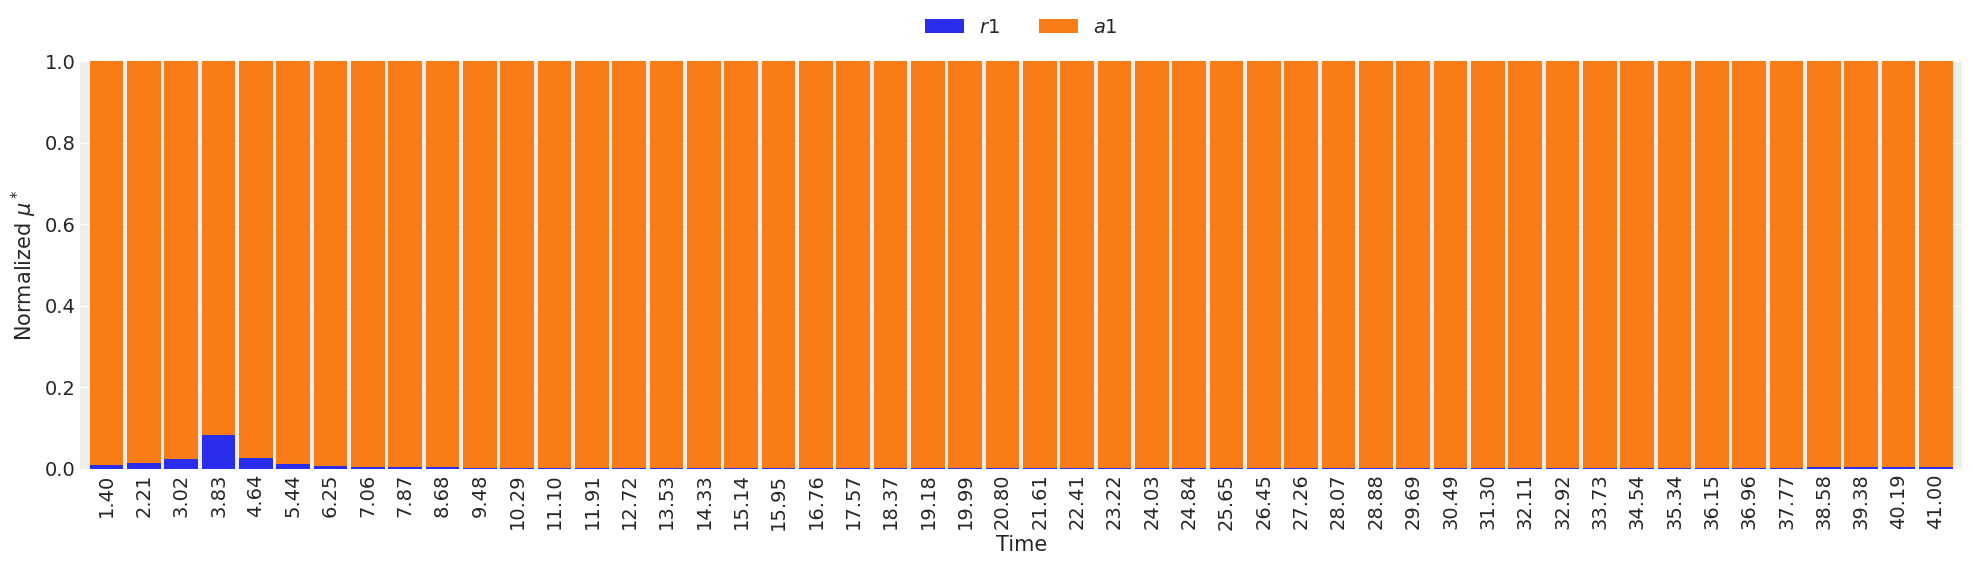

In [32]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_CP1.png", dpi=300)
plt.show()

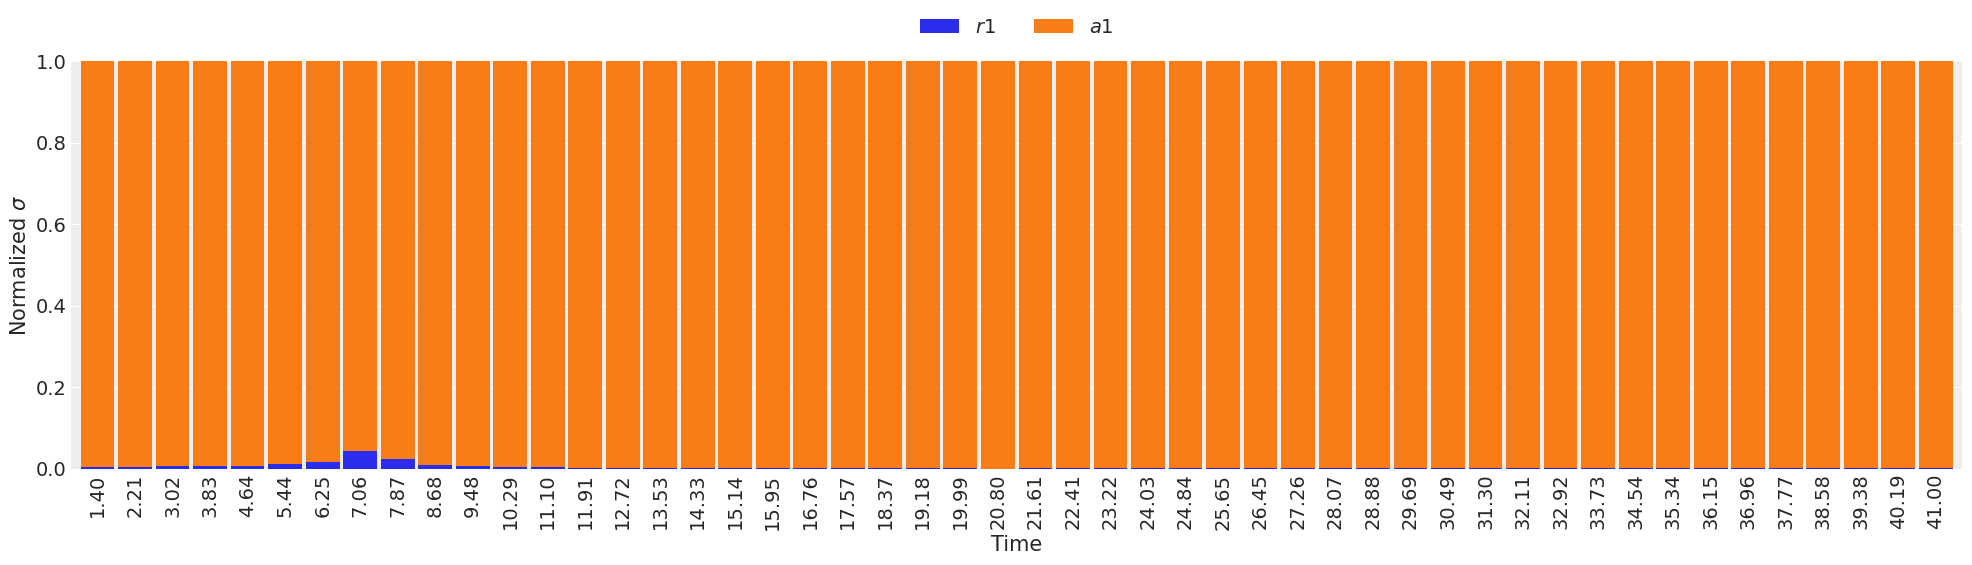

In [33]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_CP1.png", dpi=300)
plt.show()

## Bayesian calibration

In [34]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # a1
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def CP1_ode_wrapper(time_exp, r1, a1, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, a1]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        CP1_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [35]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_CP1:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "CP1_model",
        CP1_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "CP1_model",
        CP1_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "CP1_model",
        CP1_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_CP1:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_CP1 = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (4 chains in 4 jobs)
MLDA: [std_deviation, a1]


Sampling 4 chains for 1_000 tune and 4_500 draw iterations (4_000 + 18_000 draws total) took 304 seconds.
The number of effective samples is smaller than 25% for some parameters.


-- Monte Carlo simulations done in 5.612 minutes


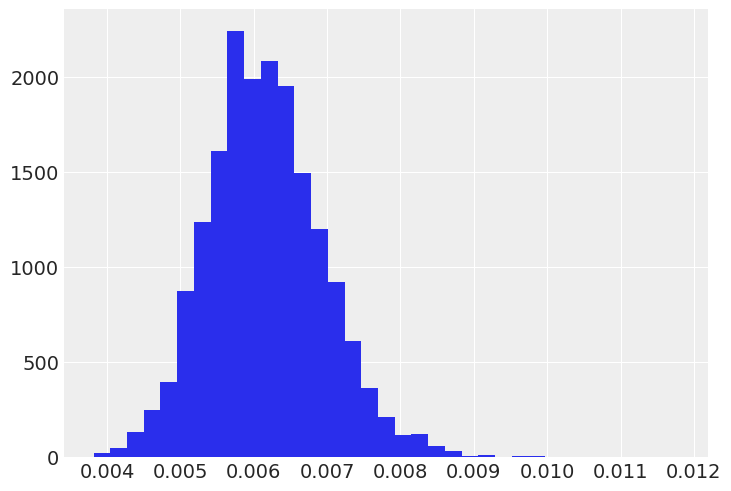

In [36]:
plt.hist(trace_calibration_CP1['a1'], bins=35)
plt.show()

In [37]:
calibration_variable_names = [
    "std_deviation",
    "a1",
]

100%|██████████| 2/2 [00:43<00:00, 21.97s/it]


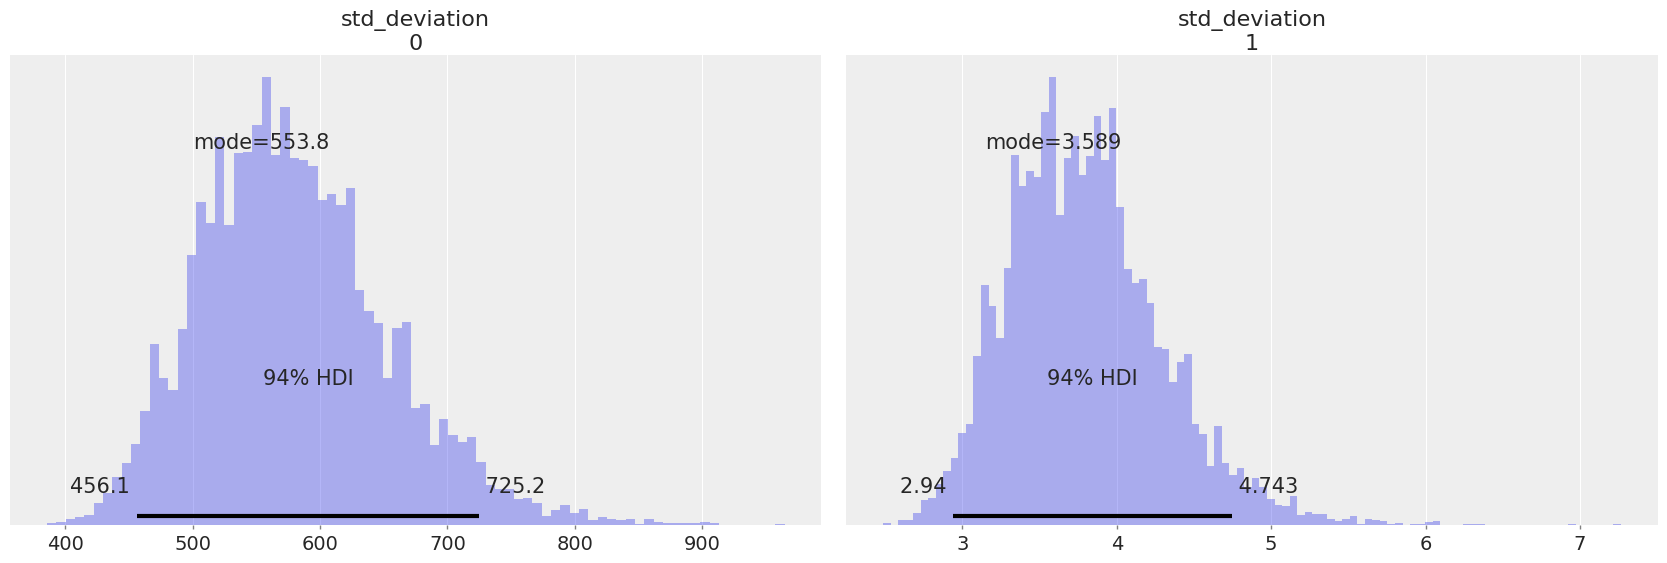

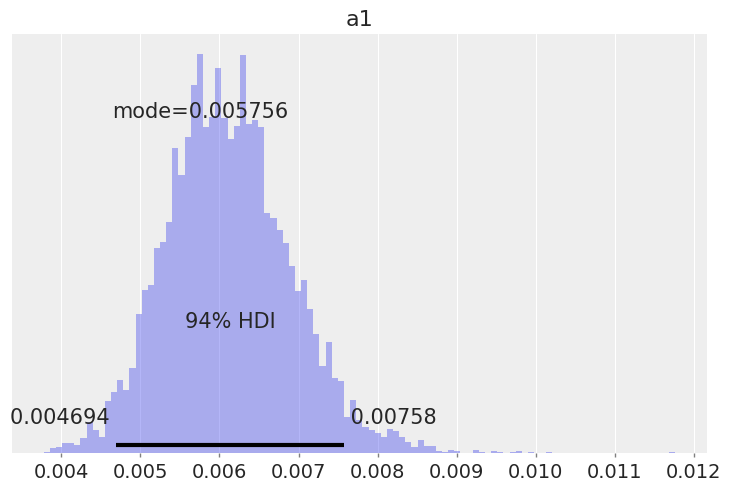

In [38]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_CP1[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal_CP1.png")

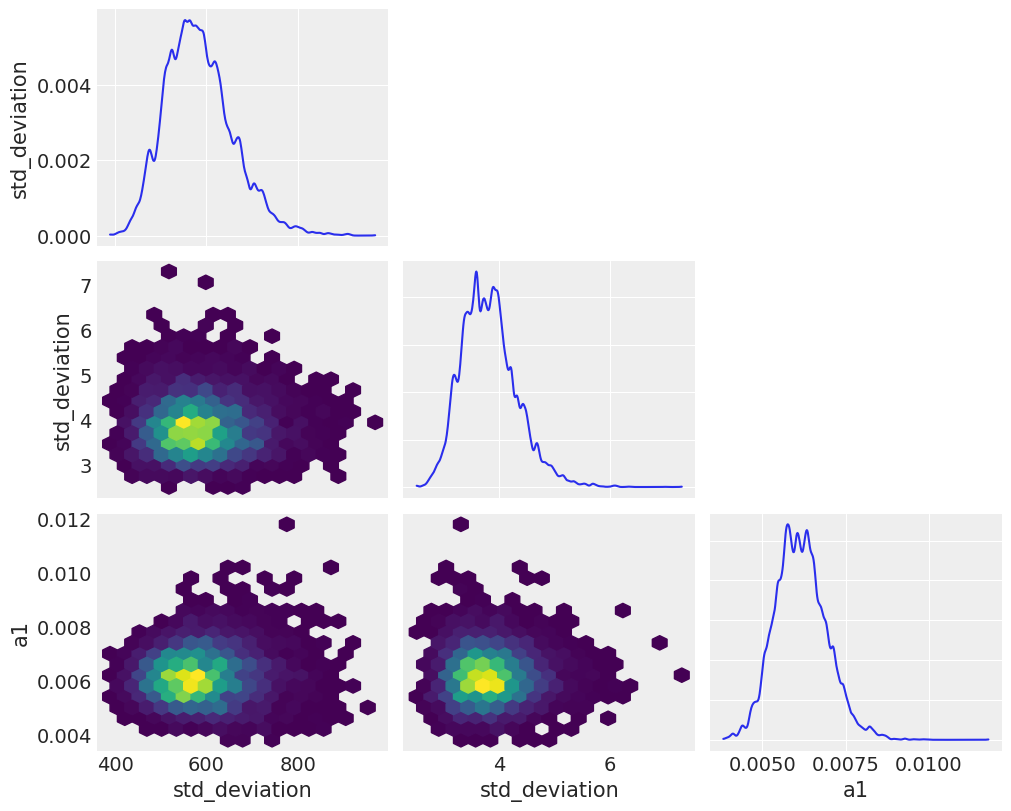

In [39]:
az.plot_pair(
    trace_calibration_CP1,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_CP1.png")

In [40]:
df_stats_summary = az.summary(
    data=trace_calibration_CP1,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

mean         sd      hdi_3%     hdi_97%
std_deviation[0]  583.818417  73.902557  456.132434  725.232999
std_deviation[1]    3.822590   0.496027    2.939993    4.743187
a1                  0.006158   0.000782    0.004694    0.007580

Auxiliary functions to compute the Most Probable Value (MPV):

In [41]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [42]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_CP1, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_CP1.csv")  # salvando em um csv para consultas

df_stats_summary

Calculating MPV from KDE for a1: 100%|██████████| 2/2 [00:18<00:00,  9.40s/it]           


mean         sd      hdi_3%     hdi_97%         mpv
std_deviation[0]  583.818417  73.902557  456.132434  725.232999  561.747662
std_deviation[1]    3.822590   0.496027    2.939993    4.743187    3.592667
a1                  0.006158   0.000782    0.004694    0.007580    0.005796

In [43]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_CP1["CP1_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_CP1["CP1_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_CP1["CP1_model"], 50, axis=0)

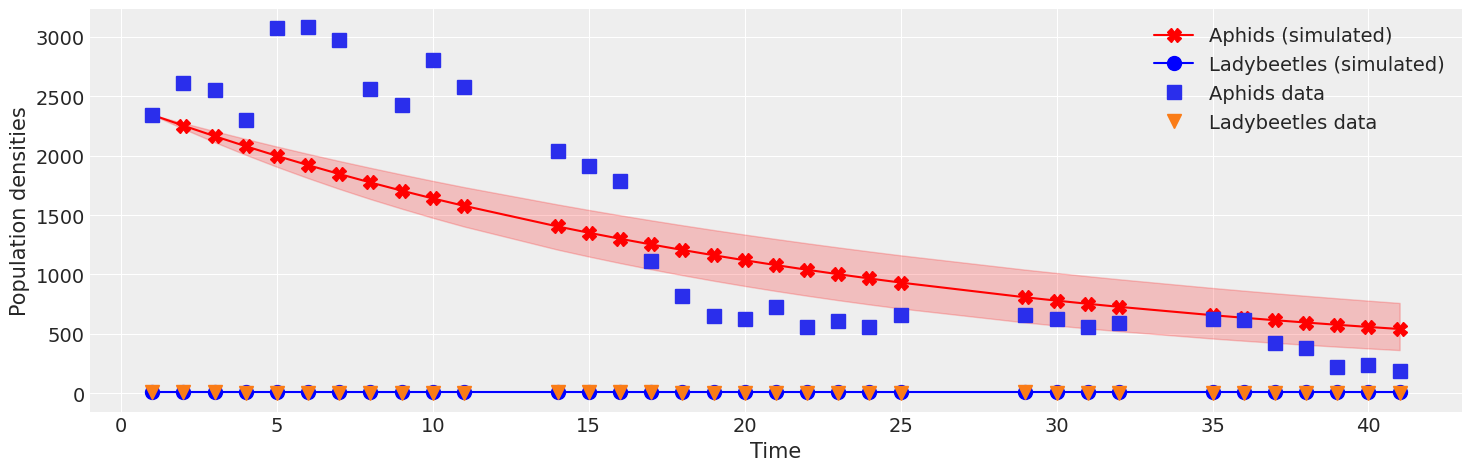

In [44]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration_CP1.png", dpi=300)
plt.show()

In [45]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_CP1.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_CP1.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering a1 realizations: 100%|██████████| 1/1 [00:00<00:00, 362.52it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.069 seconds


In [46]:
df_realizations

a1
0      0.005953
1      0.005953
2      0.007196
3      0.007196
4      0.007196
...         ...
17995  0.006895
17996  0.005588
17997  0.005260
17998  0.005260
17999  0.005260

[18000 rows x 1 columns]

# Constant Prey Growth FR2 model

## The parameter a1 doesn't have a maximum threshold

In [47]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def CP2_model(
    t,
    X,
    r1 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    u, v = X
    u_prime = r1 - a1 * u * v / ( a2 + a3 * u )
    v_prime = 0
    return u_prime, v_prime

def CP2_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    solution_ODE = solve_ivp(
        fun=CP2_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,a1,a2,a3),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [48]:
def CP2_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [49]:
from scipy import optimize

seed = 1234

r1=0.0010874832697555675
a1=0.5539521690253332
a2=3.795469755292592e-06
a3=0.06797623577085109
denom_min = 0.1
denom_max = 1.9
bounds_CP2 = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
    ( ( a2 * denom_min ), ( a2 * denom_max ) ),  # a2
    ( ( a3 * denom_min ), ( a3 * denom_max ) ),  # a3
]

result_CP2 = optimize.differential_evolution(
    CP2_least_squares_error_ode,
    bounds=bounds_CP2,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        CP2_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=20000, # 2000
    polish=True,
    disp=True,
    seed = seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_CP2)

differential_evolution step 1: f(x)= 4.19756e+06
parameters = [4.50377797e-04 8.09748966e-01 4.93069100e-06 9.92810008e-02]

differential_evolution step 2: f(x)= 4.19756e+06
parameters = [4.50377797e-04 8.09748966e-01 4.93069100e-06 9.92810008e-02]

differential_evolution step 3: f(x)= 4.19754e+06
parameters = [7.36672611e-04 6.72545954e-01 4.33626053e-06 8.25292383e-02]

differential_evolution step 4: f(x)= 4.19754e+06
parameters = [7.36672611e-04 6.72545954e-01 4.33626053e-06 8.25292383e-02]

differential_evolution step 5: f(x)= 4.19754e+06
parameters = [7.36672611e-04 6.72545954e-01 4.33626053e-06 8.25292383e-02]

differential_evolution step 6: f(x)= 4.19754e+06
parameters = [7.03612410e-04 7.88810070e-01 3.63149375e-06 9.68008125e-02]

differential_evolution step 7: f(x)= 4.19754e+06
parameters = [6.18760698e-04 6.91328339e-01 3.05207681e-06 8.48319517e-02]

differential_evolution step 8: f(x)= 4.19754e+06
parameters = [7.67771622e-04 8.48211932e-01 1.87266321e-06 1.04081325e-01]



* Retrieving the calibrated parameter values:

In [50]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    a1_deterministic,
    a2_deterministic,
    a3_deterministic,
) = result_CP2.x

solution_ODE_CP2 = CP2_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_CP2.x
)
t_computed_CP2, y_computed_CP2 = solution_ODE_CP2.t, solution_ODE_CP2.y
u_CP2, v_CP2 = y_computed_CP2

parameters_dict = {
    "Model": "CP2",
    u"$r1$": r1_deterministic,
    u"$a1$": a1_deterministic,
    u"$a2$": a2_deterministic,
    u"$a3$": a3_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "a1=" + str(a1_deterministic) + "\n" + "a2=" + str(a2_deterministic) + "\n" + "a3=" + str(a3_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=0.0009597955256356695
a1=1.042539833309234
a2=3.795469755292592e-07
a3=0.1279318352722325


#### Simulation

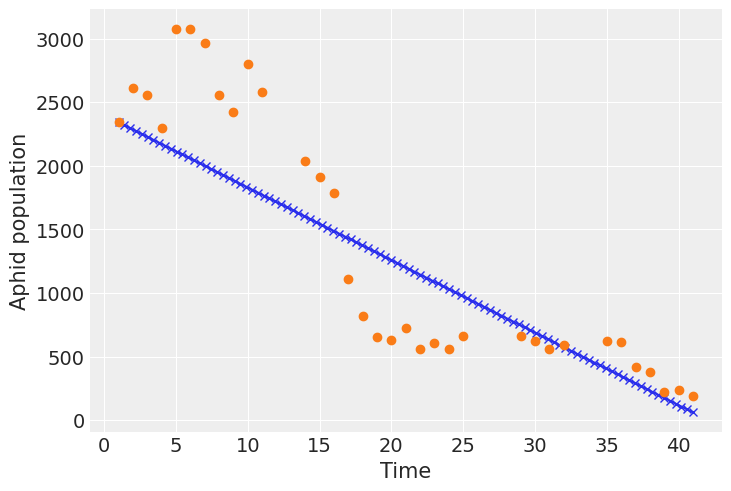

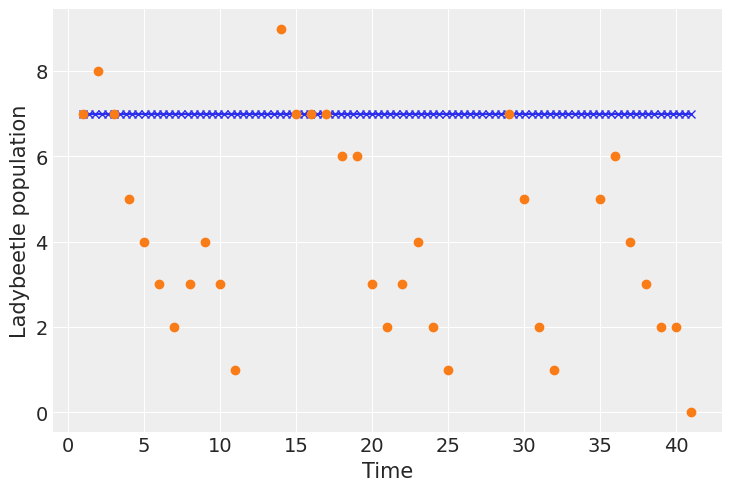

In [51]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_CP2, u_CP2, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_CP2, v_CP2, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [52]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [53]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = CP2_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        CP2_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 20/20 [00:00<00:00, 1156.51it/s]


In [54]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$a3$      0.63751
$a1$     0.362483
$r1$  6.64666e-06
$a2$  4.52741e-08

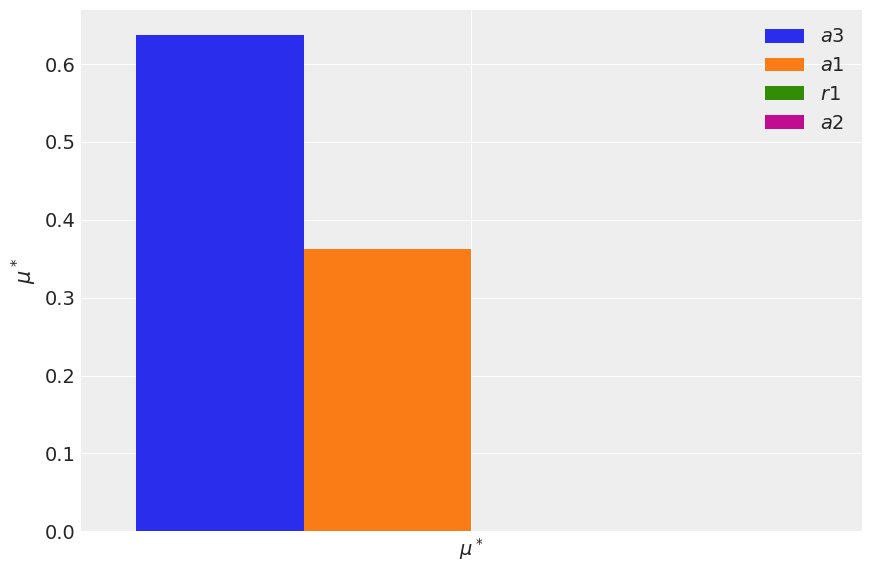

In [55]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares_CP2.png", dpi=300)
plt.show()

### Prey (pest) population

In [56]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [57]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_CP2 = CP2_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_CP2.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 20/20 [00:00<00:00, 1113.88it/s]


In [58]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 169.39it/s]


Time         $r1$      $a1$         $a2$      $a3$
0    1.404040  8.76021e-06  0.437908  1.60159e-08  0.562083
1    1.808081  8.76021e-06  0.437908  1.60577e-08  0.562083
2    2.212121  8.76021e-06  0.437908  1.61549e-08  0.562083
3    2.616162  8.76021e-06  0.437908  1.25639e-08  0.562083
4    3.020202  8.76021e-06  0.437908  1.41117e-08  0.562083
..        ...          ...       ...          ...       ...
94  39.383838   8.7602e-06  0.437908  1.19451e-07  0.562083
95  39.787879   8.7602e-06  0.437908  1.19513e-07  0.562083
96  40.191919   8.7602e-06  0.437908  1.19574e-07  0.562083
97  40.595960   8.7602e-06  0.437908  1.19634e-07  0.562083
98  41.000000   8.7602e-06  0.437908  1.19693e-07  0.562083

[99 rows x 5 columns]

In [59]:
df_sigmai

Time         $r1$      $a1$         $a2$      $a3$
0    1.404040  2.61251e-14  0.232614  2.86478e-08  0.767386
1    1.808081  1.84733e-14  0.232614  2.88559e-08  0.767386
2    2.212121  7.54168e-15  0.232614  2.91325e-08  0.767386
3    2.616162  4.22368e-13  0.232614  1.25483e-08  0.767386
4    3.020202  7.85868e-12  0.232614  5.49336e-08  0.767386
..        ...          ...       ...          ...       ...
94  39.383838  7.17442e-11  0.232613  5.04997e-07  0.767386
95  39.787879  7.17812e-11  0.232613  5.05258e-07  0.767386
96  40.191919  7.18175e-11  0.232613  5.05514e-07  0.767386
97  40.595960   7.1853e-11  0.232613  5.05764e-07  0.767386
98  41.000000  7.18878e-11  0.232613  5.06009e-07  0.767386

[99 rows x 5 columns]

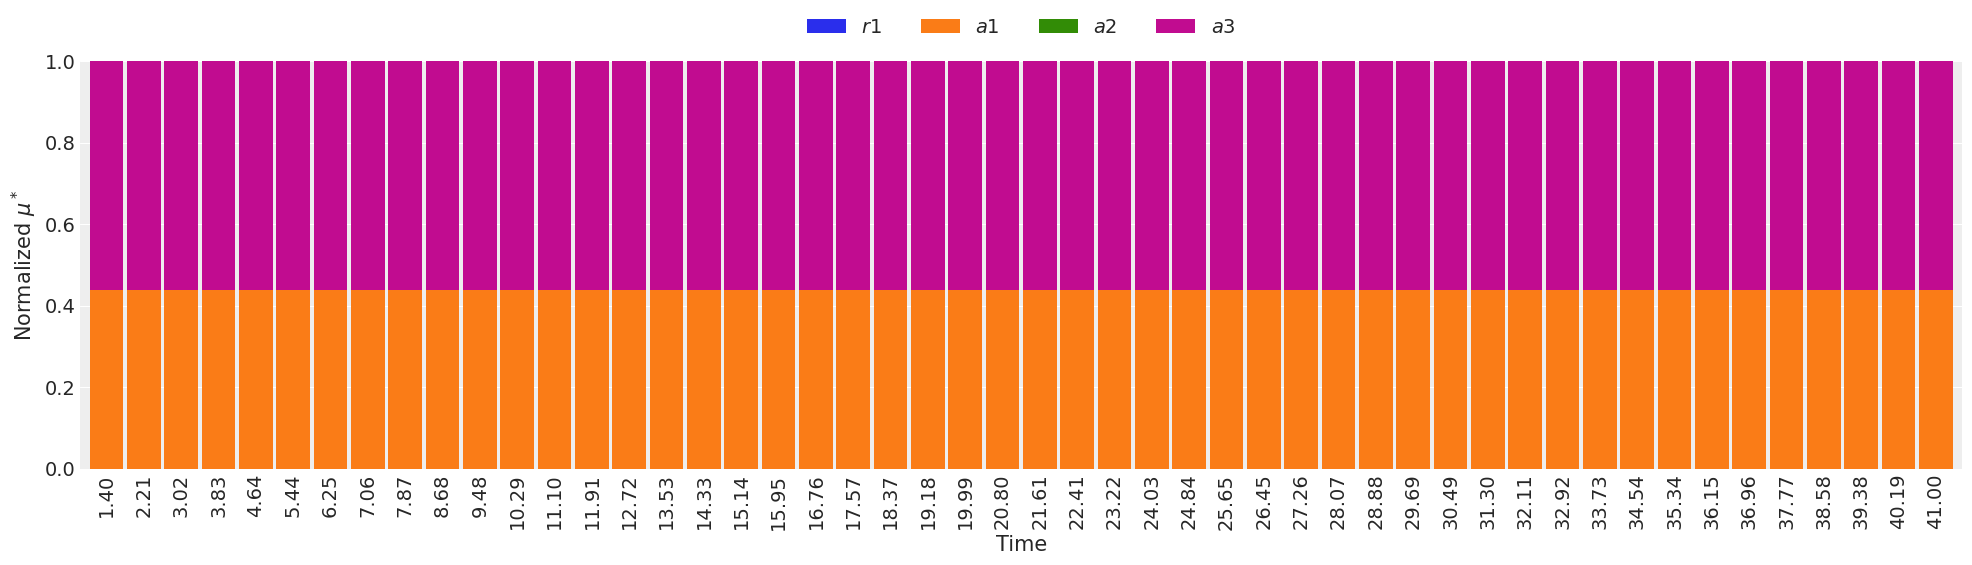

In [60]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_CP2.png", dpi=300)
plt.show()

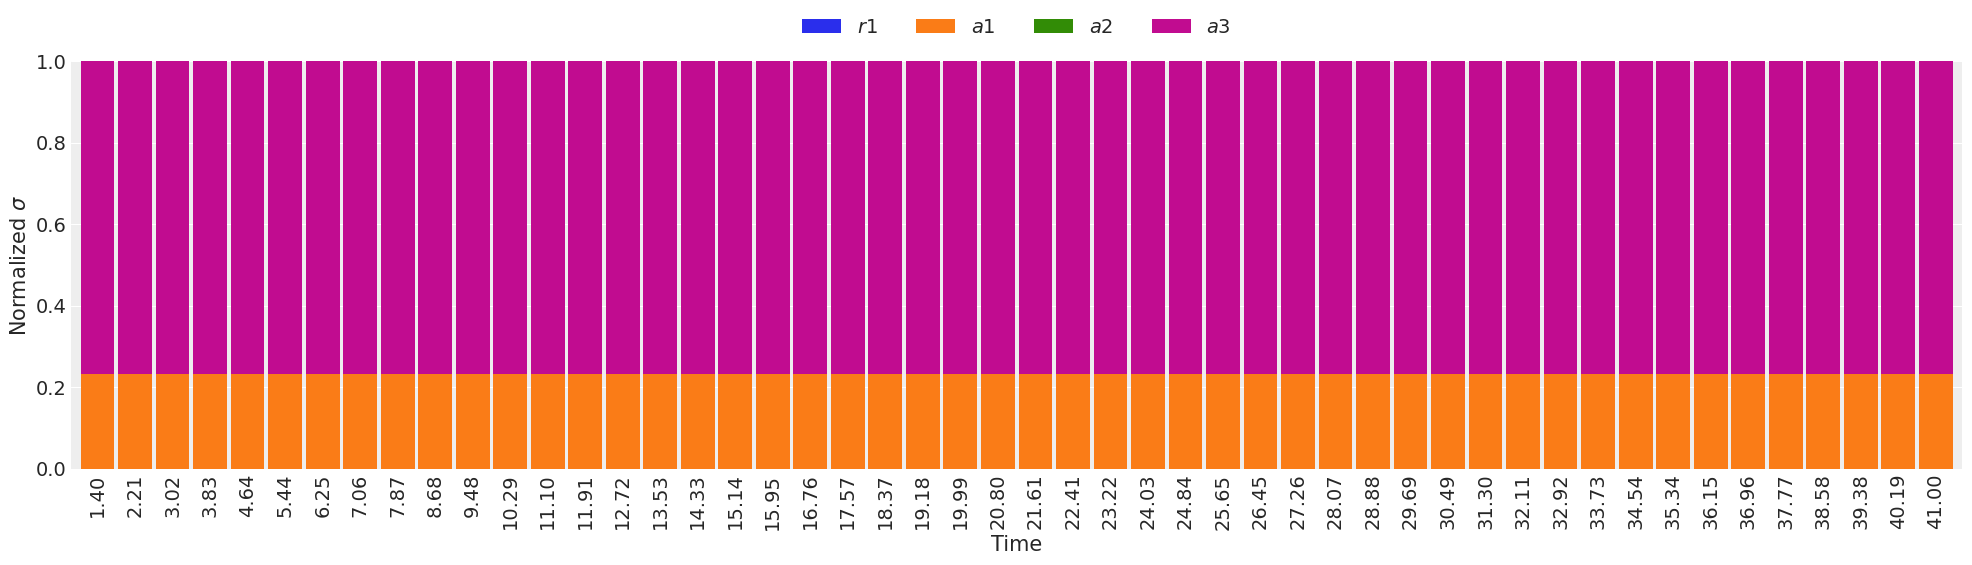

In [61]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_CP2.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [62]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [63]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_CP2,
    u_CP2,
    v_CP2,
    CP2_model,
    mean_values_params
)

pest_time_derivative_array

array([-57.04333469, -57.04333467, -57.04333466, -57.04333464,
       -57.04333463, -57.04333462, -57.0433346 , -57.04333459,
       -57.04333457, -57.04333455, -57.04333454, -57.04333452,
       -57.0433345 , -57.04333449, -57.04333447, -57.04333445,
       -57.04333443, -57.04333441, -57.04333439, -57.04333437,
       -57.04333435, -57.04333433, -57.04333431, -57.04333429,
       -57.04333427, -57.04333424, -57.04333422, -57.04333419,
       -57.04333417, -57.04333414, -57.04333412, -57.04333409,
       -57.04333406, -57.04333403, -57.043334  , -57.04333397,
       -57.04333394, -57.04333391, -57.04333387, -57.04333384,
       -57.0433338 , -57.04333377, -57.04333373, -57.04333369,
       -57.04333365, -57.04333361, -57.04333356, -57.04333352,
       -57.04333347, -57.04333342, -57.04333337, -57.04333332,
       -57.04333326, -57.0433332 , -57.04333315, -57.04333308,
       -57.04333302, -57.04333295, -57.04333288, -57.04333281,
       -57.04333273, -57.04333265, -57.04333256, -57.04

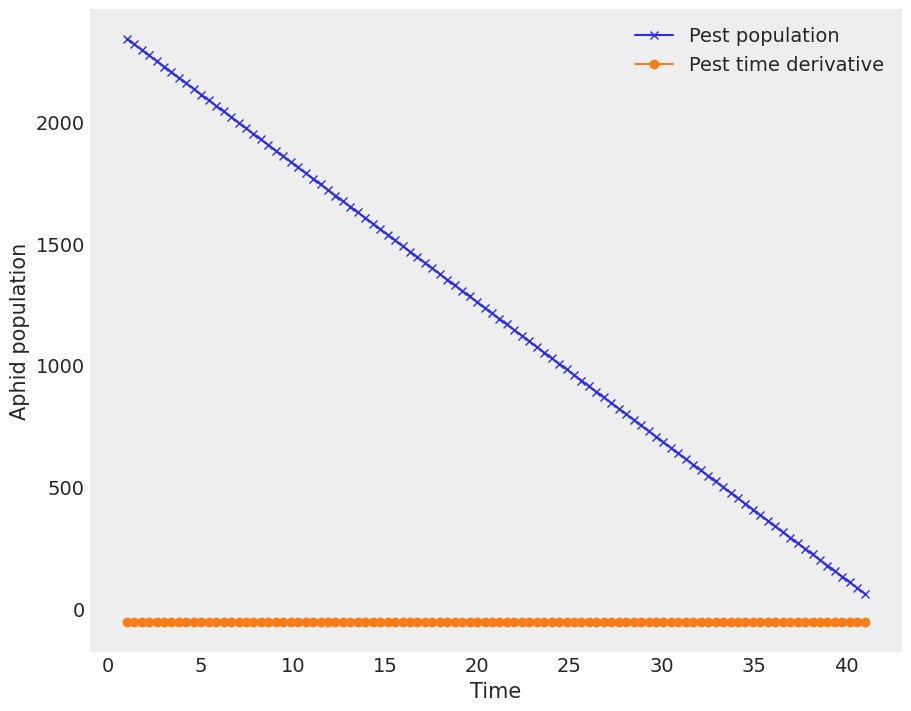

In [64]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_CP2, u_CP2, '-x', label='Pest population')
plt.plot(t_computed_CP2, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative_CP2.png", dpi=300)
plt.show()

In [65]:
mean_values_params = [
    r1,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [66]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_CP2 = CP2_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_CP2.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        CP2_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 20/20 [00:00<00:00, 388.57it/s]


In [67]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 161.49it/s]


Time         $r1$      $a1$         $a2$      $a3$
0    1.404040  8.76021e-06  0.437908  1.58339e-08  0.562083
1    1.808081  8.76021e-06  0.437908  1.60392e-08  0.562083
2    2.212121  8.76021e-06  0.437908  1.62507e-08  0.562083
3    2.616162  8.76021e-06  0.437908  1.64684e-08  0.562083
4    3.020202  8.76021e-06  0.437908  1.66928e-08  0.562083
..        ...          ...       ...          ...       ...
94  39.383838  8.76009e-06   0.43791  7.15385e-07  0.562081
95  39.787879  8.76016e-06  0.437906  7.04727e-07  0.562084
96  40.191919  8.76018e-06  0.437908  2.54646e-07  0.562083
97  40.595960  8.76019e-06  0.437908  1.64168e-07  0.562083
98  41.000000  8.76019e-06  0.437908  1.25444e-07  0.562083

[99 rows x 5 columns]

In [68]:
df_sigmai

Time         $r1$      $a1$         $a2$      $a3$
0    1.404040  7.07092e-15  0.232614  2.83476e-08  0.767386
1    1.808081  1.42116e-14  0.232614  2.89397e-08  0.767386
2    2.212121  2.21566e-14  0.232614  2.95544e-08  0.767386
3    2.616162  3.15179e-14  0.232614  3.01928e-08  0.767386
4    3.020202  4.05398e-14  0.232614  3.08563e-08  0.767386
..        ...          ...       ...          ...       ...
94  39.383838  5.47913e-10   0.23262  3.61172e-06  0.767376
95  39.787879  2.72497e-10  0.232607  3.56215e-06   0.76739
96  40.191919  1.62189e-10  0.232612  1.20158e-06  0.767387
97  40.595960  1.06967e-10  0.232613  7.29991e-07  0.767387
98  41.000000  7.52984e-11  0.232613  5.30044e-07  0.767386

[99 rows x 5 columns]

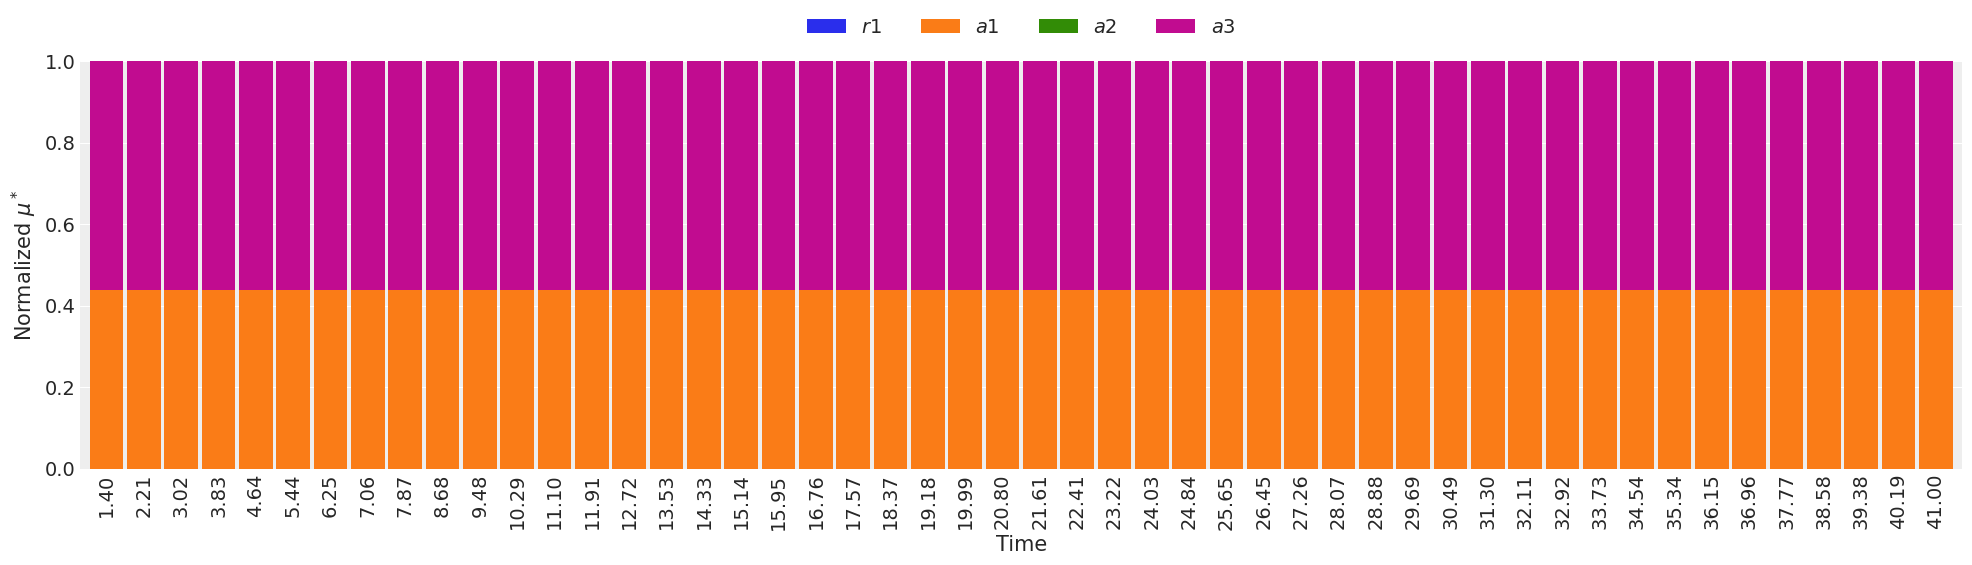

In [69]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_CP2.png", dpi=300)
plt.show()

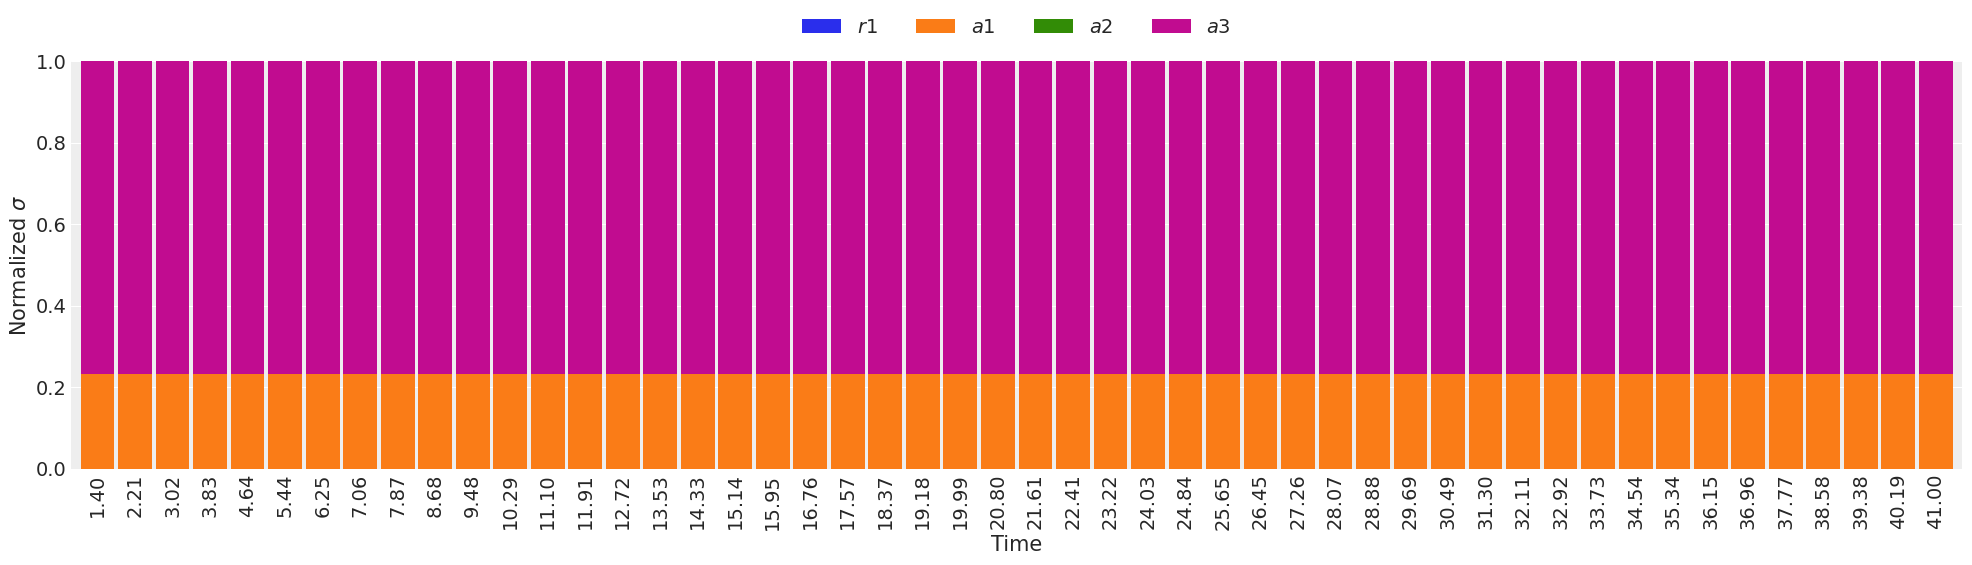

In [70]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_CP2.png", dpi=300)
plt.show()

## Bayesian calibration

In [71]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # a1
        t.dscalar,  # a2
        t.dscalar,  # a3
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def CP2_ode_wrapper(time_exp, r1, a1, a2, a3, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, a1, a2, a3]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        CP2_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [72]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_CP2:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + 100 * percent_calibration) * a1,
    )
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 +  100 * percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "CP2_model",
        CP2_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + 100 * percent_calibration) * a1,
    )
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 +  100 * percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "CP2_model",
        CP2_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + 100 * percent_calibration) * a1,
    )
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 +  100 * percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "CP2_model",
        CP2_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_CP2:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_CP2 = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (4 chains in 4 jobs)
MLDA: [std_deviation, a3, a1]


Sampling 4 chains for 1_000 tune and 4_500 draw iterations (4_000 + 18_000 draws total) took 183 seconds.
The number of effective samples is smaller than 10% for some parameters.


-- Monte Carlo simulations done in 3.332 minutes


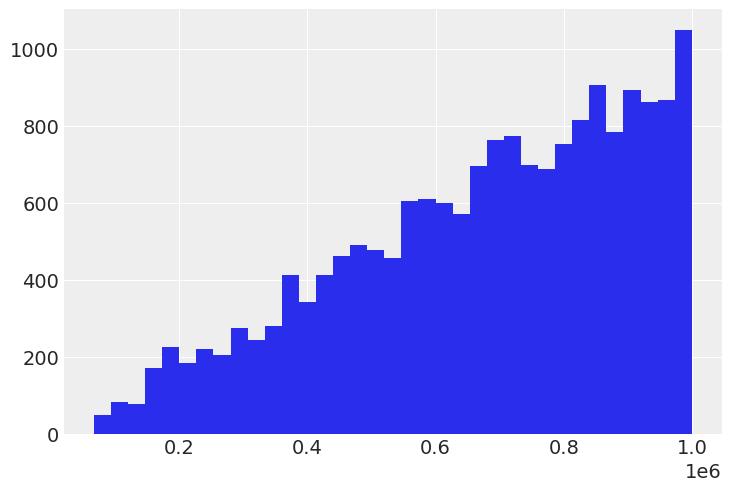

In [73]:
plt.hist(trace_calibration_CP2['a1'], bins=35)
plt.show()

In [74]:
calibration_variable_names = [
    "std_deviation",
    "a1",
    "a3",
]

100%|██████████| 3/3 [00:36<00:00, 12.04s/it]


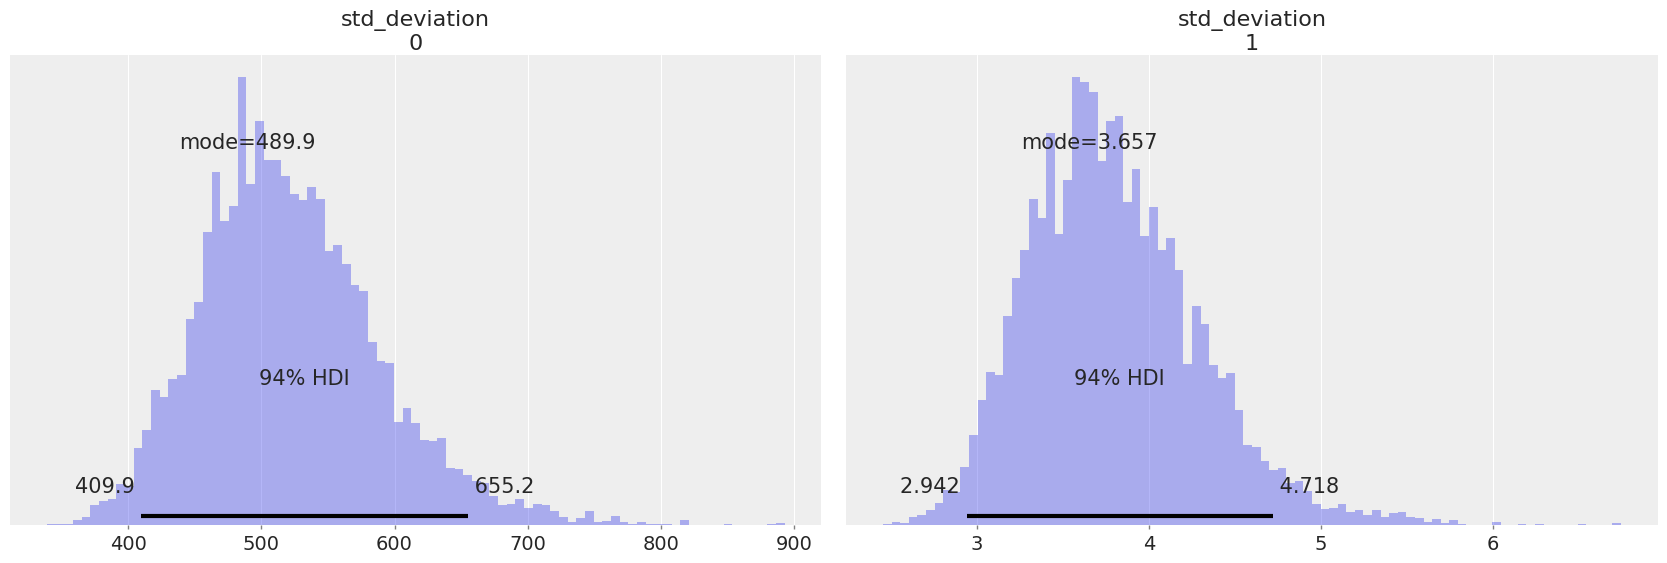

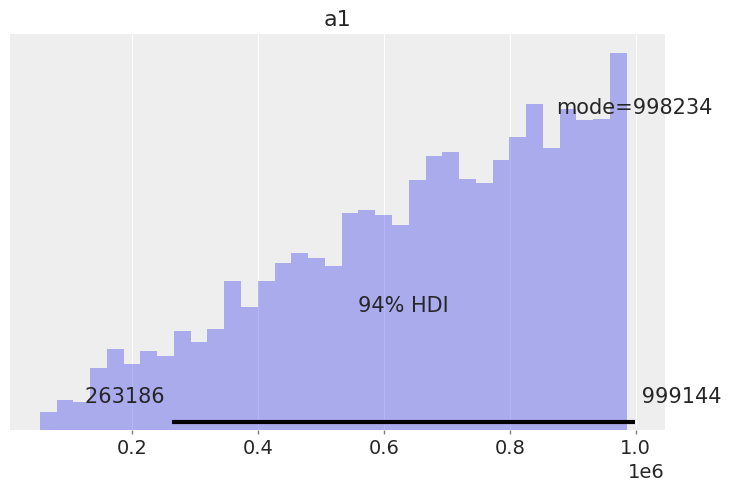

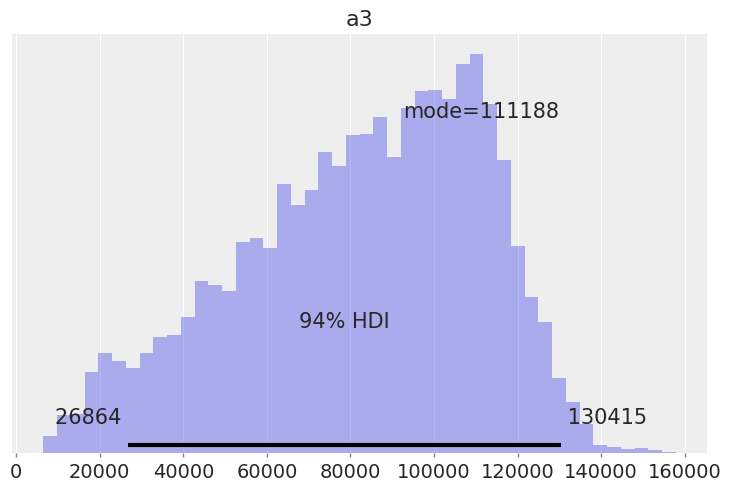

In [75]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_CP2[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal_CP2.png")

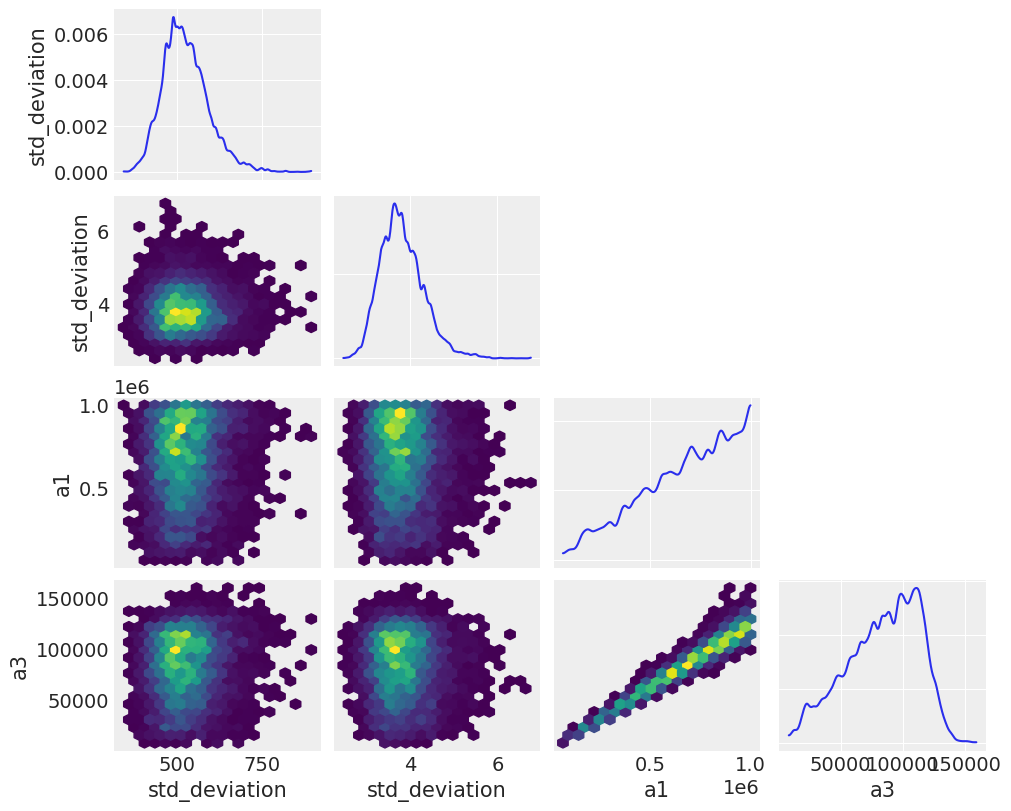

In [76]:
az.plot_pair(
    trace_calibration_CP2,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_CP2.png")

In [77]:
df_stats_summary = az.summary(
    data=trace_calibration_CP2,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

mean             sd         hdi_3%        hdi_97%
std_deviation[0]     525.192602      66.756255     409.918044     655.221028
std_deviation[1]       3.821592       0.493663       2.941778       4.718120
a1                674360.401805  227505.969557  263185.831259  999143.689447
a3                 83997.476976   28943.242828   26863.508259  130415.381119

Auxiliary functions to compute the Most Probable Value (MPV):

In [78]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [79]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_CP2, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_CP2.csv")  # salvando em um csv para consultas

df_stats_summary

Calculating MPV from KDE for a3: 100%|██████████| 3/3 [00:23<00:00,  7.96s/it]           


mean             sd         hdi_3%        hdi_97%  \
std_deviation[0]     525.192602      66.756255     409.918044     655.221028   
std_deviation[1]       3.821592       0.493663       2.941778       4.718120   
a1                674360.401805  227505.969557  263185.831259  999143.689447   
a3                 83997.476976   28943.242828   26863.508259  130415.381119   

                            mpv  
std_deviation[0]     496.857980  
std_deviation[1]       3.677243  
a1                928113.619644  
a3                109336.671405

In [80]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_CP2["CP2_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_CP2["CP2_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_CP2["CP2_model"], 50, axis=0)

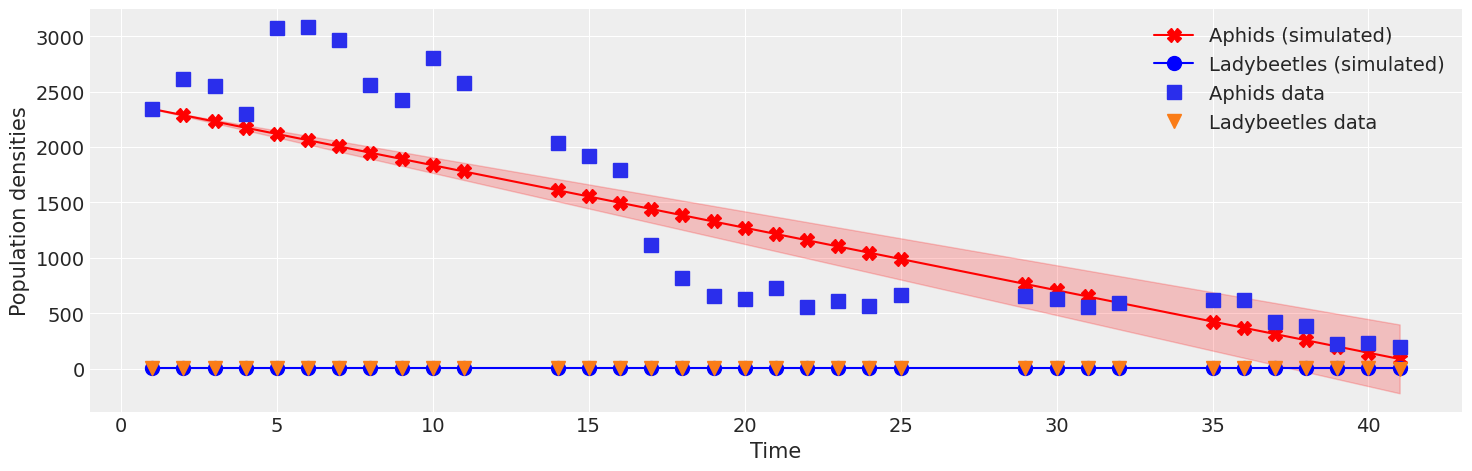

In [81]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration_CP2.png", dpi=300)
plt.show()

In [82]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_CP2.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_CP2.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering a3 realizations: 100%|██████████| 2/2 [00:00<00:00, 646.62it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.103 seconds


In [83]:
df_realizations

a1             a3
0      672858.488530   85842.741230
1      672858.488530   85842.741230
2      672858.488530   85842.741230
3      559610.734325   66174.788285
4      614932.578560   77071.172712
...              ...            ...
17995  942748.951950  126218.168415
17996  931692.821326  103660.731433
17997  935210.932128  103521.125193
17998  905746.503280  109618.588480
17999  888933.446114  106680.259250

[18000 rows x 2 columns]

# Constant Prey Growth FR3 model

## The parameter a1 doesn't have a maximum threshold

In [84]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def CP3_model(
    t,
    X,
    r1 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    u, v = X
    u_prime = r1 - a1 * u * u * v / ( a2 + a3 * u * u )
    v_prime = 0
    return u_prime, v_prime

def CP3_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    solution_ODE = solve_ivp(
        fun=CP3_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,a1,a2,a3),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [85]:
def CP3_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [86]:
from scipy import optimize

seed = 1234

r1=0.0012401581202450042
a1=0.5327293756383306
a2=2.4307154223146714e-05
a3=0.06537209705777657
denom_min = 0.1
denom_max = 1.9
bounds_CP3 = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
    ( ( a2 * denom_min ), ( a2 * denom_max ) ),  # a2
    ( ( a3 * denom_min ), ( a3 * denom_max ) ),  # a3
]

result_CP3 = optimize.differential_evolution(
    CP3_least_squares_error_ode,
    bounds=bounds_CP3,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        CP3_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=20000, # 2000
    polish=True,
    disp=True,
    seed = seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_CP3)

differential_evolution step 1: f(x)= 4.19756e+06
parameters = [5.13607609e-04 7.78726189e-01 3.15774000e-05 9.54775908e-02]

differential_evolution step 2: f(x)= 4.19756e+06
parameters = [5.13607609e-04 7.78726189e-01 3.15774000e-05 9.54775908e-02]

differential_evolution step 3: f(x)= 4.19754e+06
parameters = [8.40096161e-04 6.46779643e-01 2.77705160e-05 7.93675807e-02]

differential_evolution step 4: f(x)= 4.19754e+06
parameters = [8.40096161e-04 6.46779643e-01 2.77705160e-05 7.93675807e-02]

differential_evolution step 5: f(x)= 4.19754e+06
parameters = [8.40096161e-04 6.46779643e-01 2.77705160e-05 7.93675807e-02]

differential_evolution step 6: f(x)= 4.19754e+06
parameters = [8.40096161e-04 6.46779643e-01 2.77705160e-05 7.93675807e-02]

differential_evolution step 7: f(x)= 4.19754e+06
parameters = [8.40096161e-04 6.46779643e-01 2.77705160e-05 7.93675807e-02]

differential_evolution step 8: f(x)= 4.19754e+06
parameters = [5.08778478e-04 6.91819102e-01 2.78625082e-05 8.48954112e-02]



* Retrieving the calibrated parameter values:

In [87]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    a1_deterministic,
    a2_deterministic,
    a3_deterministic,
) = result_CP3.x

solution_ODE_CP3 = CP3_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_CP3.x
)
t_computed_CP3, y_computed_CP3 = solution_ODE_CP3.t, solution_ODE_CP3.y
u_CP3, v_CP3 = y_computed_CP3

parameters_dict = {
    "Model": "CP3",
    u"$r1$": r1_deterministic,
    u"$a1$": a1_deterministic,
    u"$a2$": a2_deterministic,
    u"$a3$": a3_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "a1=" + str(a1_deterministic) + "\n" + "a2=" + str(a2_deterministic) + "\n" + "a3=" + str(a3_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=0.0005087759251339442
a1=0.6918212271302048
a2=2.7862339483021317e-05
a3=0.08489489135848262


#### Simulation

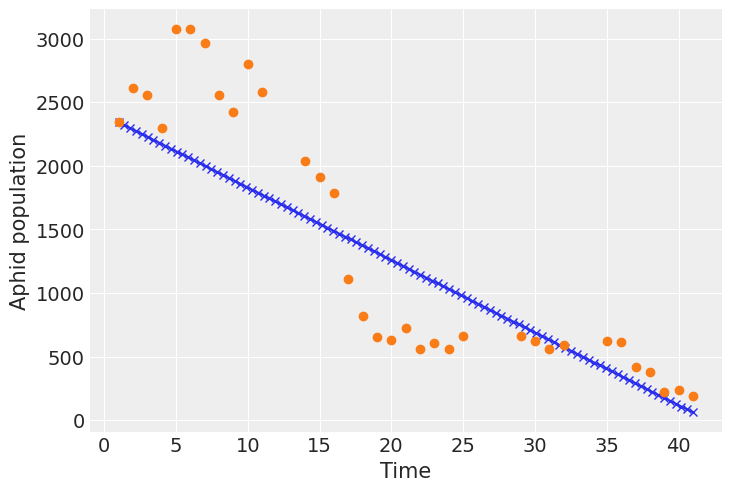

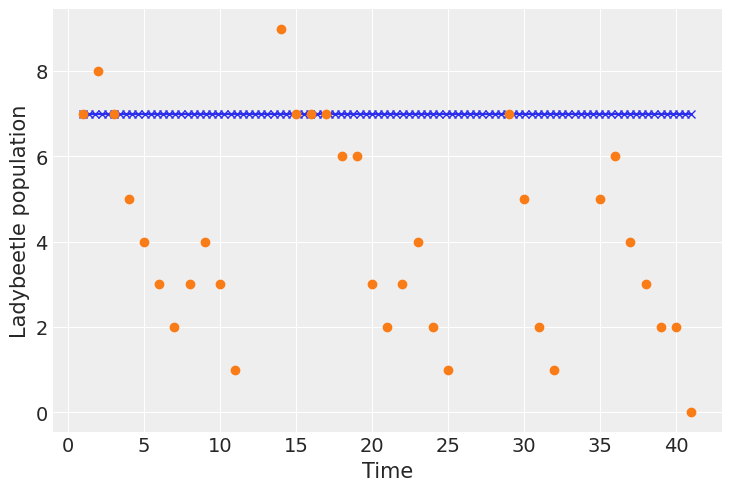

In [88]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_CP3, u_CP3, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_CP3, v_CP3, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [89]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [90]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = CP3_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        CP3_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 20/20 [00:00<00:00, 1047.27it/s]


In [91]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$a3$     0.637507
$a1$     0.362486
$r1$  7.57984e-06
$a2$  1.31044e-09

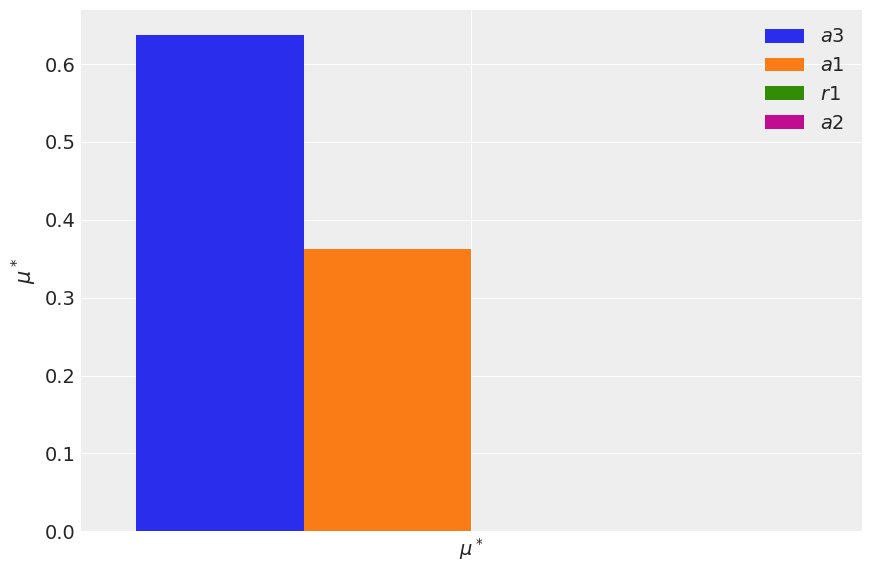

In [92]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares_CP3.png", dpi=300)
plt.show()

### Prey (pest) population

In [93]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [94]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_CP3 = CP3_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_CP3.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 20/20 [00:00<00:00, 1244.86it/s]


In [95]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 168.46it/s]


Time         $r1$      $a1$         $a2$      $a3$
0    1.404040  9.99009e-06  0.437908  4.66358e-11  0.562082
1    1.808081  9.99009e-06  0.437908  4.68813e-11  0.562082
2    2.212121  9.99009e-06  0.437908   4.7457e-11  0.562082
3    2.616162  9.99009e-06  0.437908  5.28061e-11  0.562082
4    3.020202  9.99009e-06  0.437908  9.63921e-10  0.562082
..        ...          ...       ...          ...       ...
94  39.383838  9.99009e-06  0.437908  7.41948e-09  0.562082
95  39.787879  9.99009e-06  0.437908  7.42322e-09  0.562082
96  40.191919  9.99009e-06  0.437908  7.42688e-09  0.562082
97  40.595960  9.99009e-06  0.437908  7.43046e-09  0.562082
98  41.000000  9.99009e-06  0.437908  7.43398e-09  0.562082

[99 rows x 5 columns]

In [96]:
df_sigmai

Time         $r1$      $a1$         $a2$      $a3$
0    1.404040  2.26251e-14  0.232614  8.39986e-11  0.767386
1    1.808081  1.13125e-14  0.232614  8.52236e-11  0.767386
2    2.212121   8.7084e-15  0.232614  8.68638e-11  0.767386
3    2.616162            0  0.232614  1.12594e-10  0.767386
4    3.020202  9.21401e-13  0.232614   4.7401e-09  0.767386
..        ...          ...       ...          ...       ...
94  39.383838  7.38956e-12  0.232614  3.74139e-08  0.767386
95  39.787879  7.39332e-12  0.232614  3.74328e-08  0.767386
96  40.191919  7.39699e-12  0.232614  3.74513e-08  0.767386
97  40.595960  7.40056e-12  0.232614  3.74694e-08  0.767386
98  41.000000  7.40408e-12  0.232614  3.74872e-08  0.767386

[99 rows x 5 columns]

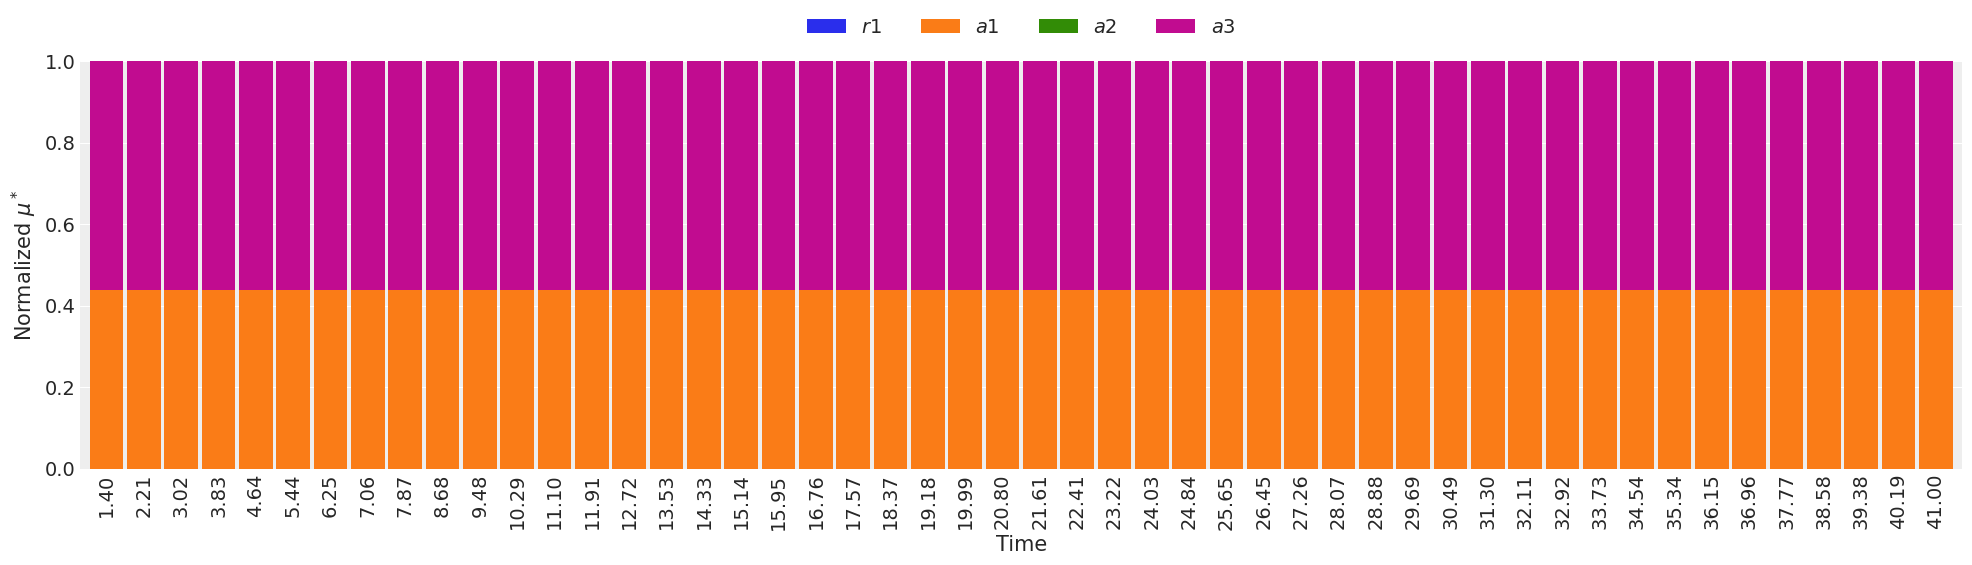

In [97]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_CP3.png", dpi=300)
plt.show()

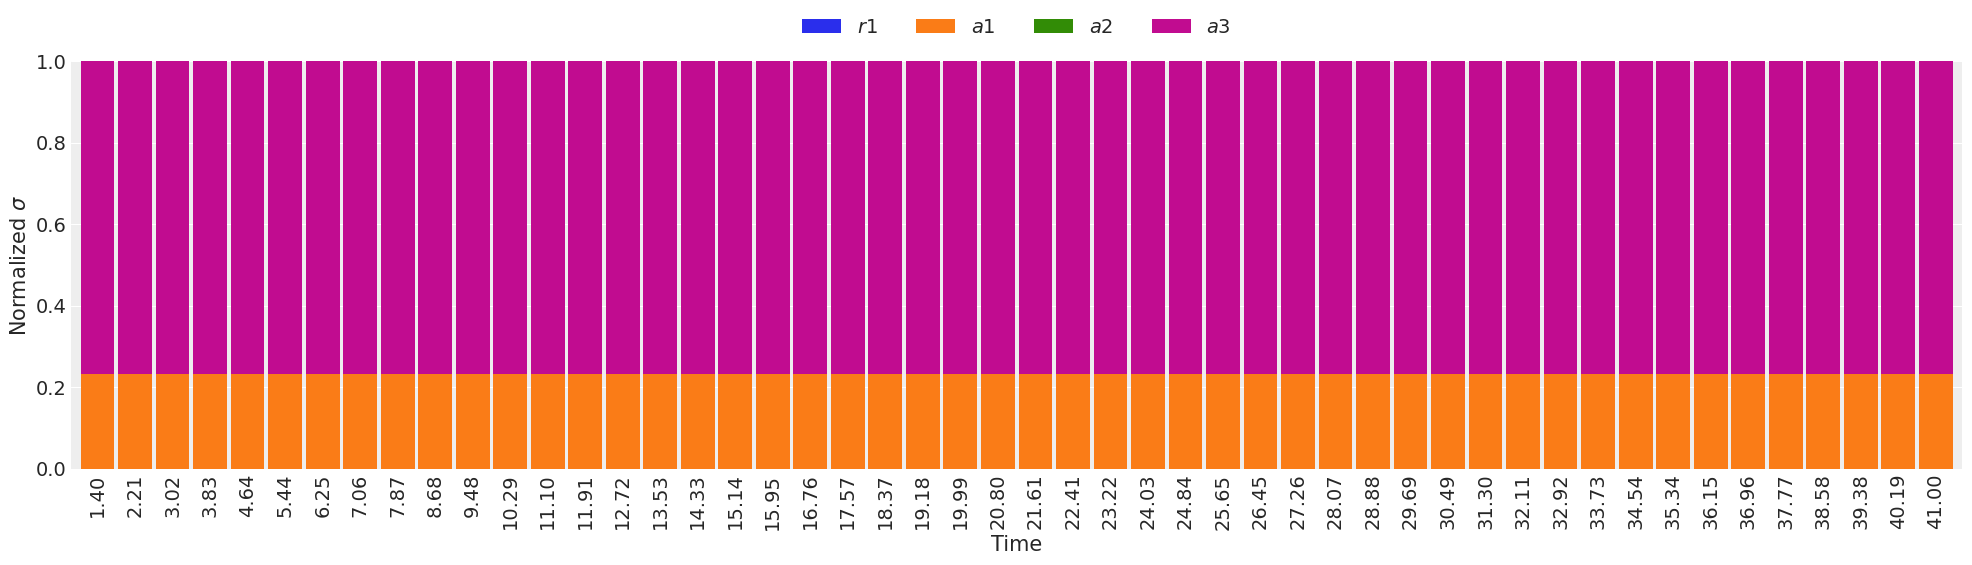

In [98]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_CP3.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [99]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [100]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_CP3,
    u_CP3,
    v_CP3,
    CP3_model,
    mean_values_params
)

pest_time_derivative_array

array([-57.04306157, -57.04306157, -57.04306157, -57.04306157,
       -57.04306157, -57.04306157, -57.04306157, -57.04306157,
       -57.04306157, -57.04306157, -57.04306157, -57.04306157,
       -57.04306157, -57.04306157, -57.04306157, -57.04306157,
       -57.04306157, -57.04306157, -57.04306157, -57.04306157,
       -57.04306157, -57.04306157, -57.04306157, -57.04306157,
       -57.04306157, -57.04306157, -57.04306157, -57.04306157,
       -57.04306157, -57.04306157, -57.04306157, -57.04306157,
       -57.04306157, -57.04306157, -57.04306157, -57.04306157,
       -57.04306157, -57.04306157, -57.04306156, -57.04306156,
       -57.04306156, -57.04306156, -57.04306156, -57.04306156,
       -57.04306156, -57.04306156, -57.04306156, -57.04306156,
       -57.04306156, -57.04306156, -57.04306156, -57.04306156,
       -57.04306156, -57.04306156, -57.04306156, -57.04306156,
       -57.04306156, -57.04306155, -57.04306155, -57.04306155,
       -57.04306155, -57.04306155, -57.04306155, -57.04

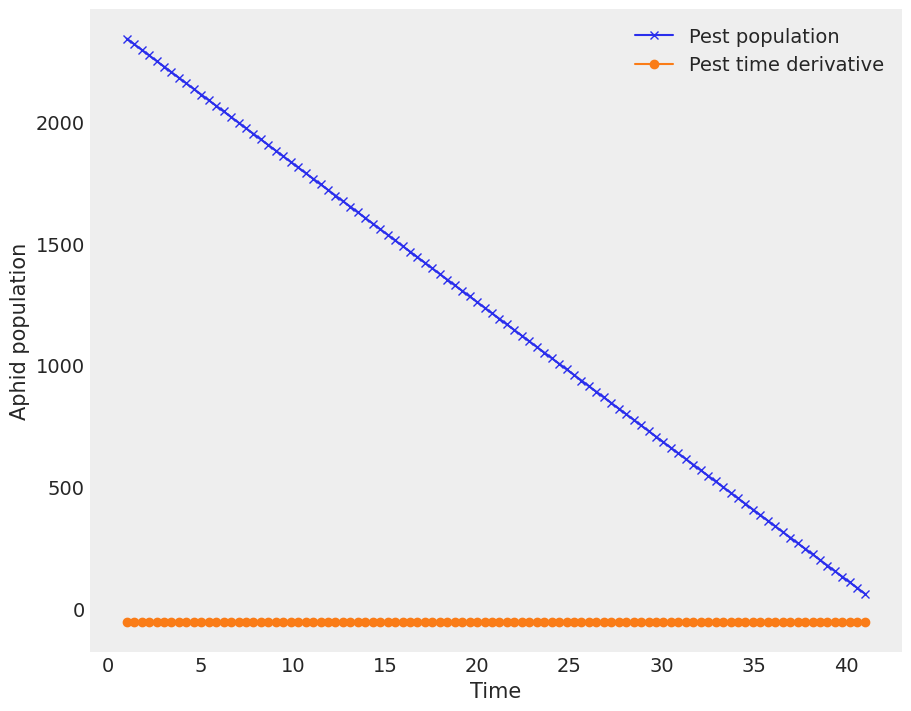

In [101]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_CP3, u_CP3, '-x', label='Pest population')
plt.plot(t_computed_CP3, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative_CP3.png", dpi=300)
plt.show()

In [102]:
mean_values_params = [
    r1,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [103]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_CP3 = CP3_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_CP3.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        CP3_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 20/20 [00:00<00:00, 409.62it/s]


In [104]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 168.70it/s]


Time         $r1$      $a1$         $a2$      $a3$
0    1.404040  9.99009e-06  0.437908  4.55789e-11  0.562082
1    1.808081  9.99009e-06  0.437908  4.67718e-11  0.562082
2    2.212121  9.99009e-06  0.437908  4.80174e-11  0.562082
3    2.616162  9.99009e-06  0.437908  4.93198e-11  0.562082
4    3.020202  9.99009e-06  0.437908  5.06826e-11  0.562082
..        ...          ...       ...          ...       ...
94  39.383838  9.99011e-06  0.437908  3.75667e-07  0.562081
95  39.787879   9.9901e-06  0.437908  3.65618e-07  0.562081
96  40.191919   9.9901e-06  0.437908  4.11871e-08  0.562082
97  40.595960   9.9901e-06  0.437908  1.50011e-08  0.562082
98  41.000000  9.99009e-06  0.437908  7.77829e-09  0.562082

[99 rows x 5 columns]

In [105]:
df_sigmai

Time         $r1$      $a1$         $a2$      $a3$
0    1.404040   2.8567e-16  0.232614  8.22228e-11  0.767386
1    1.808081  3.68799e-16  0.232614  8.56842e-11  0.767386
2    2.212121  1.64932e-16  0.232614  8.93434e-11  0.767386
3    2.616162  2.73508e-16  0.232614  9.32177e-11  0.767386
4    3.020202  1.64932e-16  0.232614  9.73232e-11  0.767386
..        ...          ...       ...          ...       ...
94  39.383838  1.39323e-10  0.232617  1.97214e-06  0.767381
95  39.787879  4.91978e-11  0.232617  1.91931e-06  0.767381
96  40.191919  2.29222e-11  0.232614  2.14848e-07  0.767385
97  40.595960  1.25928e-11  0.232614  7.72296e-08  0.767386
98  41.000000  7.74928e-12  0.232614   3.9229e-08  0.767386

[99 rows x 5 columns]

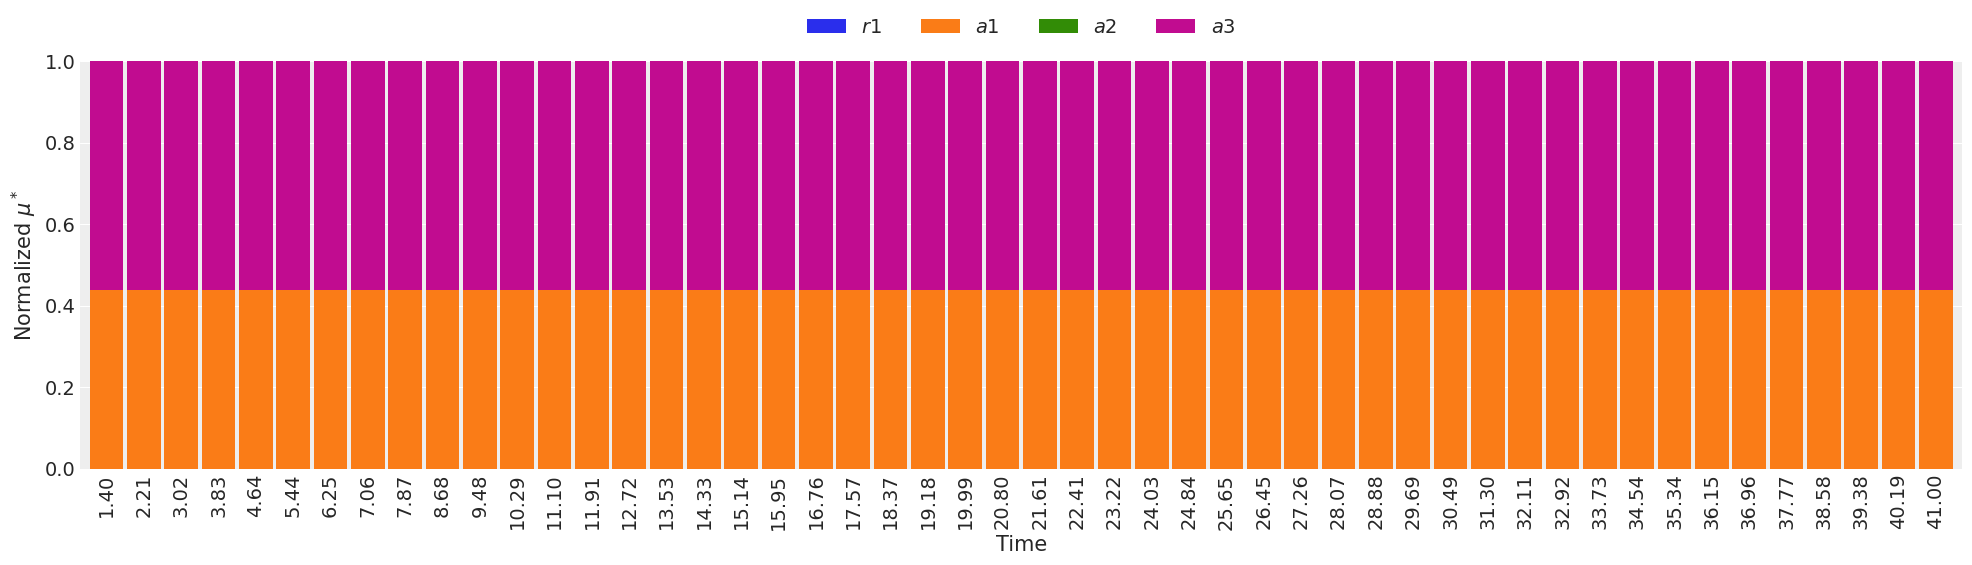

In [106]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_CP3.png", dpi=300)
plt.show()

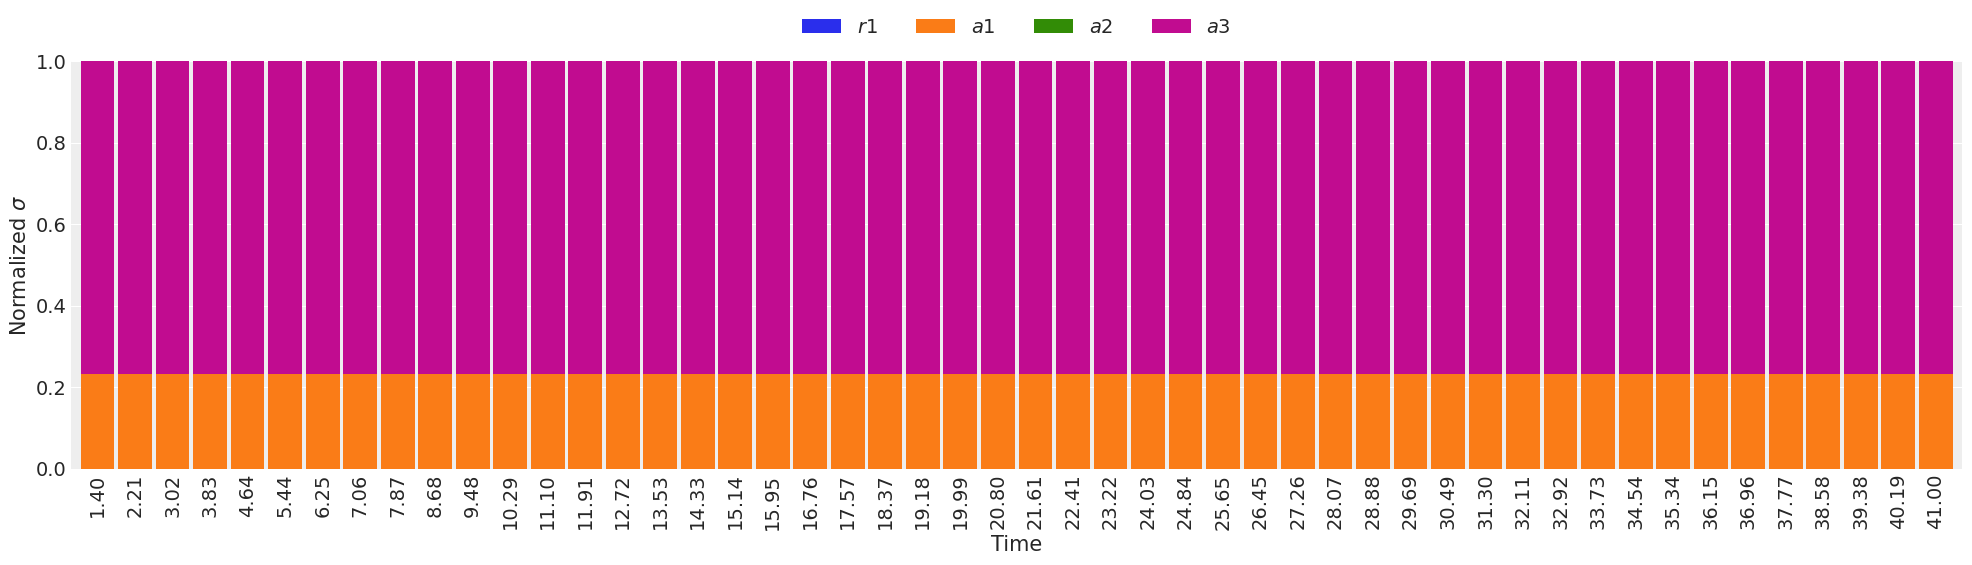

In [107]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_CP3.png", dpi=300)
plt.show()

## Bayesian calibration

In [108]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # a1
        t.dscalar,  # a2
        t.dscalar,  # a3
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def CP3_ode_wrapper(time_exp, r1, a1, a2, a3, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, a1, a2, a3]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        CP3_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [109]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_CP3:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + 100 * percent_calibration) * a1,
    )
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 +  100 * percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "CP3_model",
        CP3_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + 100 * percent_calibration) * a1,
    )
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 +  100 * percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "CP3_model",
        CP3_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + 100 * percent_calibration) * a1,
    )
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 +  100 * percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "CP3_model",
        CP3_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_CP3:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_CP3 = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (4 chains in 4 jobs)
MLDA: [std_deviation, a3, a1]


Sampling 4 chains for 1_000 tune and 4_500 draw iterations (4_000 + 18_000 draws total) took 184 seconds.
The number of effective samples is smaller than 10% for some parameters.


-- Monte Carlo simulations done in 3.332 minutes


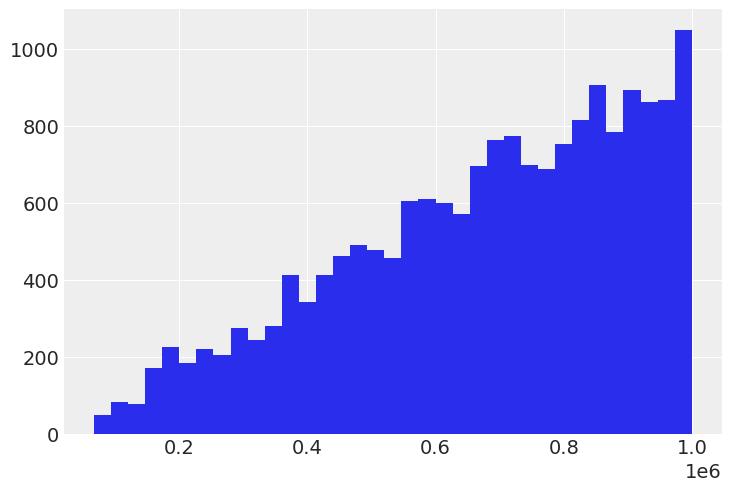

In [110]:
plt.hist(trace_calibration_CP3['a1'], bins=35)
plt.show()

In [111]:
calibration_variable_names = [
    "std_deviation",
    "a1",
    "a3",
]

100%|██████████| 3/3 [00:35<00:00, 11.96s/it]


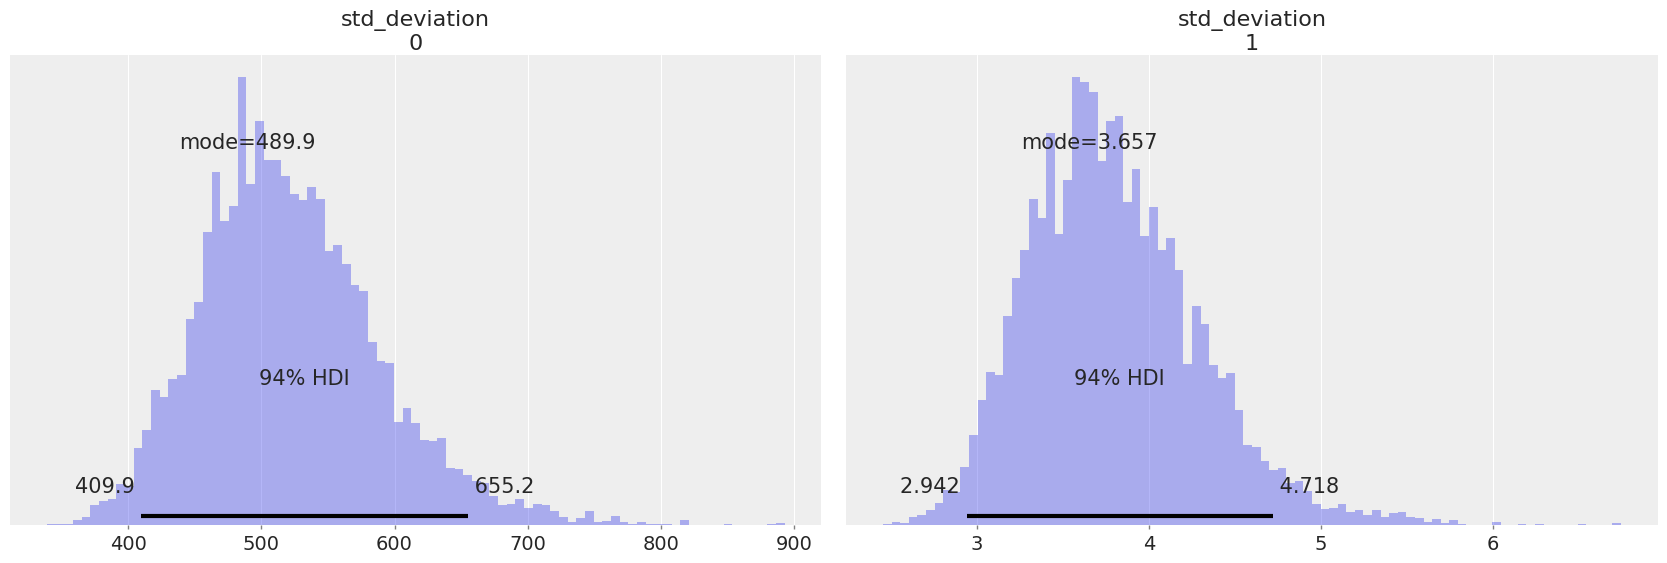

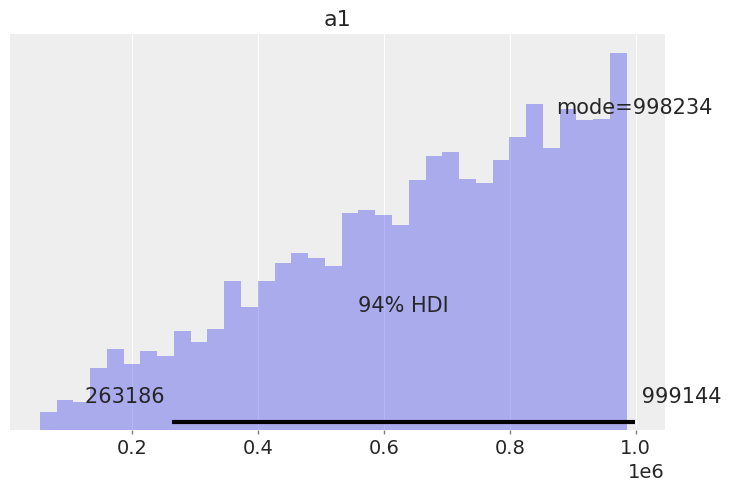

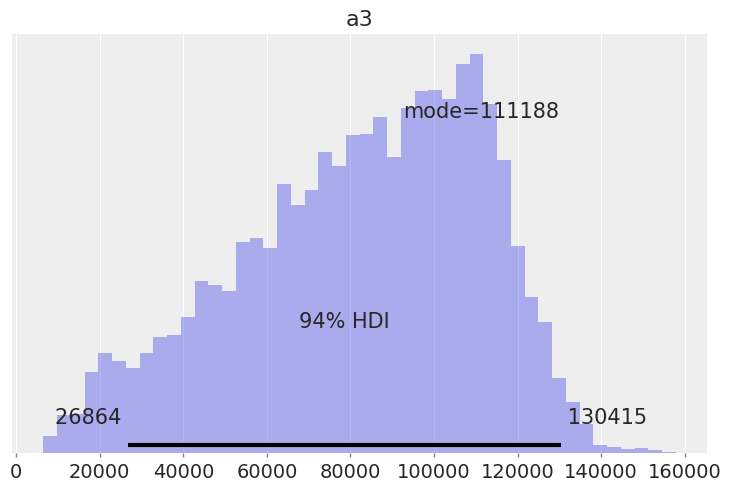

In [112]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_CP3[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal_CP3.png")

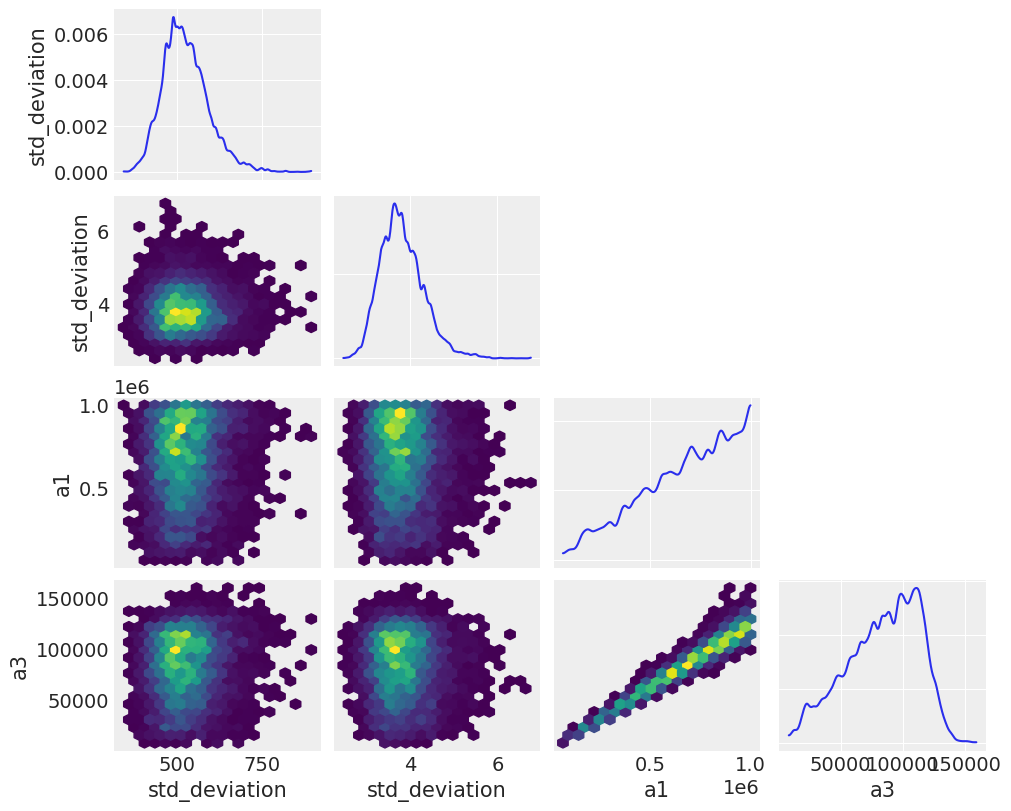

In [113]:
az.plot_pair(
    trace_calibration_CP3,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_CP3.png")

In [114]:
df_stats_summary = az.summary(
    data=trace_calibration_CP3,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

mean             sd         hdi_3%        hdi_97%
std_deviation[0]     525.192602      66.756255     409.918044     655.221028
std_deviation[1]       3.821592       0.493663       2.941778       4.718120
a1                674360.401460  227505.969798  263185.830477  999143.689446
a3                 83997.476857   28943.242832   26863.508132  130415.381006

Auxiliary functions to compute the Most Probable Value (MPV):

In [115]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [116]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_CP3, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_CP3.csv")  # salvando em um csv para consultas

df_stats_summary

Calculating MPV from KDE for a3: 100%|██████████| 3/3 [00:23<00:00,  7.78s/it]           


mean             sd         hdi_3%        hdi_97%  \
std_deviation[0]     525.192602      66.756255     409.918044     655.221028   
std_deviation[1]       3.821592       0.493663       2.941778       4.718120   
a1                674360.401460  227505.969798  263185.830477  999143.689446   
a3                 83997.476857   28943.242832   26863.508132  130415.381006   

                            mpv  
std_deviation[0]     496.857980  
std_deviation[1]       3.677243  
a1                928113.619568  
a3                109336.671289

In [117]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_CP3["CP3_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_CP3["CP3_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_CP3["CP3_model"], 50, axis=0)

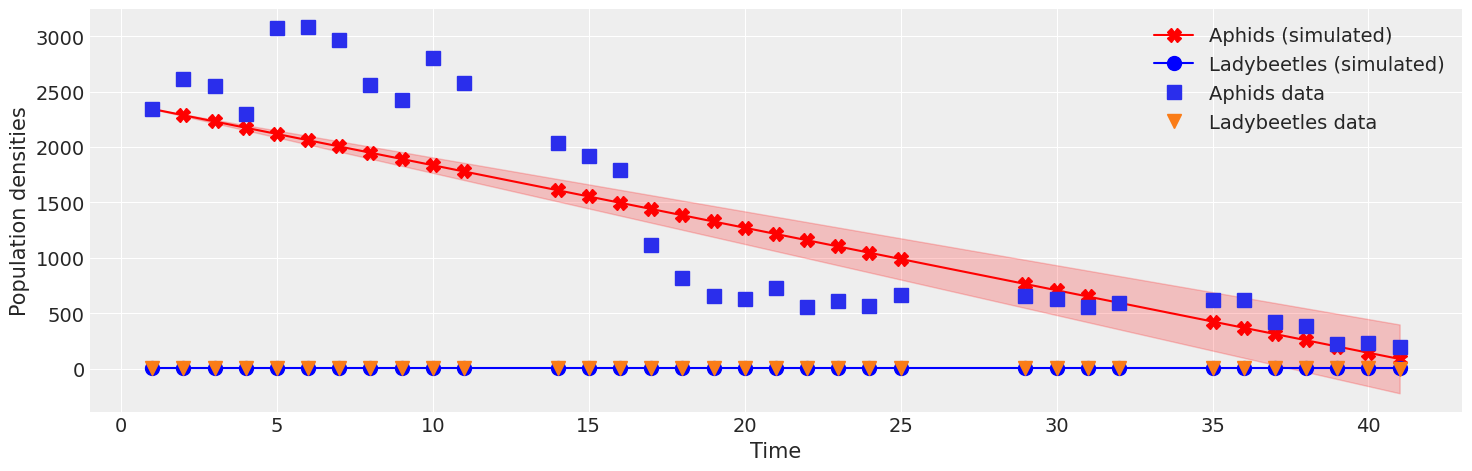

In [118]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration_CP3.png", dpi=300)
plt.show()

In [119]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_CP3.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_CP3.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering a3 realizations: 100%|██████████| 2/2 [00:00<00:00, 902.39it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.102 seconds


In [120]:
df_realizations

a1             a3
0      672858.488183   85842.741111
1      672858.488183   85842.741111
2      672858.488183   85842.741111
3      559610.733858   66174.788163
4      614932.578151   77071.172592
...              ...            ...
17995  942748.951889  126218.168302
17996  931692.821253  103660.731317
17997  935210.932059  103521.125077
17998  905746.503180  109618.588364
17999  888933.445996  106680.259133

[18000 rows x 2 columns]

# Exponential Prey Growth FR1 model

In [121]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def EP1_model(
    t,
    X,
    r1 = 1,
    a1 = 1,
):
    u, v = X
    u_prime = r1 * u - a1 * u * v 
    v_prime = 0
    return u_prime, v_prime

def EP1_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 1,
    a1 = 1,
):
    solution_ODE = solve_ivp(
        fun=EP1_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,a1),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [122]:
def EP1_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [123]:
from scipy import optimize

seed = 1234

r1=0.0025591841125063588
a1=0.005814656330586127
denom_min = 0.1
denom_max = 1.9
bounds_EP1 = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
]

result_EP1 = optimize.differential_evolution(
    EP1_least_squares_error_ode,
    bounds=bounds_EP1,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        EP1_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=20000, # 2000
    polish=True,
    disp=True,
    seed = seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_EP1)

differential_evolution step 1: f(x)= 5.08629e+06
parameters = [0.00179602 0.00577837]

differential_evolution step 2: f(x)= 5.08582e+06
parameters = [0.00316379 0.00596312]

differential_evolution step 3: f(x)= 5.08485e+06
parameters = [0.00346877 0.00591506]

differential_evolution step 4: f(x)= 5.08463e+06
parameters = [0.00296638 0.00585748]

differential_evolution step 5: f(x)= 5.08456e+06
parameters = [0.00240363 0.0057904 ]

differential_evolution step 6: f(x)= 5.08455e+06
parameters = [0.00244503 0.00579956]

differential_evolution step 7: f(x)= 5.08455e+06
parameters = [0.00322744 0.00591027]

differential_evolution step 8: f(x)= 5.08455e+06
parameters = [0.00322744 0.00591027]

differential_evolution step 9: f(x)= 5.08455e+06
parameters = [0.00322744 0.00591027]

differential_evolution step 10: f(x)= 5.08455e+06
parameters = [0.00306363 0.00588665]

     fun: 5084554.357936325
     jac: array([-1730.95613718, 15910.62173247])
 message: 'Optimization terminated successfully.'
 

* Retrieving the calibrated parameter values:

In [124]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    a1_deterministic,
) = result_EP1.x

solution_ODE_EP1 = EP1_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_EP1.x
)
t_computed_EP1, y_computed_EP1 = solution_ODE_EP1.t, solution_ODE_EP1.y
u_EP1, v_EP1 = y_computed_EP1

parameters_dict = {
    "Model": "EP1",
    u"$r1$": r1_deterministic,
    u"$a1$": a1_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "a1=" + str(a1_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=0.0030635732486513734
a1=0.005886745382220292


#### Simulation

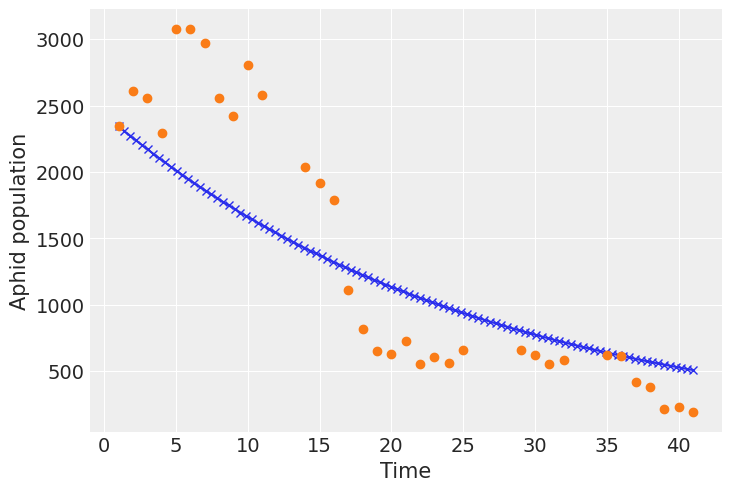

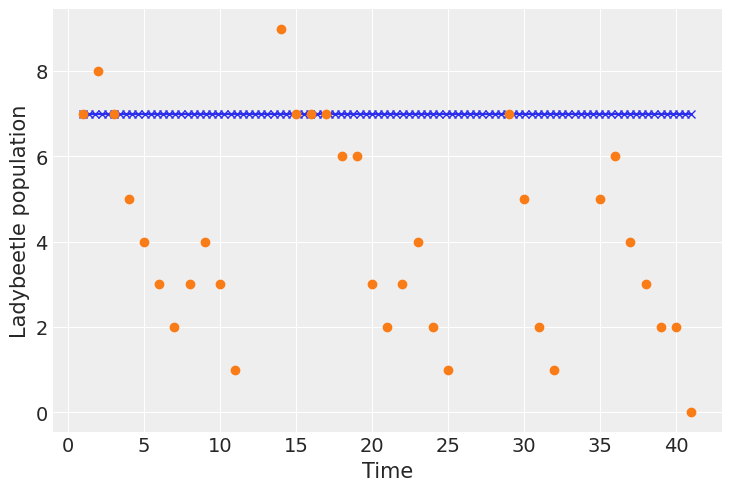

In [125]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_EP1, u_EP1, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_EP1, v_EP1, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [126]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    a1,
]
factors_names = [
    r"$r1$",
    r"$a1$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [127]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = EP1_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        EP1_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 12/12 [00:00<00:00, 487.62it/s]


In [128]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$a1$  0.890587
$r1$  0.109413

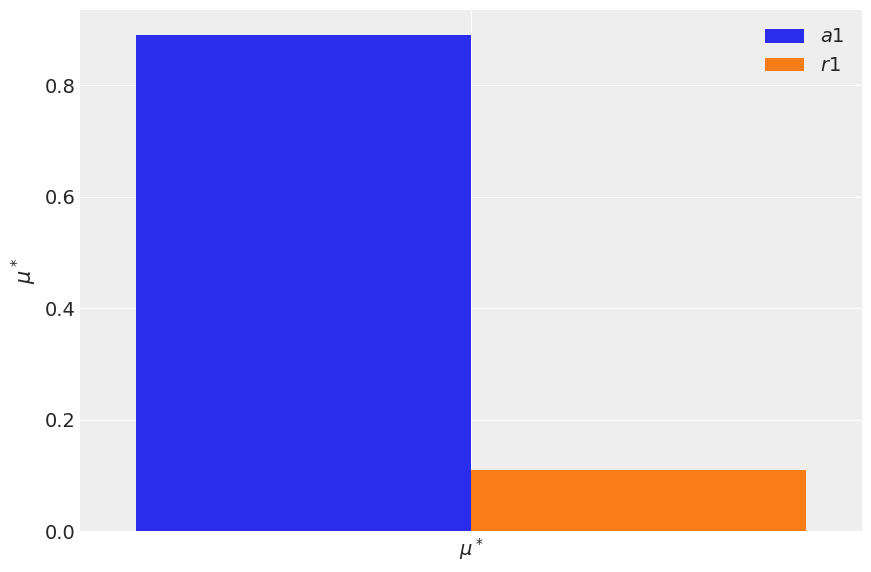

In [129]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares_EP1.png", dpi=300)
plt.show()

### Prey (pest) population

In [130]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    a1,
]
factors_names = [
    r"$r1$",
    r"$a1$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [131]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_EP1 = EP1_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_EP1.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 12/12 [00:00<00:00, 744.90it/s]


In [132]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 246.38it/s]


Time       $r1$      $a1$
0    1.404040   0.059179  0.940821
1    1.808081  0.0591425  0.940857
2    2.212121   0.058627  0.941373
3    2.616162  0.0583679  0.941632
4    3.020202  0.0581053  0.941895
..        ...        ...       ...
94  39.383838  0.0388988  0.961101
95  39.787879  0.0387122  0.961288
96  40.191919  0.0385294  0.961471
97  40.595960  0.0383469  0.961653
98  41.000000  0.0381634  0.961837

[99 rows x 3 columns]

In [133]:
df_sigmai

Time       $r1$      $a1$
0    1.404040  0.0949919  0.905008
1    1.808081  0.0229858  0.977014
2    2.212121  0.0648396   0.93516
3    2.616162  0.0611514  0.938849
4    3.020202  0.0593477  0.940652
..        ...        ...       ...
94  39.383838  0.0360398   0.96396
95  39.787879  0.0358218  0.964178
96  40.191919  0.0356047  0.964395
97  40.595960  0.0354115  0.964589
98  41.000000  0.0352535  0.964746

[99 rows x 3 columns]

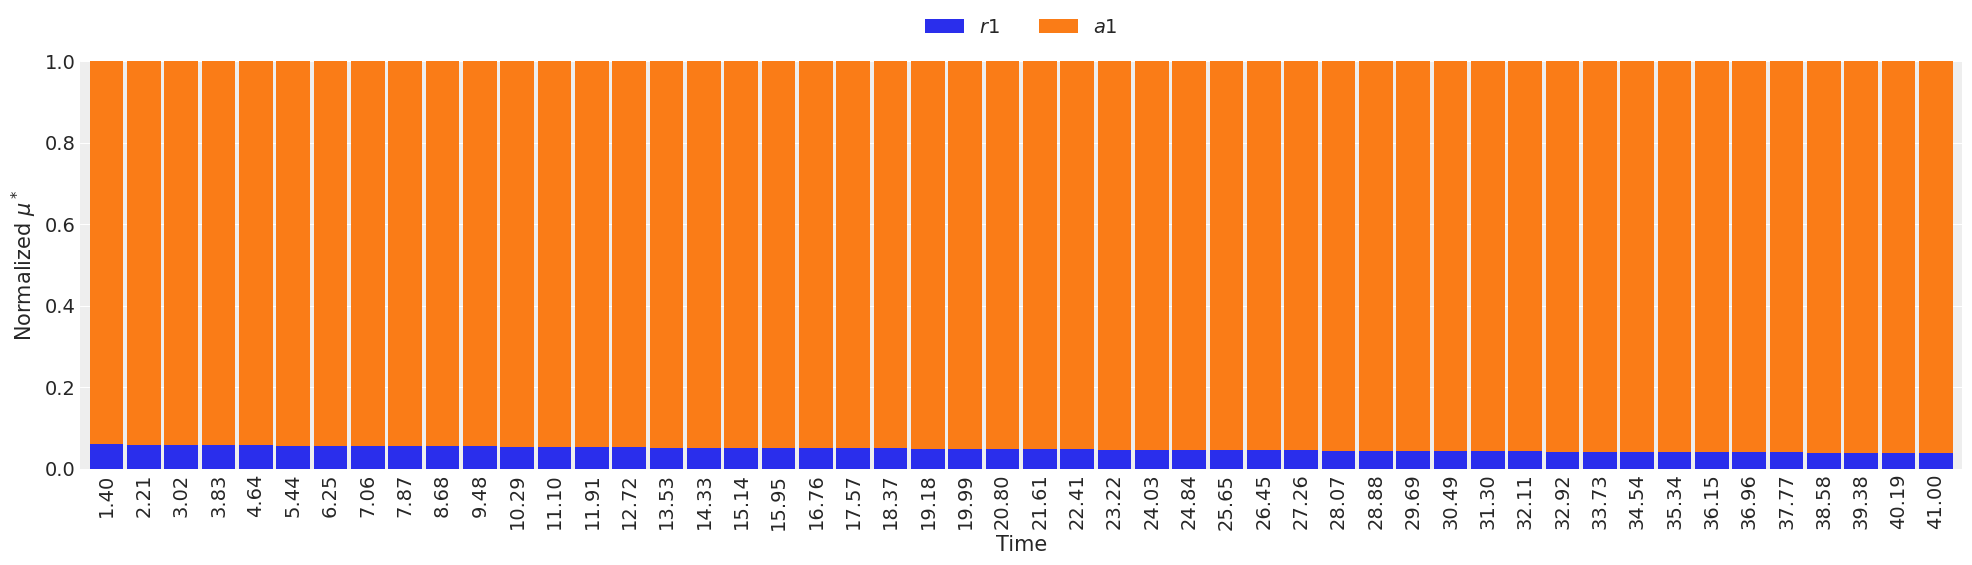

In [134]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_EP1.png", dpi=300)
plt.show()

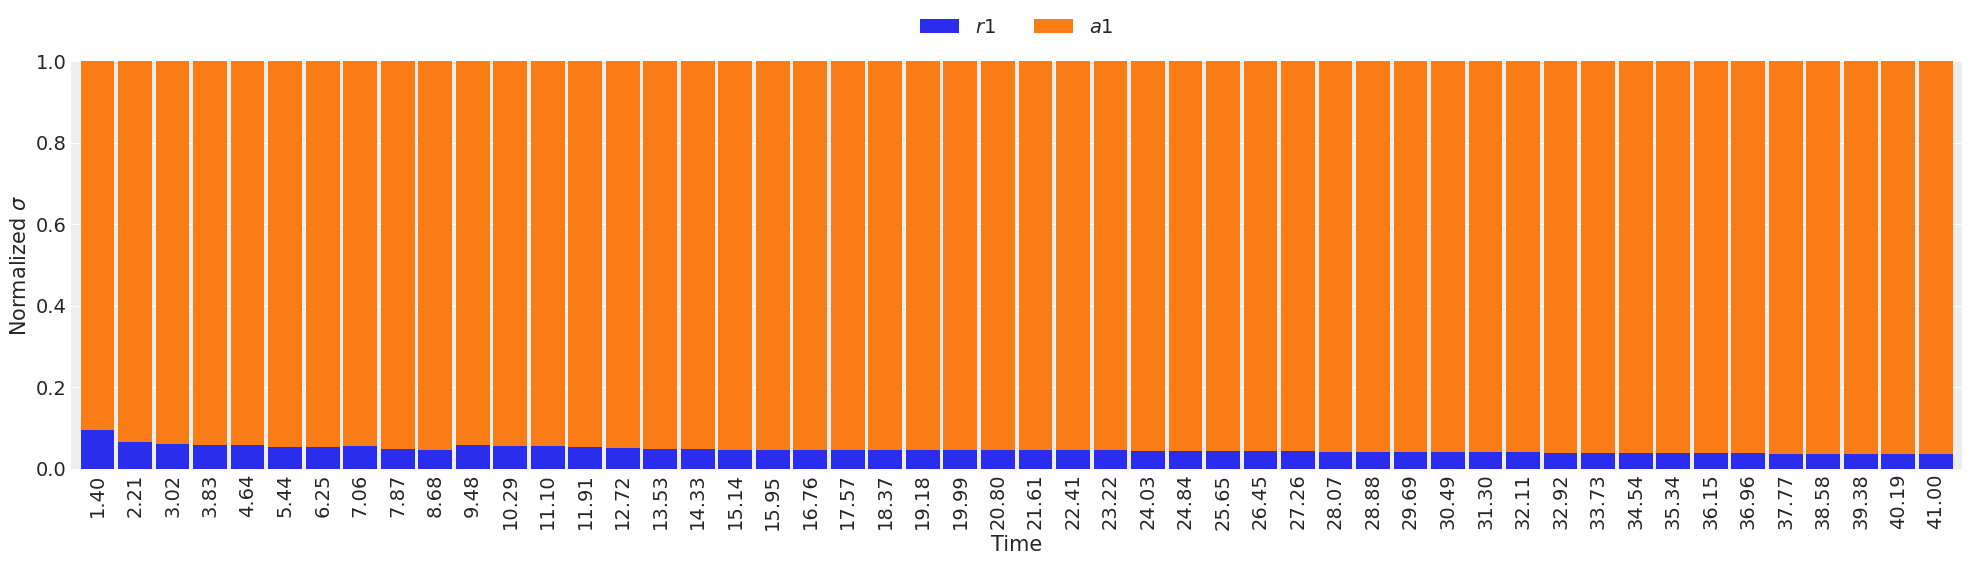

In [135]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_EP1.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [136]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [137]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_EP1,
    u_EP1,
    v_EP1,
    EP1_model,
    mean_values_params
)

pest_time_derivative_array

array([-89.3700101 , -88.02839469, -86.71761374, -85.39153265,
       -84.08536566, -82.79796358, -81.52916575, -80.27897216,
       -79.04738283, -77.83439775, -76.64001692, -75.46424033,
       -74.307068  , -73.16849992, -72.04853608, -70.94640528,
       -69.86011576, -68.78956604, -67.73475612, -66.69568601,
       -65.67235569, -64.66476518, -63.67291448, -62.69680357,
       -61.73643247, -60.79180117, -59.89808683, -58.97155021,
       -58.06032015, -57.16417159, -56.28287946, -55.4162187 ,
       -54.56396424, -53.72589104, -52.90177402, -52.09138812,
       -51.29450602, -50.51069346, -49.73956243, -48.9808507 ,
       -48.23429599, -47.49963606, -46.77660865, -46.06495149,
       -45.36440234, -44.67469894, -43.99557903, -43.32678035,
       -42.66804064, -42.01909766, -41.37968913, -40.74955281,
       -40.12842645, -39.51604777, -38.91217979, -38.31730732,
       -37.73160295, -37.15492315, -36.5871244 , -36.02806319,
       -35.47759599, -34.93557929, -34.40186957, -33.87

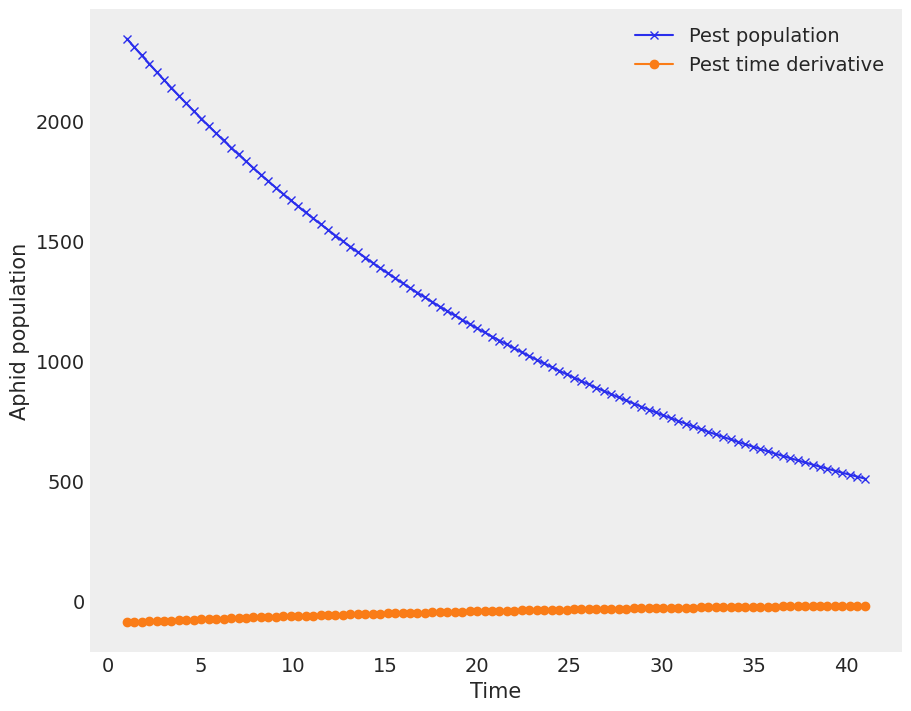

In [138]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_EP1, u_EP1, '-x', label='Pest population')
plt.plot(t_computed_EP1, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative_EP1.png", dpi=300)
plt.show()

In [139]:
mean_values_params = [
    r1,
    a1,
]
factors_names = [
    r"$r1$",
    r"$a1$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [140]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_EP1 = EP1_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_EP1.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        EP1_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 12/12 [00:00<00:00, 318.58it/s]


In [141]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 246.99it/s]


Time       $r1$      $a1$
0    1.404040  0.0586726  0.941327
1    1.808081  0.0581731  0.941827
2    2.212121  0.0576754  0.942325
3    2.616162  0.0571624  0.942838
4    3.020202  0.0566409  0.943359
..        ...        ...       ...
94  39.383838  0.0677694  0.932231
95  39.787879  0.0670473  0.932953
96  40.191919  0.0663614  0.933639
97  40.595960  0.0656976  0.934302
98  41.000000  0.0650492  0.934951

[99 rows x 3 columns]

In [142]:
df_sigmai

Time        $r1$      $a1$
0    1.404040   0.0565321  0.943468
1    1.808081   0.0548712  0.945129
2    2.212121   0.0555201   0.94448
3    2.616162   0.0551197   0.94488
4    3.020202   0.0547134  0.945287
..        ...         ...       ...
94  39.383838  0.00506345  0.994937
95  39.787879  0.00535704  0.994643
96  40.191919  0.00604188  0.993958
97  40.595960  0.00726265  0.992737
98  41.000000  0.00906183  0.990938

[99 rows x 3 columns]

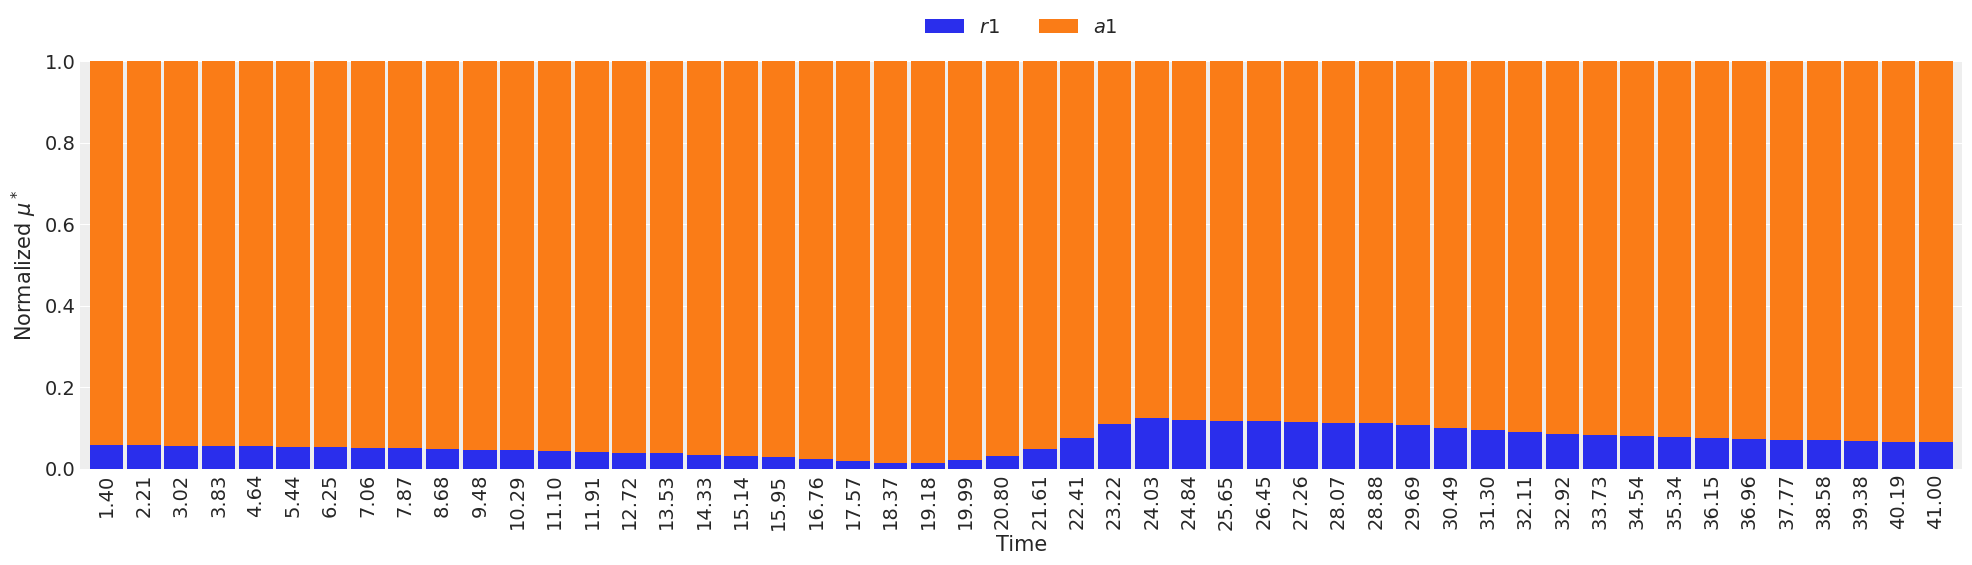

In [143]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_EP1.png", dpi=300)
plt.show()

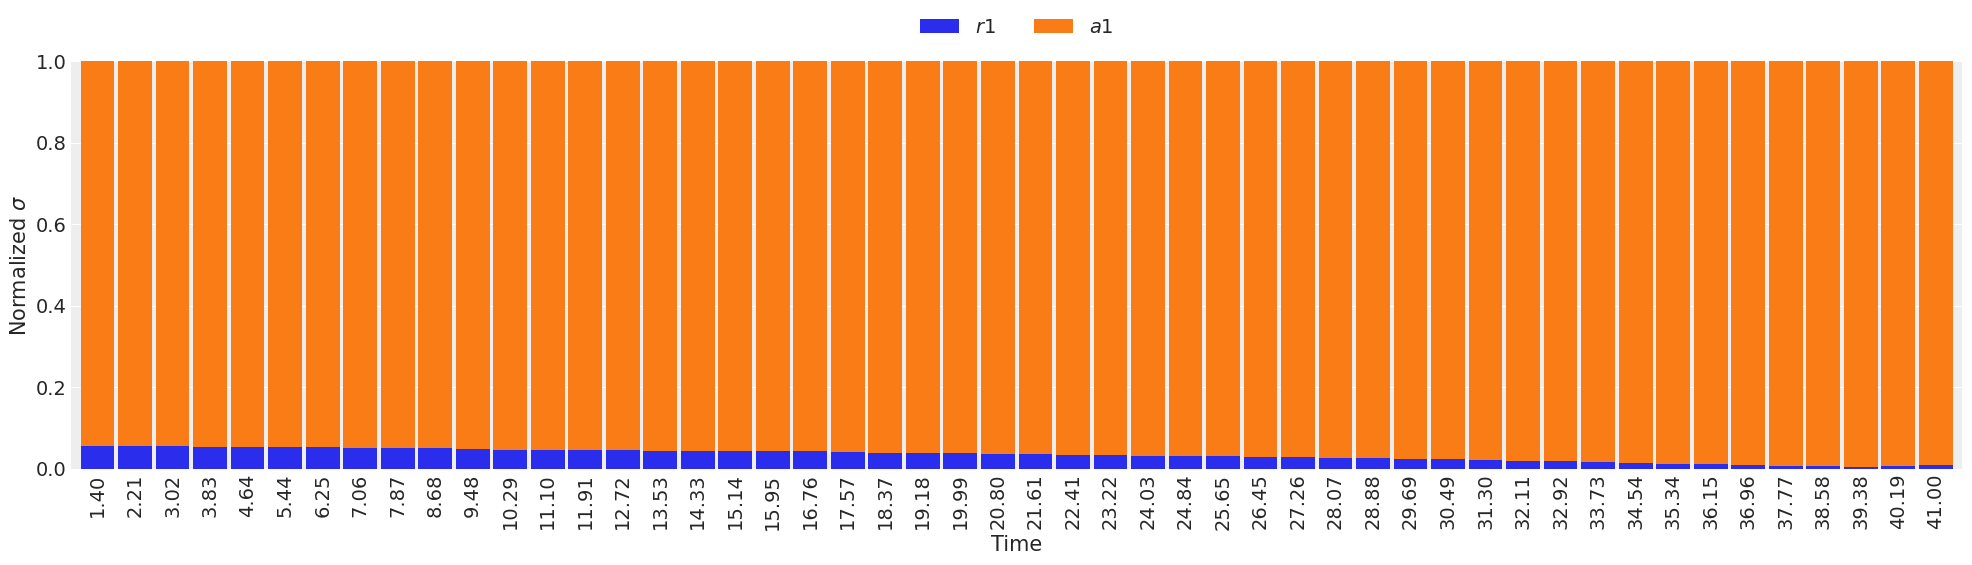

In [144]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_EP1.png", dpi=300)
plt.show()

## Bayesian calibration

In [145]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # a1
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def EP1_ode_wrapper(time_exp, r1, a1, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, a1]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        EP1_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [146]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_EP1:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "EP1_model",
        EP1_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "EP1_model",
        EP1_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "EP1_model",
        EP1_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_EP1:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_EP1 = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (4 chains in 4 jobs)
MLDA: [std_deviation, a1]


Sampling 4 chains for 1_000 tune and 4_500 draw iterations (4_000 + 18_000 draws total) took 288 seconds.
The number of effective samples is smaller than 10% for some parameters.


-- Monte Carlo simulations done in 5.215 minutes


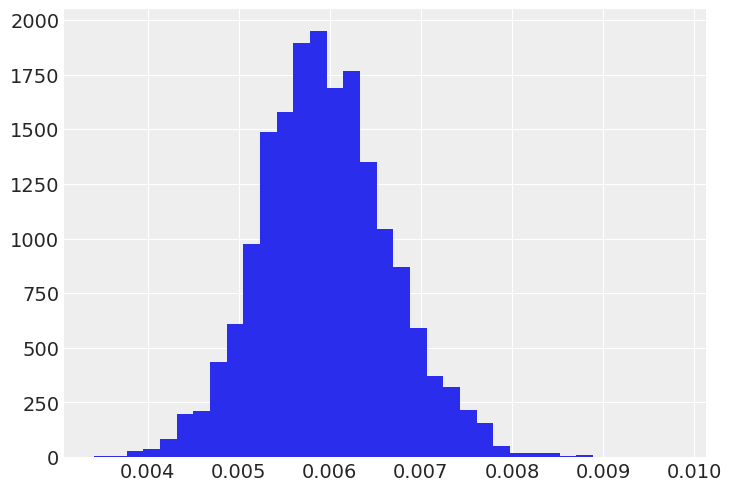

In [147]:
plt.hist(trace_calibration_EP1['a1'], bins=35)
plt.show()

In [148]:
calibration_variable_names = [
    "std_deviation",
    "a1",
]

100%|██████████| 2/2 [00:43<00:00, 21.69s/it]


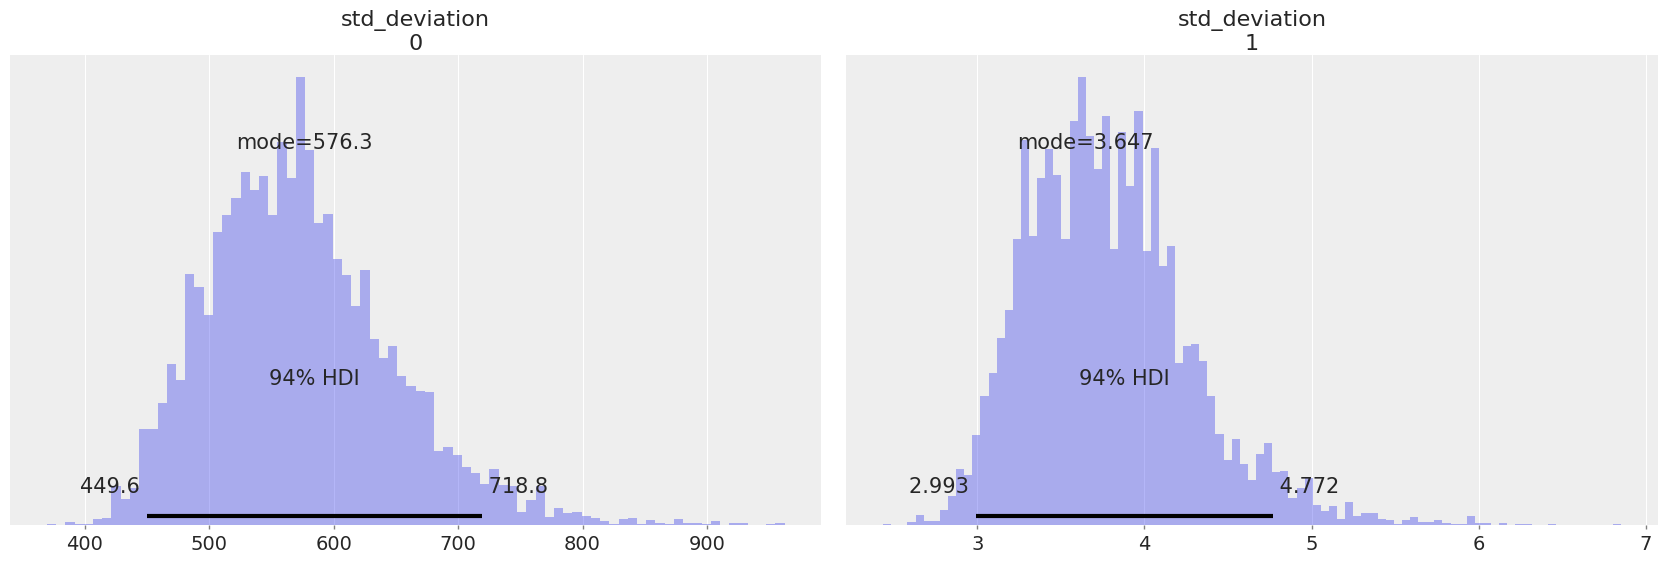

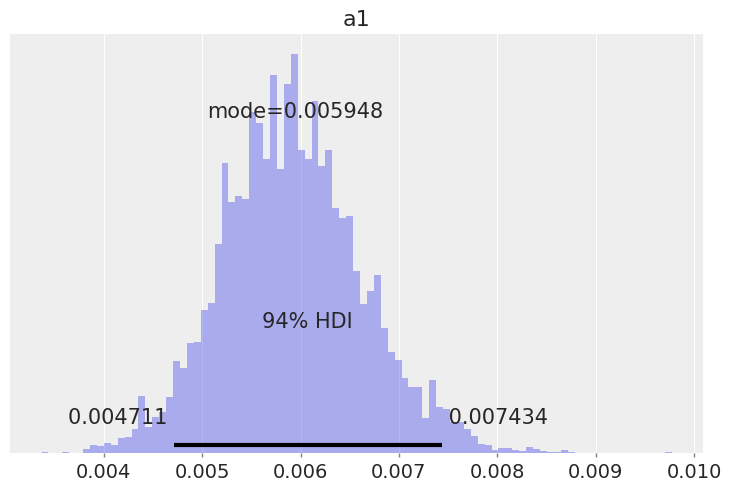

In [149]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_EP1[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal_EP1.png")

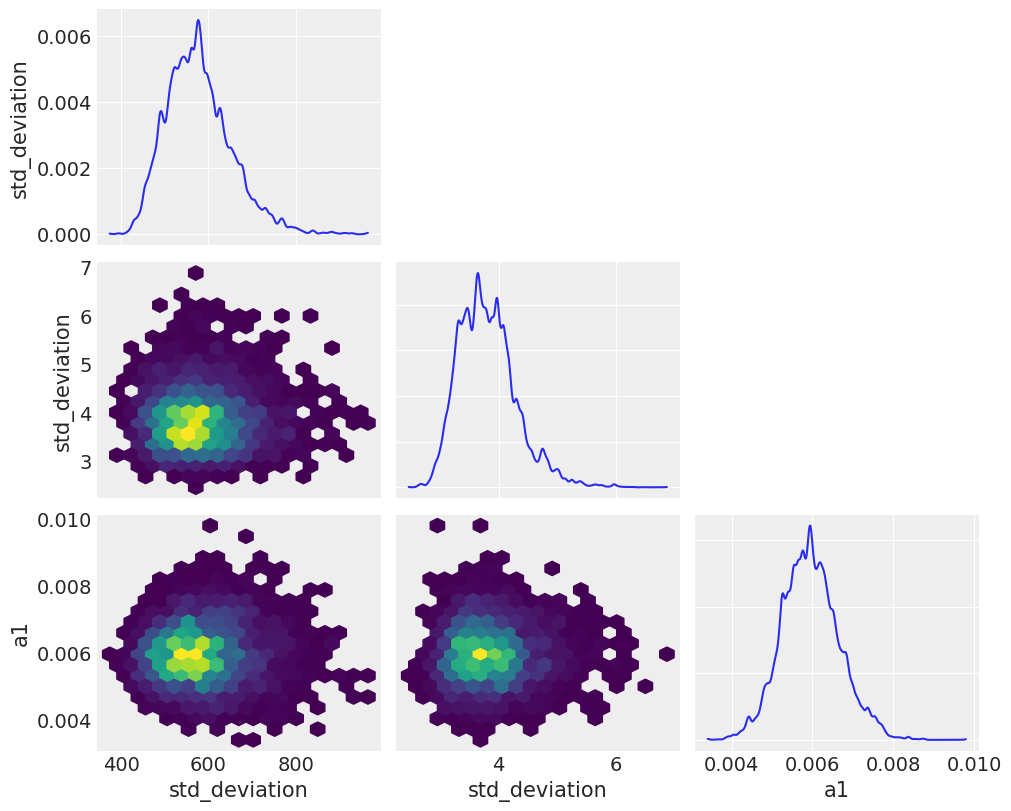

In [150]:
az.plot_pair(
    trace_calibration_EP1,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_EP1.png")

In [151]:
df_stats_summary = az.summary(
    data=trace_calibration_EP1,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

mean         sd      hdi_3%     hdi_97%
std_deviation[0]  577.294008  75.024146  449.616805  718.830776
std_deviation[1]    3.810130   0.491738    2.992760    4.771974
a1                  0.005955   0.000714    0.004711    0.007434

Auxiliary functions to compute the Most Probable Value (MPV):

In [152]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [153]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_EP1, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_EP1.csv")  # salvando em um csv para consultas

df_stats_summary

Calculating MPV from KDE for a1: 100%|██████████| 2/2 [00:19<00:00,  9.56s/it]           


mean         sd      hdi_3%     hdi_97%         mpv
std_deviation[0]  577.294008  75.024146  449.616805  718.830776  573.678913
std_deviation[1]    3.810130   0.491738    2.992760    4.771974    3.661963
a1                  0.005955   0.000714    0.004711    0.007434    0.005925

In [154]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_EP1["EP1_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_EP1["EP1_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_EP1["EP1_model"], 50, axis=0)

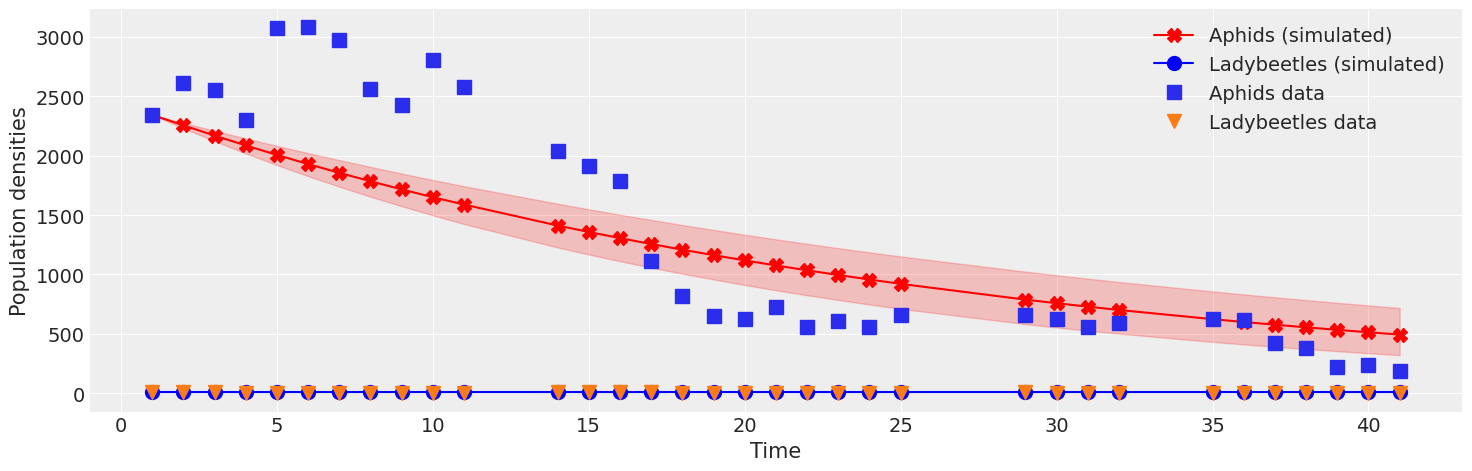

In [155]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration_EP1.png", dpi=300)
plt.show()

In [156]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_EP1.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_EP1.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering a1 realizations: 100%|██████████| 1/1 [00:00<00:00, 365.29it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.085 seconds


In [157]:
df_realizations

a1
0      0.005858
1      0.005857
2      0.005857
3      0.006449
4      0.006449
...         ...
17995  0.007628
17996  0.007129
17997  0.007129
17998  0.007129
17999  0.007198

[18000 rows x 1 columns]

# Exponential Prey Growth FR2 model

## The parameter a1 doesn't have a maximum threshold

In [158]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def EP2_model(
    t,
    X,
    r1 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    u, v = X
    u_prime = r1 * u - a1 * u * v / ( a2 + a3 * u )
    v_prime = 0
    return u_prime, v_prime

def EP2_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    solution_ODE = solve_ivp(
        fun=EP2_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,a1,a2,a3),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [159]:
def EP2_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [160]:
from scipy import optimize

seed = 1234

r1=0.000582078917707341
a1=0.020251827279105163
a2=1.4527465345998702e-05
a3=0.0024486050974377345
denom_min = 0.1
denom_max = 1.9
bounds_EP2 = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
    ( ( a2 * denom_min ), ( a2 * denom_max ) ),  # a2
    ( ( a3 * denom_min ), ( a3 * denom_max ) ),  # a3
]

result_EP2 = optimize.differential_evolution(
    EP2_least_squares_error_ode,
    bounds=bounds_EP2,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        EP2_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=20000, # 2000
    polish=True,
    disp=True,
    seed = seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_EP2)

differential_evolution step 1: f(x)= 4.19757e+06
parameters = [8.88074770e-05 3.17588969e-02 4.82565302e-06 3.89706324e-03]

differential_evolution step 2: f(x)= 4.1968e+06
parameters = [7.91937570e-04 2.96724668e-02 6.08787358e-06 3.57082695e-03]

differential_evolution step 3: f(x)= 4.1968e+06
parameters = [7.91937570e-04 2.96724668e-02 6.08787358e-06 3.57082695e-03]

differential_evolution step 4: f(x)= 4.19671e+06
parameters = [1.02566719e-03 2.86314143e-02 9.69898231e-06 3.42089046e-03]

differential_evolution step 5: f(x)= 4.19671e+06
parameters = [1.02566719e-03 2.86314143e-02 9.69898231e-06 3.42089046e-03]

differential_evolution step 6: f(x)= 4.19669e+06
parameters = [1.02492277e-03 2.47562887e-02 8.84422943e-06 2.96119950e-03]

differential_evolution step 7: f(x)= 4.19668e+06
parameters = [1.06714547e-03 2.55113634e-02 9.13412073e-06 3.04793589e-03]

differential_evolution step 8: f(x)= 4.19668e+06
parameters = [1.07360232e-03 2.94924721e-02 1.10635187e-05 3.52321746e-03]

di

* Retrieving the calibrated parameter values:

In [161]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    a1_deterministic,
    a2_deterministic,
    a3_deterministic,
) = result_EP2.x

solution_ODE_EP2 = EP2_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_EP2.x
)
t_computed_EP2, y_computed_EP2 = solution_ODE_EP2.t, solution_ODE_EP2.y
u_EP2, v_EP2 = y_computed_EP2

parameters_dict = {
    "Model": "EP2",
    u"$r1$": r1_deterministic,
    u"$a1$": a1_deterministic,
    u"$a2$": a2_deterministic,
    u"$a3$": a3_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "a1=" + str(a1_deterministic) + "\n" + "a2=" + str(a2_deterministic) + "\n" + "a3=" + str(a3_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=0.0011059499436439479
a1=0.03520154629594531
a2=2.2217891102704532e-05
a3=0.004200832924604613


#### Simulation

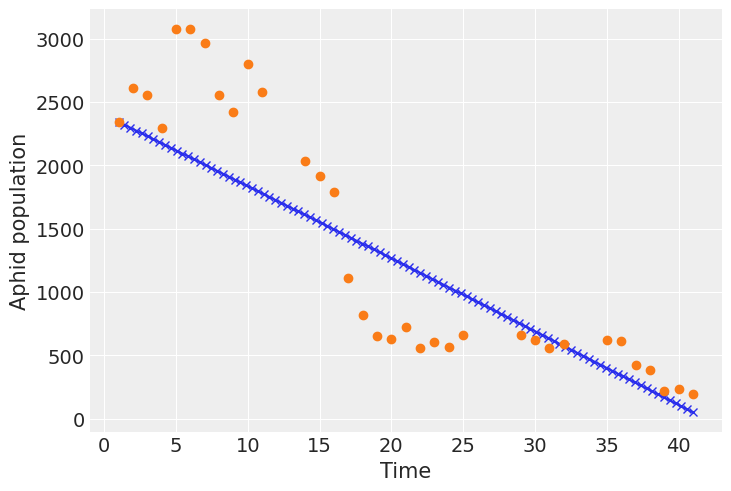

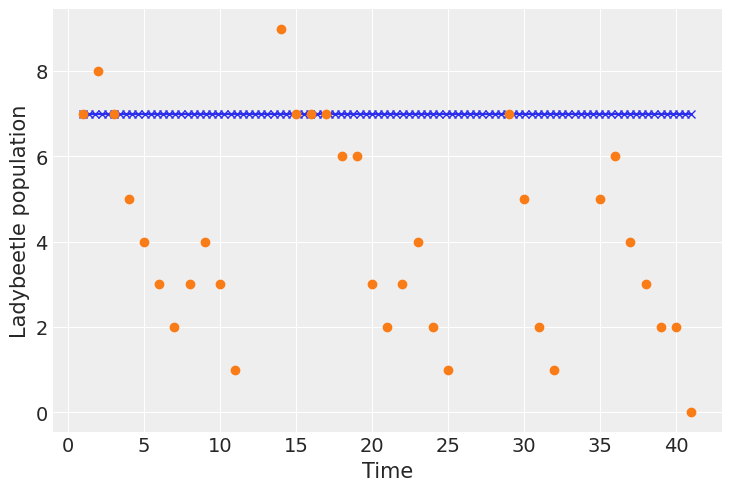

In [162]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_EP2, u_EP2, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_EP2, v_EP2, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [163]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [164]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = EP2_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        EP2_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 20/20 [00:00<00:00, 910.92it/s]


In [165]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$a3$     0.634557
$a1$     0.361607
$r1$   0.00383454
$a2$  1.35636e-06

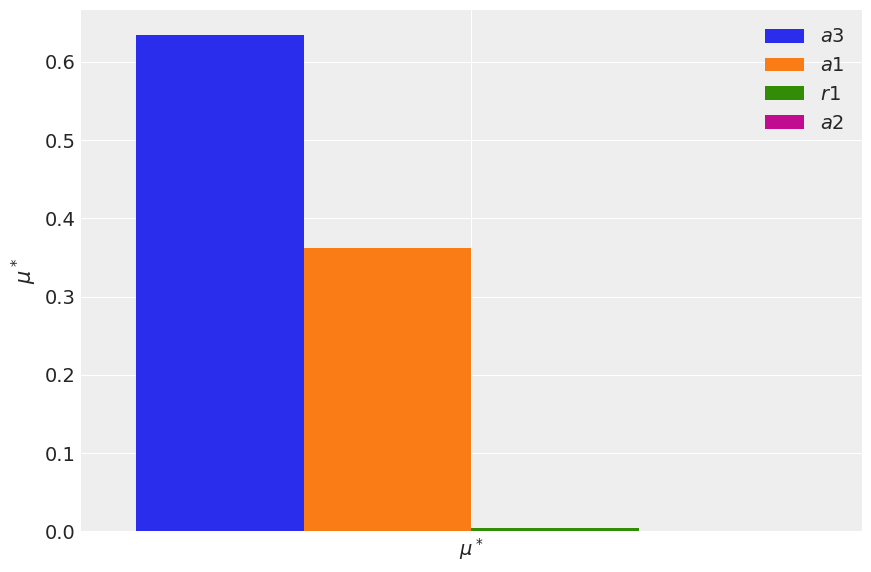

In [166]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares_EP2.png", dpi=300)
plt.show()

### Prey (pest) population

In [167]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [168]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_EP2 = EP2_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_EP2.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 20/20 [00:00<00:00, 1383.82it/s]


In [169]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 158.10it/s]


Time        $r1$      $a1$         $a2$      $a3$
0    1.404040   0.0104679  0.433335   1.6839e-06  0.556195
1    1.808081   0.0104349    0.4333  1.69388e-06  0.556263
2    2.212121   0.0103621   0.43337    1.703e-06  0.556266
3    2.616162   0.0103466  0.433359  1.70494e-06  0.556293
4    3.020202   0.0103138  0.433357  1.70011e-06  0.556327
..        ...         ...       ...          ...       ...
94  39.383838  0.00507409  0.434615  4.63759e-06  0.560306
95  39.787879  0.00501506   0.43463  4.69958e-06  0.560351
96  40.191919  0.00495603  0.434644  4.76156e-06  0.560395
97  40.595960  0.00489701  0.434659  4.82353e-06   0.56044
98  41.000000    0.004838  0.434673  4.88551e-06  0.560484

[99 rows x 5 columns]

In [170]:
df_sigmai

Time         $r1$      $a1$         $a2$      $a3$
0    1.404040  0.000101654  0.232491  3.04421e-06  0.767404
1    1.808081  0.000259977  0.232484  3.09358e-06  0.767253
2    2.212121  0.000155008  0.232437  3.09026e-06  0.767405
3    2.616162  0.000219412  0.232403  3.09894e-06  0.767374
4    3.020202  0.000282502  0.232365   3.0835e-06  0.767349
..        ...          ...       ...          ...       ...
94  39.383838   0.00556653  0.228382  2.03507e-05  0.766031
95  39.787879   0.00562407  0.228338  2.05838e-05  0.766017
96  40.191919    0.0056816  0.228294  2.08168e-05  0.766003
97  40.595960    0.0057391   0.22825  2.10499e-05  0.765989
98  41.000000   0.00579658  0.228207  2.12829e-05  0.765975

[99 rows x 5 columns]

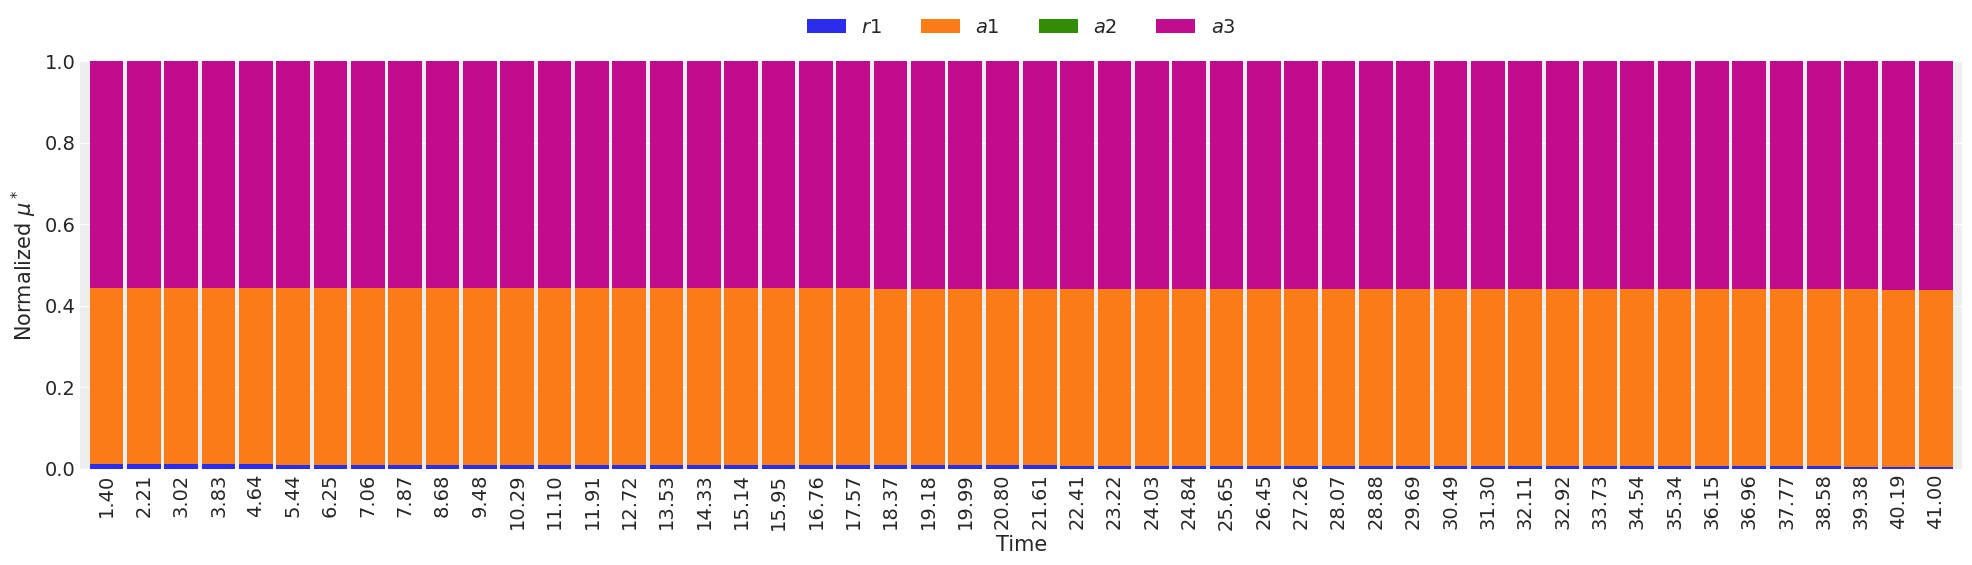

In [171]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_EP2.png", dpi=300)
plt.show()

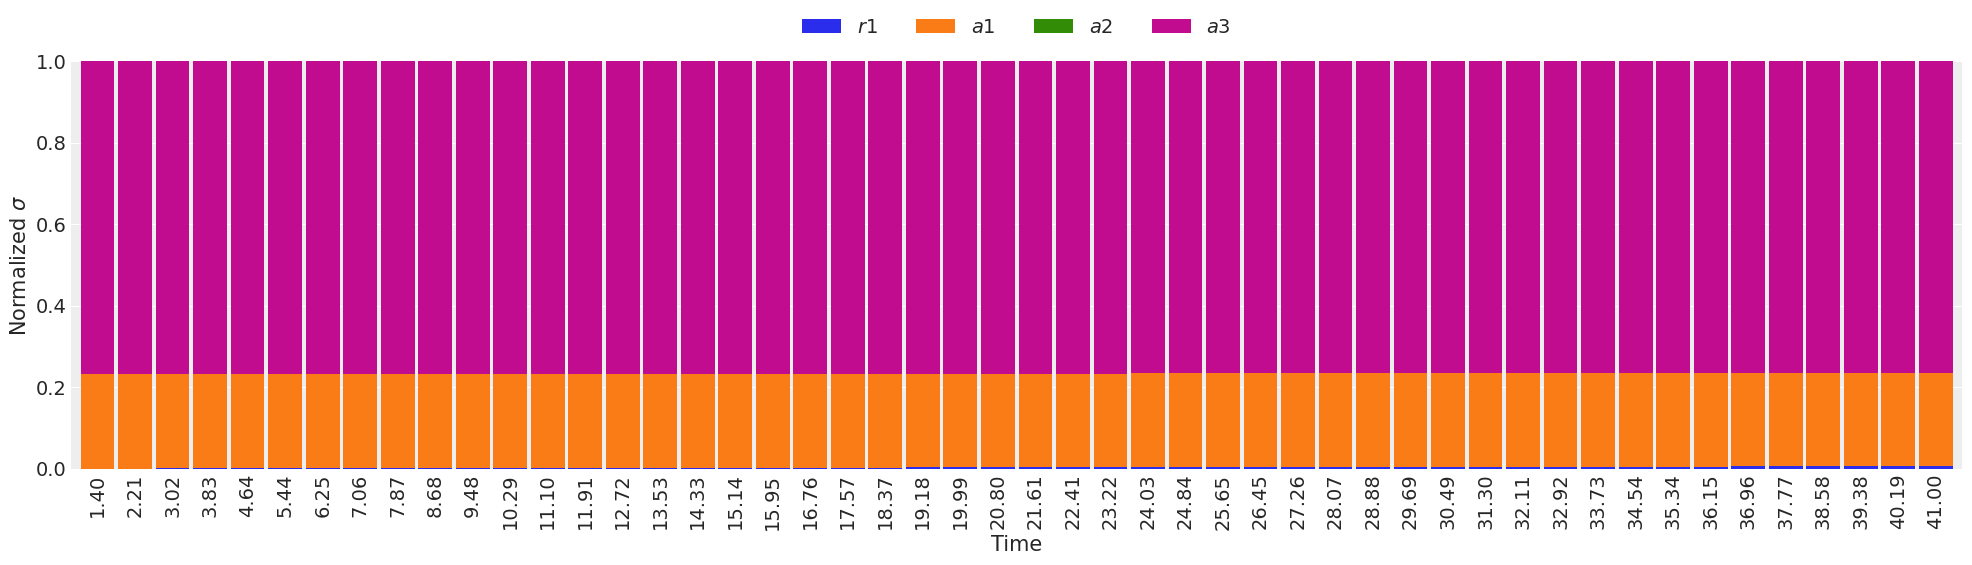

In [172]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_EP2.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [173]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [174]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_EP2,
    u_EP2,
    v_EP2,
    EP2_model,
    mean_values_params
)

pest_time_derivative_array

array([-56.53136874, -56.54456666, -56.55776456, -56.5709794 ,
       -56.58418437, -56.59739523, -56.61061206, -56.62383486,
       -56.63706365, -56.65029842, -56.66353916, -56.67678588,
       -56.69003858, -56.70329726, -56.7165619 , -56.72983252,
       -56.74310911, -56.75639167, -56.76968019, -56.78297469,
       -56.79627514, -56.80958156, -56.82289393, -56.83621226,
       -56.84953655, -56.86286679, -56.87620298, -56.88954512,
       -56.9028932 , -56.91624722, -56.92960718, -56.94297308,
       -56.95634491, -56.96972267, -56.98310635, -56.99649595,
       -57.00989146, -57.02329289, -57.03670022, -57.05011346,
       -57.06353258, -57.0769576 , -57.0903885 , -57.10382527,
       -57.11726791, -57.13071642, -57.14417077, -57.15763096,
       -57.17109699, -57.18456884, -57.19804651, -57.21152997,
       -57.22501921, -57.23851423, -57.252015  , -57.26552151,
       -57.27903374, -57.29255167, -57.30607527, -57.31960453,
       -57.33313942, -57.34667991, -57.36022596, -57.37

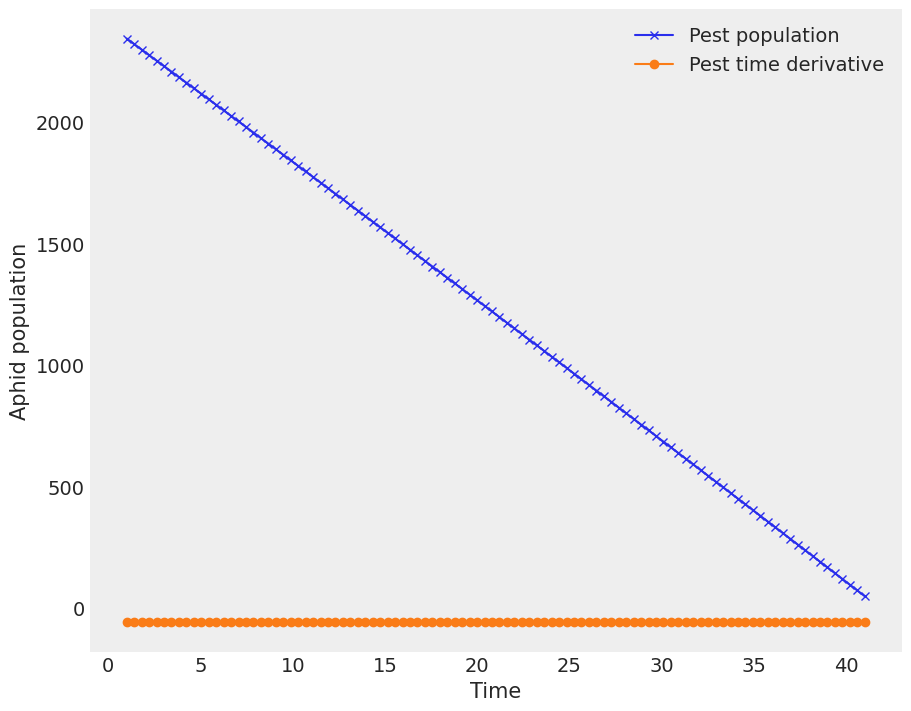

In [175]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_EP2, u_EP2, '-x', label='Pest population')
plt.plot(t_computed_EP2, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative_EP2.png", dpi=300)
plt.show()

In [176]:
mean_values_params = [
    r1,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [177]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_EP2 = EP2_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_EP2.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        EP2_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 20/20 [00:00<00:00, 374.48it/s]


In [178]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 159.07it/s]


Time        $r1$      $a1$         $a2$      $a3$
0    1.404040   0.0105922  0.433252  1.66463e-06  0.556155
1    1.808081   0.0104756  0.433281  1.68639e-06  0.556242
2    2.212121   0.0103589   0.43331  1.70877e-06   0.55633
3    2.616162   0.0102422  0.433339  1.73181e-06  0.556417
4    3.020202   0.0101255  0.433368  1.75553e-06  0.556505
..        ...         ...       ...          ...       ...
94  39.383838  0.00288071  0.434254  0.000106669  0.562758
95  39.787879  0.00290857  0.434437  2.89783e-05  0.562626
96  40.191919  0.00293745   0.43443  1.78086e-05  0.562615
97  40.595960  0.00296672  0.434405   1.3344e-05  0.562615
98  41.000000  0.00299616  0.434375  1.09485e-05  0.562618

[99 rows x 5 columns]

In [179]:
df_sigmai

Time         $r1$      $a1$         $a2$      $a3$
0    1.404040  0.000117866  0.232525  3.01197e-06  0.767354
1    1.808081  0.000235764  0.232436   3.0747e-06  0.767325
2    2.212121  0.000353342  0.232348   3.1397e-06  0.767296
3    2.616162  0.000471044  0.232259  3.20719e-06  0.767266
4    3.020202  0.000588687  0.232171  3.27726e-06  0.767237
..        ...          ...       ...          ...       ...
94  39.383838    0.0109469   0.22325  0.000539941  0.765263
95  39.787879    0.0110478  0.224024  0.000136532  0.764792
96  40.191919    0.0111583  0.224059  7.89383e-05  0.764703
97  40.595960    0.0112697  0.224022  5.61336e-05  0.764652
98  41.000000    0.0113814  0.223963  4.40428e-05  0.764612

[99 rows x 5 columns]

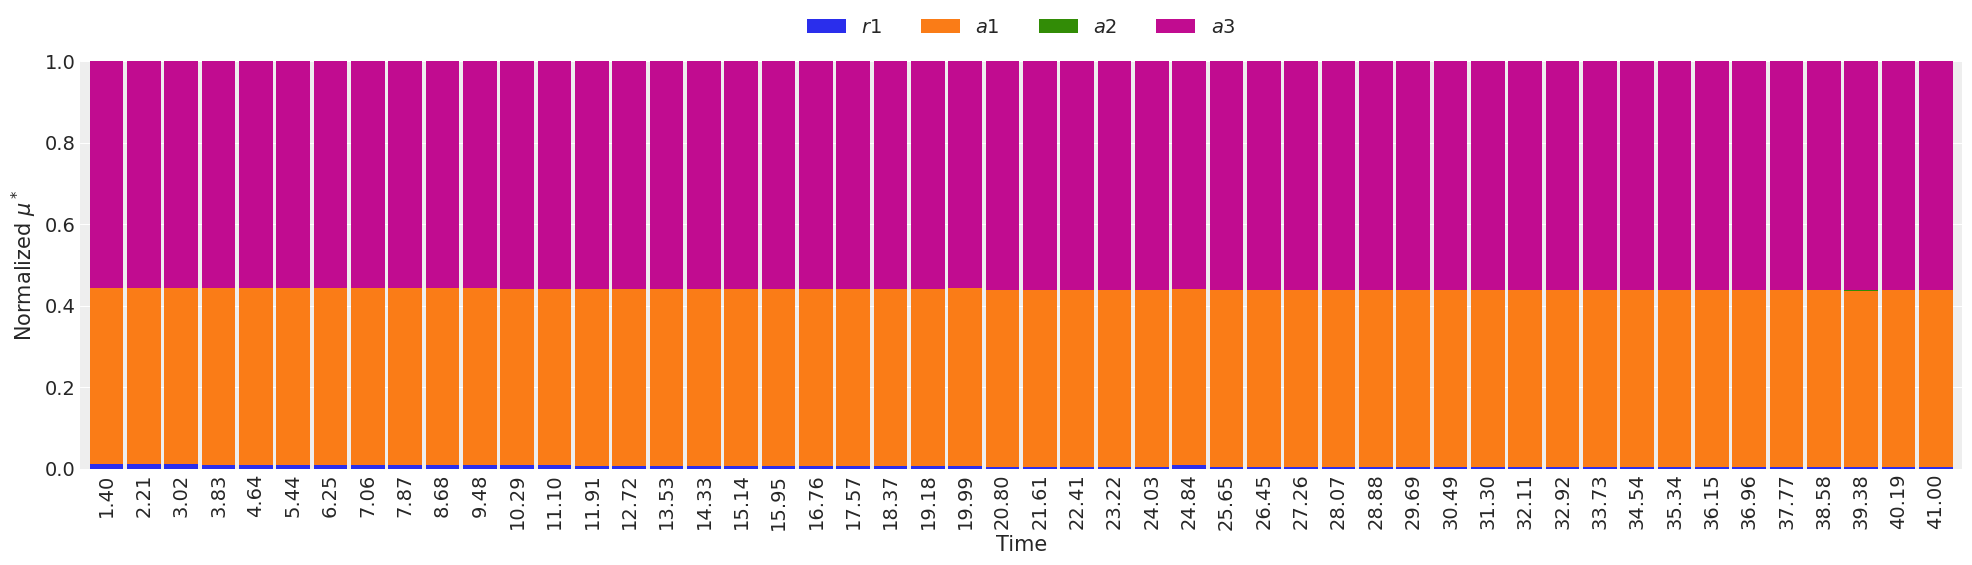

In [180]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_EP2.png", dpi=300)
plt.show()

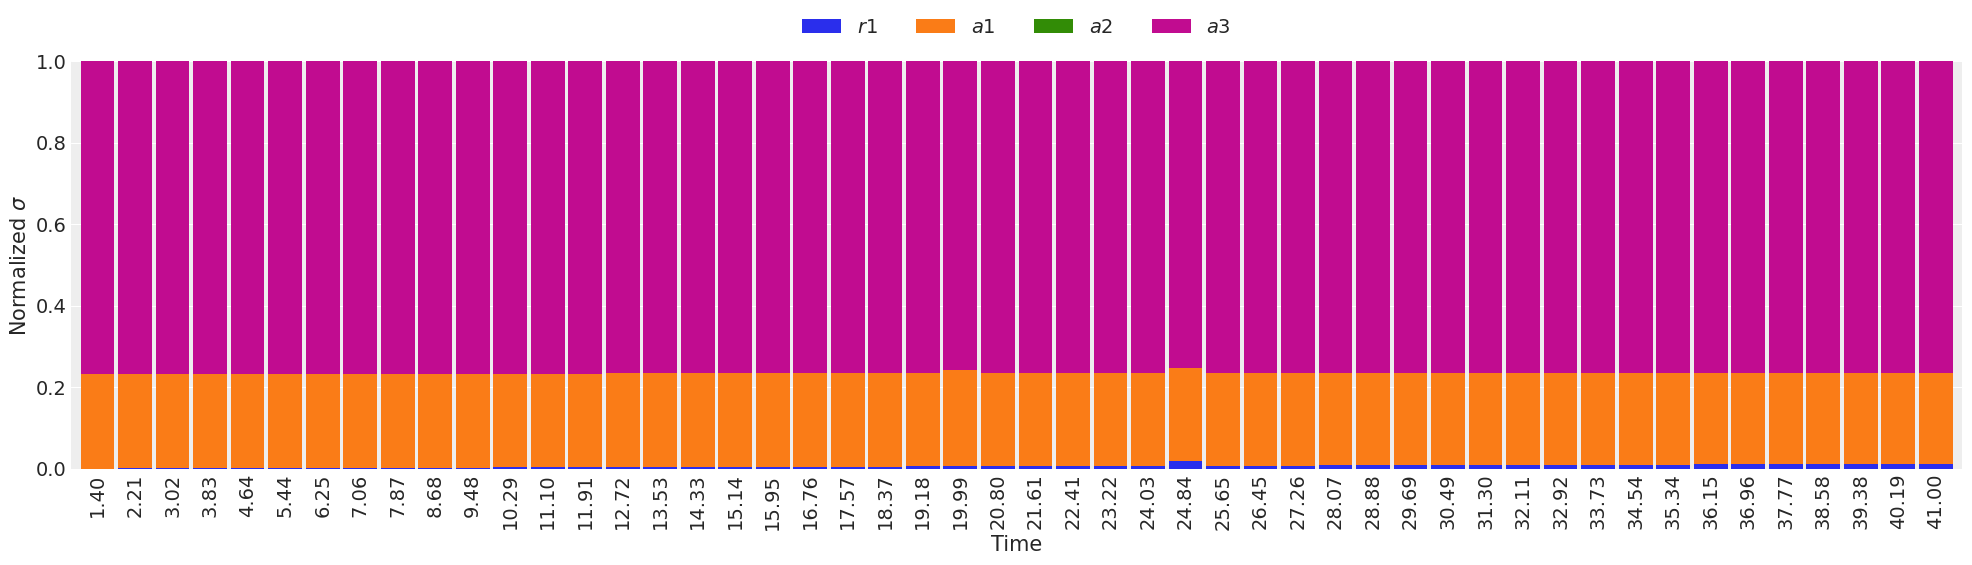

In [181]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_EP2.png", dpi=300)
plt.show()

## Bayesian calibration

In [182]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # a1
        t.dscalar,  # a2
        t.dscalar,  # a3
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def EP2_ode_wrapper(time_exp, r1, a1, a2, a3, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, a1, a2, a3]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        EP2_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [183]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_EP2:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + percent_calibration) * a1,
    )
    a2_ = pm.Data("a2", a2)
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 +  percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "EP2_model",
        EP2_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + percent_calibration) * a1,
    )
    a2_ = pm.Data("a2", a2)
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 +  percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "EP2_model",
        EP2_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + percent_calibration) * a1,
    )
    a2_ = pm.Data("a2", a2)
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 +  percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "EP2_model",
        EP2_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_EP2:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_EP2 = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (4 chains in 4 jobs)
MLDA: [std_deviation, a3, a1]


Sampling 4 chains for 1_000 tune and 4_500 draw iterations (4_000 + 18_000 draws total) took 207 seconds.
The number of effective samples is smaller than 10% for some parameters.


-- Monte Carlo simulations done in 3.715 minutes


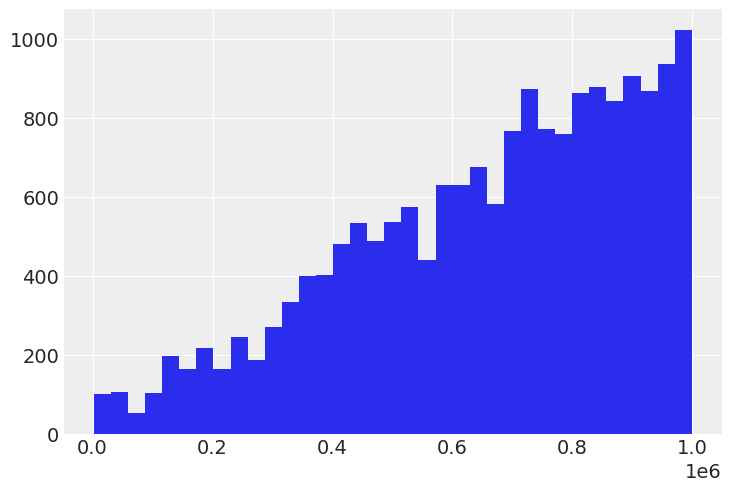

In [184]:
plt.hist(trace_calibration_EP2['a1'], bins=35)
plt.show()

In [185]:
calibration_variable_names = [
    "std_deviation",
    "a1",
    "a3",
]

100%|██████████| 3/3 [00:37<00:00, 12.61s/it]


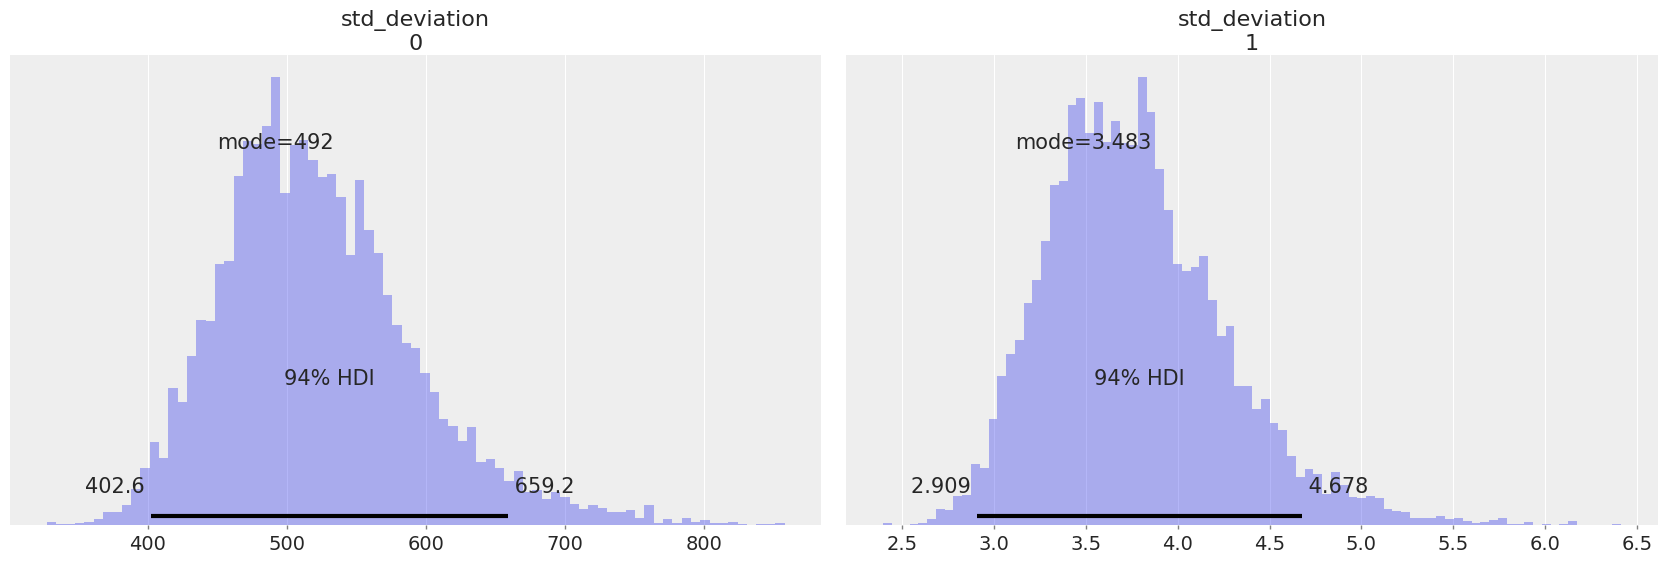

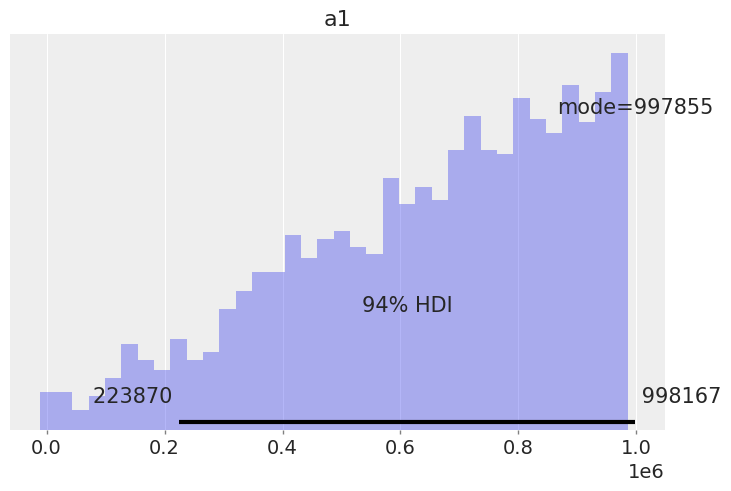

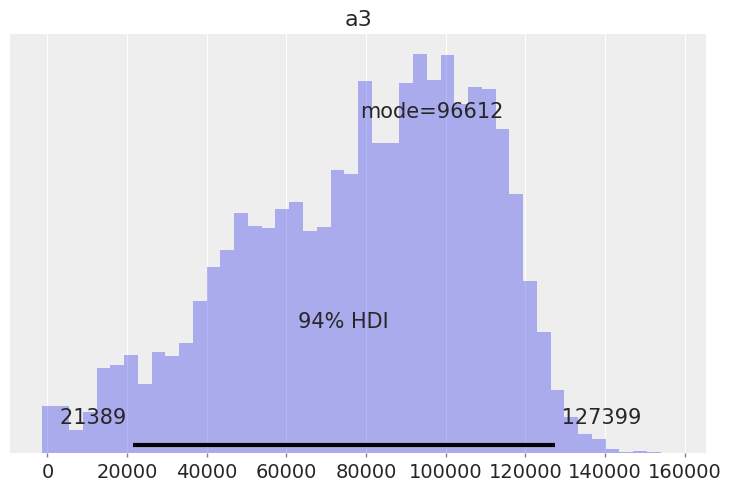

In [186]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_EP2[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal_EP2.png")

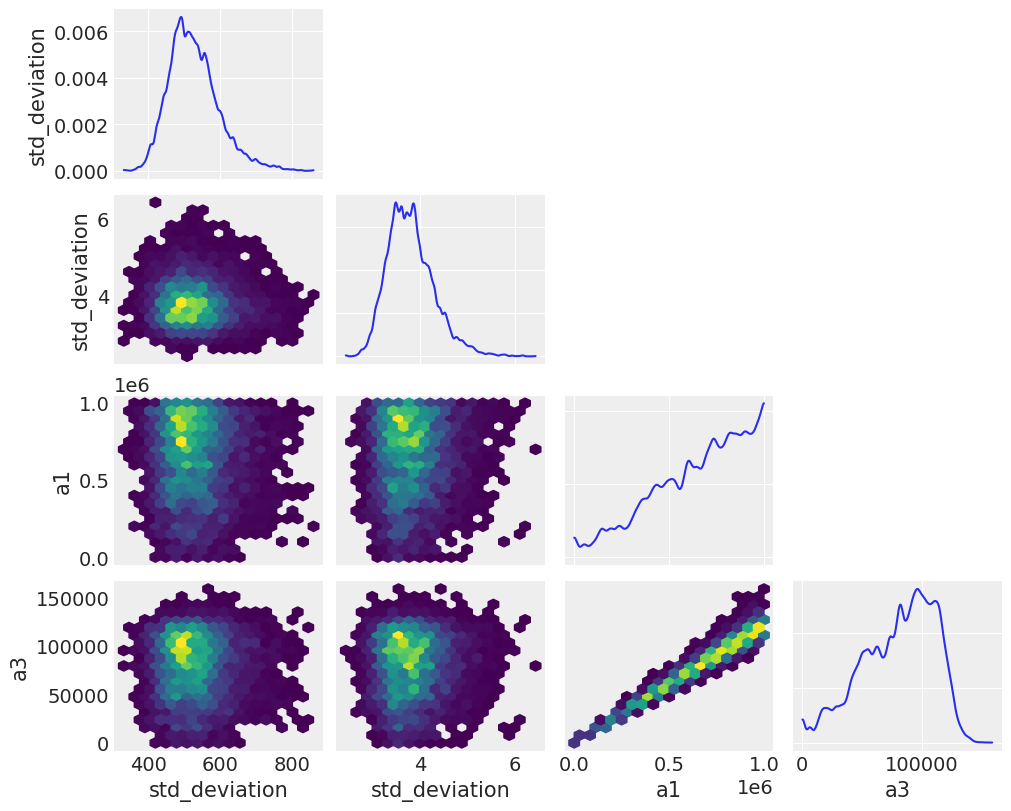

In [187]:
az.plot_pair(
    trace_calibration_EP2,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_EP2.png")

In [188]:
df_stats_summary = az.summary(
    data=trace_calibration_EP2,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

mean             sd         hdi_3%        hdi_97%
std_deviation[0]     526.498958      70.069421     402.565886     659.223341
std_deviation[1]       3.795150       0.489109       2.908541       4.677973
a1                659149.901143  240339.373769  223869.692828  998167.265503
a3                 80620.065075   30022.689187   21388.530758  127398.895474

Auxiliary functions to compute the Most Probable Value (MPV):

In [189]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [190]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_EP2, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_EP2.csv")  # salvando em um csv para consultas

df_stats_summary

Calculating MPV from KDE for a3: 100%|██████████| 3/3 [00:24<00:00,  8.28s/it]           


mean             sd         hdi_3%        hdi_97%  \
std_deviation[0]     526.498958      70.069421     402.565886     659.223341   
std_deviation[1]       3.795150       0.489109       2.908541       4.677973   
a1                659149.901143  240339.373769  223869.692828  998167.265503   
a3                 80620.065075   30022.689187   21388.530758  127398.895474   

                            mpv  
std_deviation[0]     490.057919  
std_deviation[1]       3.530637  
a1                920150.181196  
a3                 97596.713142

In [191]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_EP2["EP2_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_EP2["EP2_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_EP2["EP2_model"], 50, axis=0)

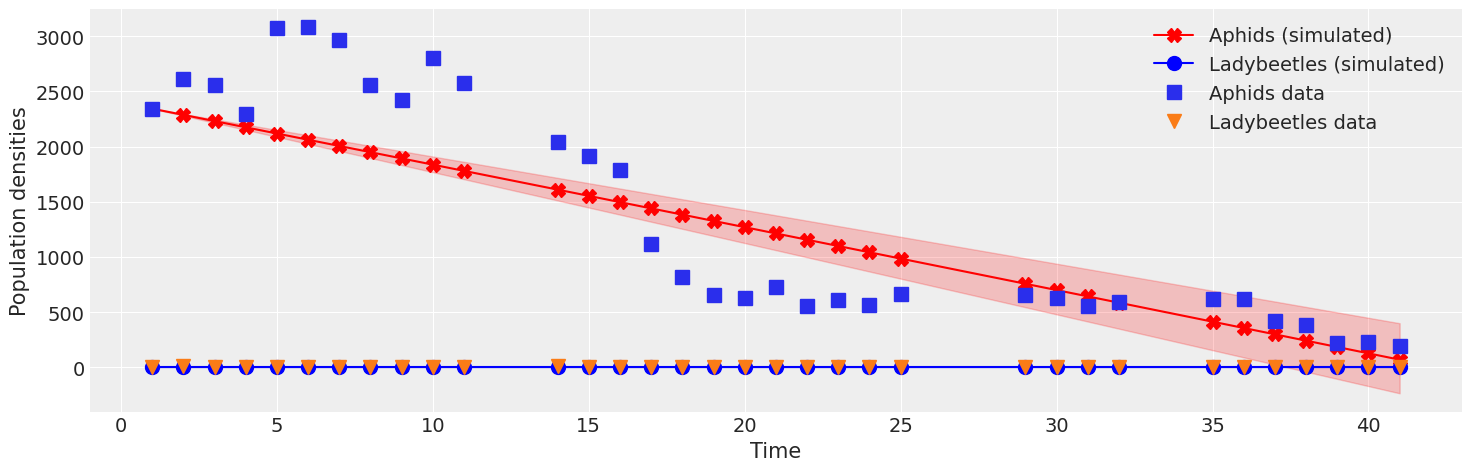

In [192]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration_EP2.png", dpi=300)
plt.show()

In [193]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_EP2.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_EP2.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering a3 realizations: 100%|██████████| 2/2 [00:00<00:00, 560.14it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.120 seconds


In [194]:
df_realizations

a1             a3
0      881994.588977  110654.725570
1      881994.588977  110654.725570
2      881994.588977  110654.725570
3      881994.588977  110654.725570
4      920295.236755  114135.683131
...              ...            ...
17995  362334.871689   46799.383200
17996  362334.871689   46799.383200
17997  362334.871689   46799.383200
17998  501408.304591   63136.577074
17999  734434.801043   85199.877223

[18000 rows x 2 columns]

# Exponential Prey Growth FR3 model

## The parameter a1 doesn't have a maximum threshold

In [195]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def EP3_model(
    t,
    X,
    r1 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    u, v = X
    u_prime = r1 * u - a1 * u * u * v / ( a2 + a3 * u * u )
    v_prime = 0
    return u_prime, v_prime

def EP3_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    solution_ODE = solve_ivp(
        fun=EP3_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,a1,a2,a3),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [196]:
def EP3_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [197]:
from scipy import optimize

seed = 1234

r1=0.001333498834664657
a1=0.029060190883154886
a2=2.774935164202579e-05
a3=0.003448649713284258
denom_min = 0.1
denom_max = 1.9
bounds_EP3 = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
    ( ( a2 * denom_min ), ( a2 * denom_max ) ),  # a2
    ( ( a3 * denom_min ), ( a3 * denom_max ) ),  # a3
]

result_EP3 = optimize.differential_evolution(
    EP3_least_squares_error_ode,
    bounds=bounds_EP3,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        EP3_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=20000, # 2000
    polish=True,
    disp=True,
    seed = seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_EP3)

differential_evolution step 1: f(x)= 4.19738e+06
parameters = [2.93311082e-04 4.52389831e-02 3.41837591e-05 5.52416836e-03]

differential_evolution step 2: f(x)= 4.19677e+06
parameters = [1.29913833e-03 5.13669567e-02 3.36101556e-05 6.08899354e-03]

differential_evolution step 3: f(x)= 4.19677e+06
parameters = [1.29913833e-03 5.13669567e-02 3.36101556e-05 6.08899354e-03]

differential_evolution step 4: f(x)= 4.19677e+06
parameters = [1.29913833e-03 5.13669567e-02 3.36101556e-05 6.08899354e-03]

differential_evolution step 5: f(x)= 4.19677e+06
parameters = [1.29913833e-03 5.13669567e-02 3.36101556e-05 6.08899354e-03]

differential_evolution step 6: f(x)= 4.19677e+06
parameters = [1.29913833e-03 5.13669567e-02 3.36101556e-05 6.08899354e-03]

differential_evolution step 7: f(x)= 4.19667e+06
parameters = [1.53646136e-03 4.78525411e-02 3.96813969e-05 5.65221464e-03]

differential_evolution step 8: f(x)= 4.19665e+06
parameters = [1.41968068e-03 4.64181885e-02 2.97442028e-05 5.49760203e-03]



* Retrieving the calibrated parameter values:

In [198]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    a1_deterministic,
    a2_deterministic,
    a3_deterministic,
) = result_EP3.x

solution_ODE_EP3 = EP3_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_EP3.x
)
t_computed_EP3, y_computed_EP3 = solution_ODE_EP3.t, solution_ODE_EP3.y
u_EP3, v_EP3 = y_computed_EP3

parameters_dict = {
    "Model": "EP3",
    u"$r1$": r1_deterministic,
    u"$a1$": a1_deterministic,
    u"$a2$": a2_deterministic,
    u"$a3$": a3_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "a1=" + str(a1_deterministic) + "\n" + "a2=" + str(a2_deterministic) + "\n" + "a3=" + str(a3_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=0.0013407000199524084
a1=0.04964354137945415
a2=4.4720115469411267e-05
a3=0.00589028647579913


#### Simulation

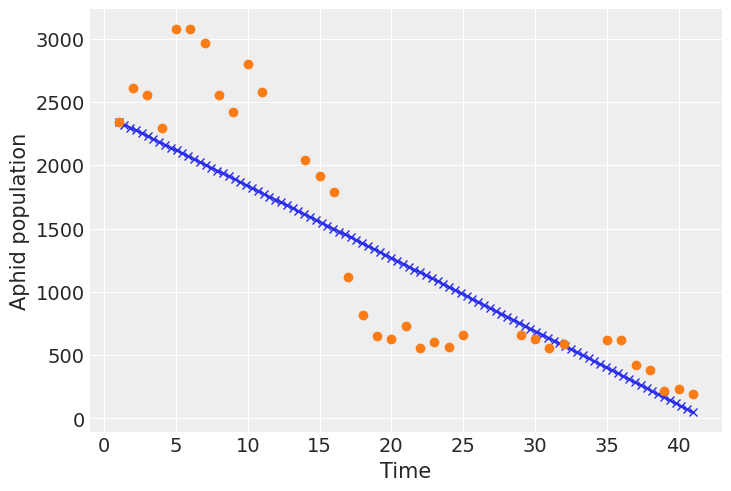

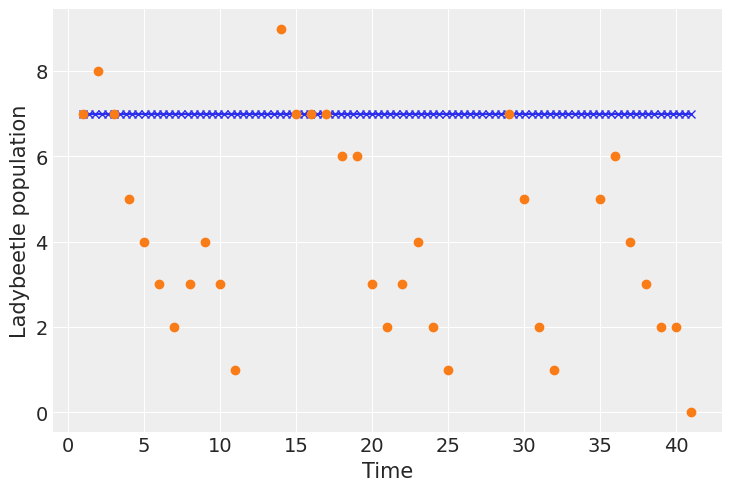

In [199]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_EP3, u_EP3, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_EP3, v_EP3, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [200]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [201]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = EP3_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        EP3_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 20/20 [00:00<00:00, 750.95it/s]


In [202]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$a3$     0.630847
$a1$     0.360517
$r1$   0.00863589
$a2$  1.03919e-08

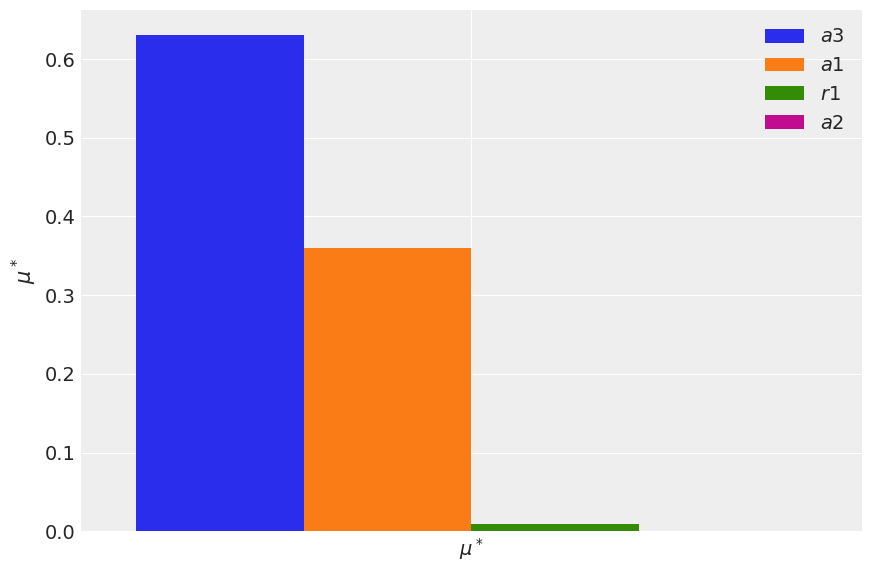

In [203]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares_EP3.png", dpi=300)
plt.show()

### Prey (pest) population

In [204]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [205]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_EP3 = EP3_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_EP3.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 20/20 [00:00<00:00, 922.64it/s]


In [206]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 159.49it/s]


Time       $r1$      $a1$         $a2$      $a3$
0    1.404040   0.023238  0.427752  9.85412e-10   0.54901
1    1.808081  0.0231604  0.427676  9.97303e-10  0.549164
2    2.212121  0.0230063  0.427829    1.008e-09  0.549165
3    2.616162  0.0229733  0.427801  1.01524e-09  0.549226
4    3.020202  0.0229018  0.427796  1.05723e-09  0.549302
..        ...        ...       ...          ...       ...
94  39.383838  0.0113071  0.430546  3.35854e-08  0.558147
95  39.787879  0.0111771  0.430577  3.39248e-08  0.558246
96  40.191919   0.011047  0.430608  3.42623e-08  0.558345
97  40.595960  0.0109169  0.430638  3.45979e-08  0.558445
98  41.000000  0.0107866  0.430669  3.49318e-08  0.558544

[99 rows x 5 columns]

In [207]:
df_sigmai

Time         $r1$      $a1$         $a2$      $a3$
0    1.404040  0.000251484  0.232322   1.8175e-09  0.767426
1    1.808081  0.000605351  0.232306  1.87702e-09  0.767088
2    2.212121  0.000374384  0.232197  1.87302e-09  0.767429
3    2.616162  0.000522528  0.232122   1.9088e-09  0.767356
4    3.020202  0.000670535  0.232034  1.97265e-09  0.767295
..        ...          ...       ...          ...       ...
94  39.383838    0.0128741   0.22304  1.45365e-07  0.764085
95  39.787879    0.0130044  0.222943  1.47026e-07  0.764053
96  40.191919    0.0131349  0.222845  1.48689e-07   0.76402
97  40.595960    0.0132654  0.222747  1.50353e-07  0.763987
98  41.000000    0.0133959  0.222649  1.52018e-07  0.763955

[99 rows x 5 columns]

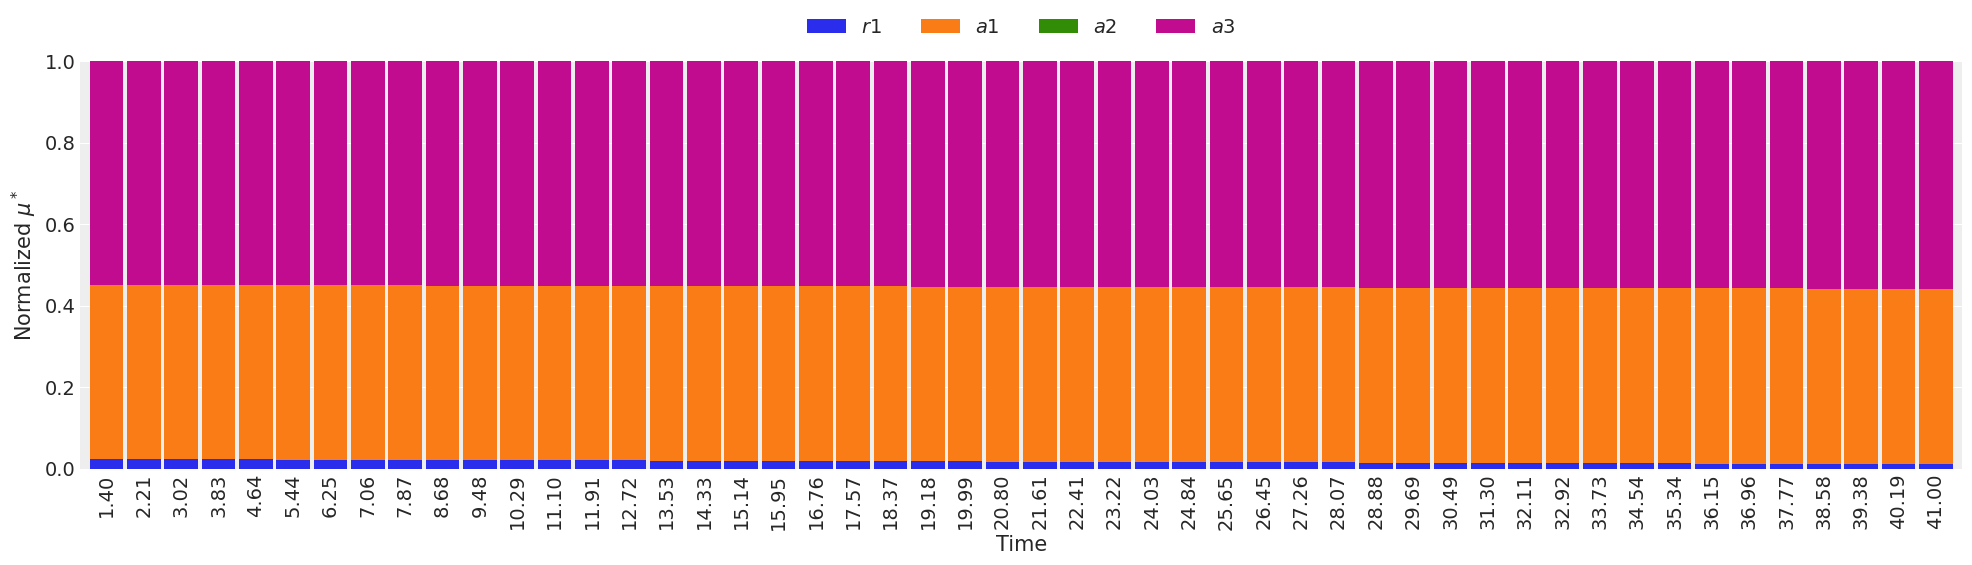

In [208]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_EP3.png", dpi=300)
plt.show()

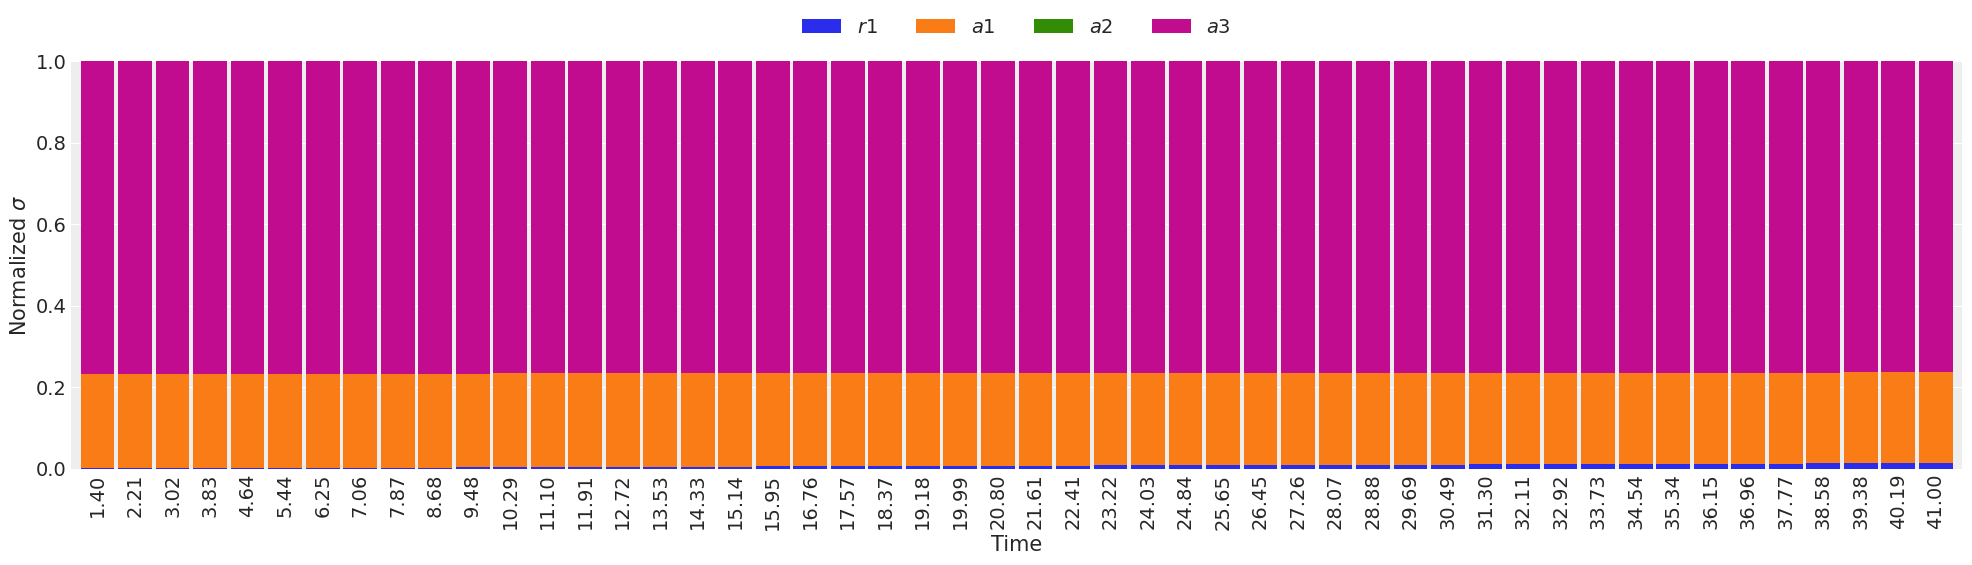

In [209]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_EP3.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [210]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [211]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_EP3,
    u_EP3,
    v_EP3,
    EP3_model,
    mean_values_params
)

pest_time_derivative_array

array([-55.86140458, -55.891536  , -55.92166742, -55.95184593,
       -55.98199704, -56.01216453, -56.04234872, -56.07254968,
       -56.1027674 , -56.1330019 , -56.16325317, -56.1935212 ,
       -56.22380601, -56.25410758, -56.28442593, -56.31476104,
       -56.34511292, -56.37548158, -56.405867  , -56.4362692 ,
       -56.46668816, -56.49712389, -56.52757639, -56.55804567,
       -56.58853171, -56.61903452, -56.6495541 , -56.68009045,
       -56.71064357, -56.74121346, -56.77180012, -56.80240355,
       -56.83302375, -56.86366072, -56.89431446, -56.92498496,
       -56.95567224, -56.98637629, -57.0170971 , -57.04783469,
       -57.07858904, -57.10936017, -57.14014806, -57.17095273,
       -57.20177416, -57.23261236, -57.26346733, -57.29433907,
       -57.32522758, -57.35613286, -57.38705491, -57.41799373,
       -57.44894932, -57.47992167, -57.5109108 , -57.54191669,
       -57.57293935, -57.60397878, -57.63503498, -57.66610795,
       -57.69719768, -57.72830419, -57.75942746, -57.79

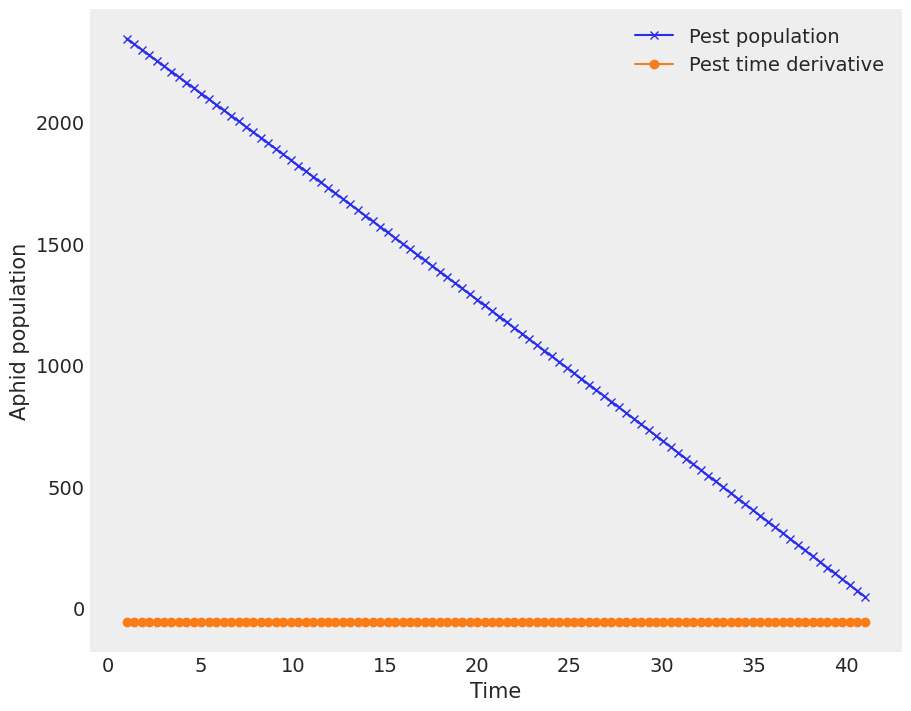

In [212]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_EP3, u_EP3, '-x', label='Pest population')
plt.plot(t_computed_EP3, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative_EP3.png", dpi=300)
plt.show()

In [213]:
mean_values_params = [
    r1,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [214]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_EP3 = EP3_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_EP3.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        EP3_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 20/20 [00:00<00:00, 356.53it/s]


In [215]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 161.42it/s]


Time        $r1$      $a1$         $a2$      $a3$
0    1.404040   0.0235088  0.427567  9.62948e-10  0.548924
1    1.808081   0.0232555  0.427628  9.88179e-10  0.549116
2    2.212121    0.023002  0.427689   1.0145e-09  0.549309
3    2.616162   0.0227488   0.42775  1.04199e-09  0.549501
4    3.020202   0.0224954  0.427811  1.07081e-09  0.549694
..        ...         ...       ...          ...       ...
94  39.383838  0.00668829   0.43014  9.61989e-07  0.563171
95  39.787879  0.00675621  0.430058   3.2291e-07  0.563185
96  40.191919  0.00682401  0.429978  1.61885e-07  0.563198
97  40.595960  0.00689173  0.429897  9.82937e-08  0.563211
98  41.000000  0.00695939  0.429816  6.69222e-08  0.563224

[99 rows x 5 columns]

In [216]:
df_sigmai

Time         $r1$      $a1$         $a2$      $a3$
0    1.404040  0.000275671   0.23241  1.77866e-09  0.767314
1    1.808081  0.000551479  0.232206  1.85284e-09  0.767243
2    2.212121   0.00082563  0.232003  1.93099e-09  0.767172
3    2.616162   0.00110041  0.231799  2.01371e-09    0.7671
4    3.020202   0.00137488  0.231596   2.1014e-09  0.767029
..        ...          ...       ...          ...       ...
94  39.383838    0.0247949  0.214131  4.88253e-06  0.761069
95  39.787879    0.0250417   0.21394  1.61943e-06  0.761016
96  40.191919    0.0252879  0.213754  7.96866e-07  0.760957
97  40.595960    0.0255338  0.213569  4.71578e-07  0.760897
98  41.000000    0.0257794  0.213384  3.10647e-07  0.760837

[99 rows x 5 columns]

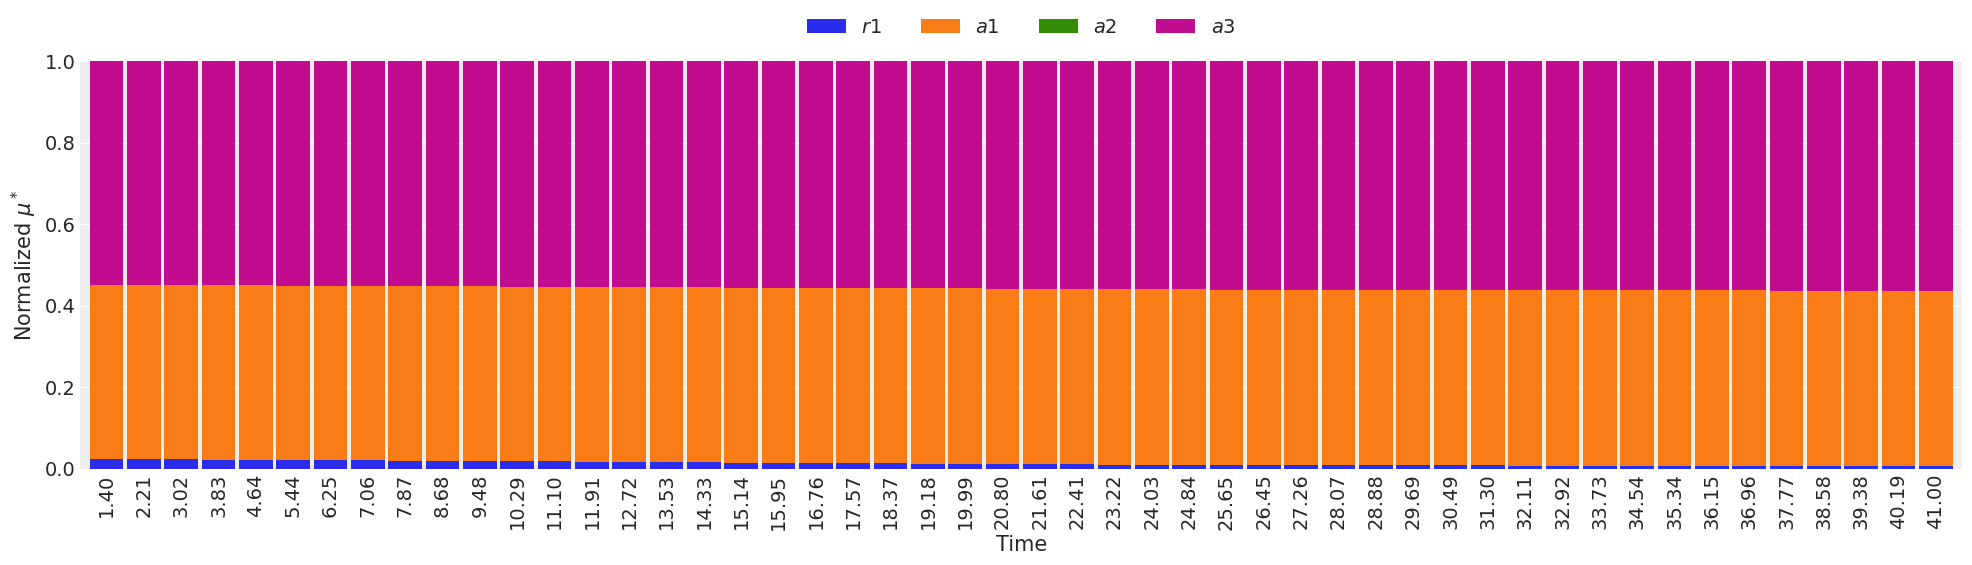

In [217]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_EP3.png", dpi=300)
plt.show()

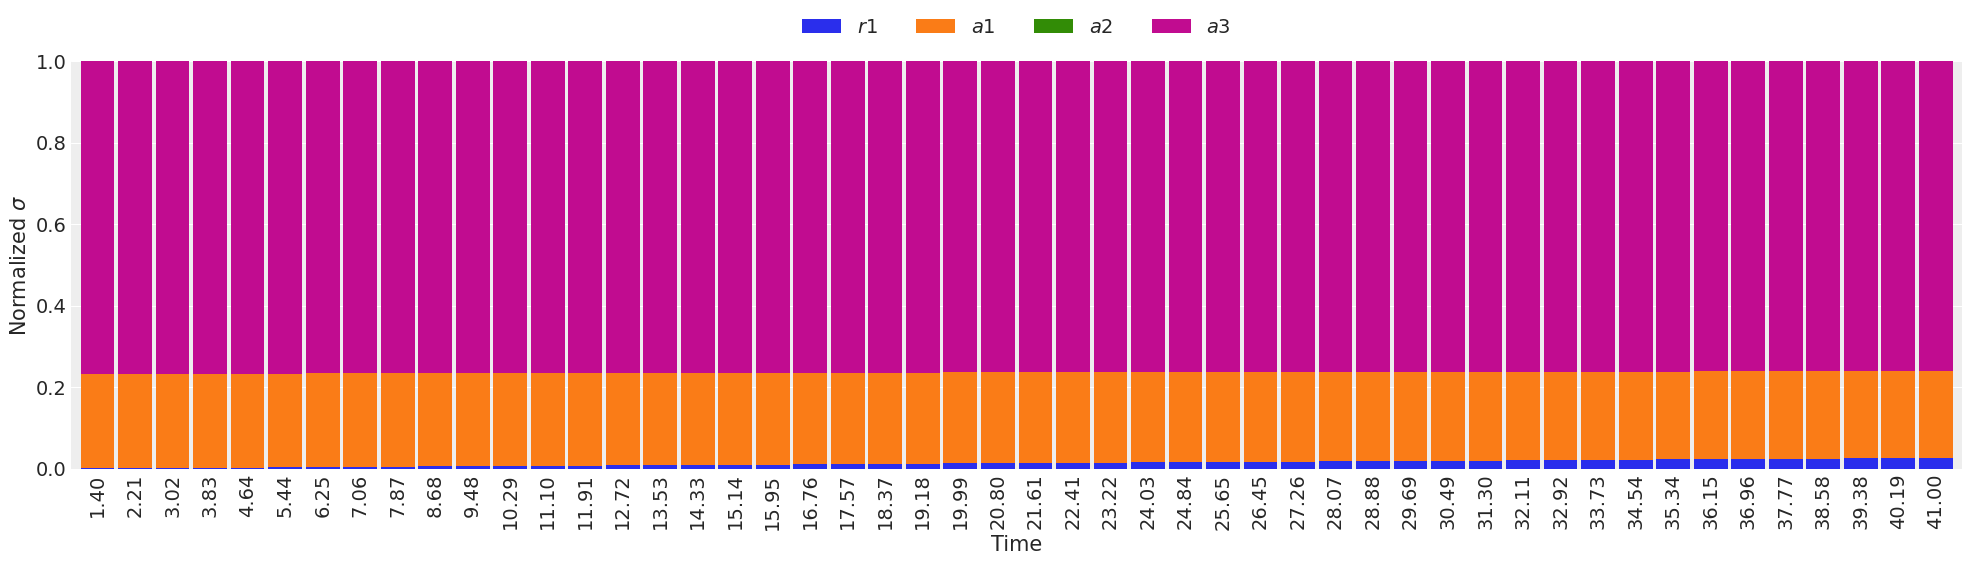

In [218]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_EP3.png", dpi=300)
plt.show()

## Bayesian calibration

In [219]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # a1
        t.dscalar,  # a2
        t.dscalar,  # a3
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def EP3_ode_wrapper(time_exp, r1, a1, a2, a3, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, a1, a2, a3]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        EP3_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [220]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_EP3:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + 10 * percent_calibration) * a1,
    )
    a2_ = pm.Data("a2", a2)
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 + 10 * percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "EP3_model",
        EP3_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + 10 * percent_calibration) * a1,
    )
    a2_ = pm.Data("a2", a2)
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 + 10 * percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "EP3_model",
        EP3_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + 10 * percent_calibration) * a1,
    )
    a2_ = pm.Data("a2", a2)
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 + 10 * percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "EP3_model",
        EP3_ode_wrapper(
            time_calibration,
            r1_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_EP3:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_EP3 = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (4 chains in 4 jobs)
MLDA: [std_deviation, a3, a1]


Sampling 4 chains for 1_000 tune and 4_500 draw iterations (4_000 + 18_000 draws total) took 202 seconds.
The number of effective samples is smaller than 10% for some parameters.


-- Monte Carlo simulations done in 3.747 minutes


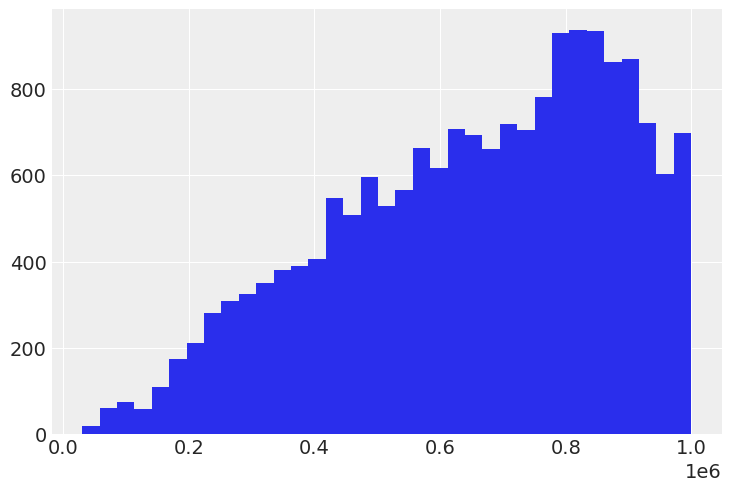

In [221]:
plt.hist(trace_calibration_EP3['a1'], bins=35)
plt.show()

In [222]:
calibration_variable_names = [
    "std_deviation",
    "a1",
    "a3",
]

100%|██████████| 3/3 [00:52<00:00, 17.47s/it]


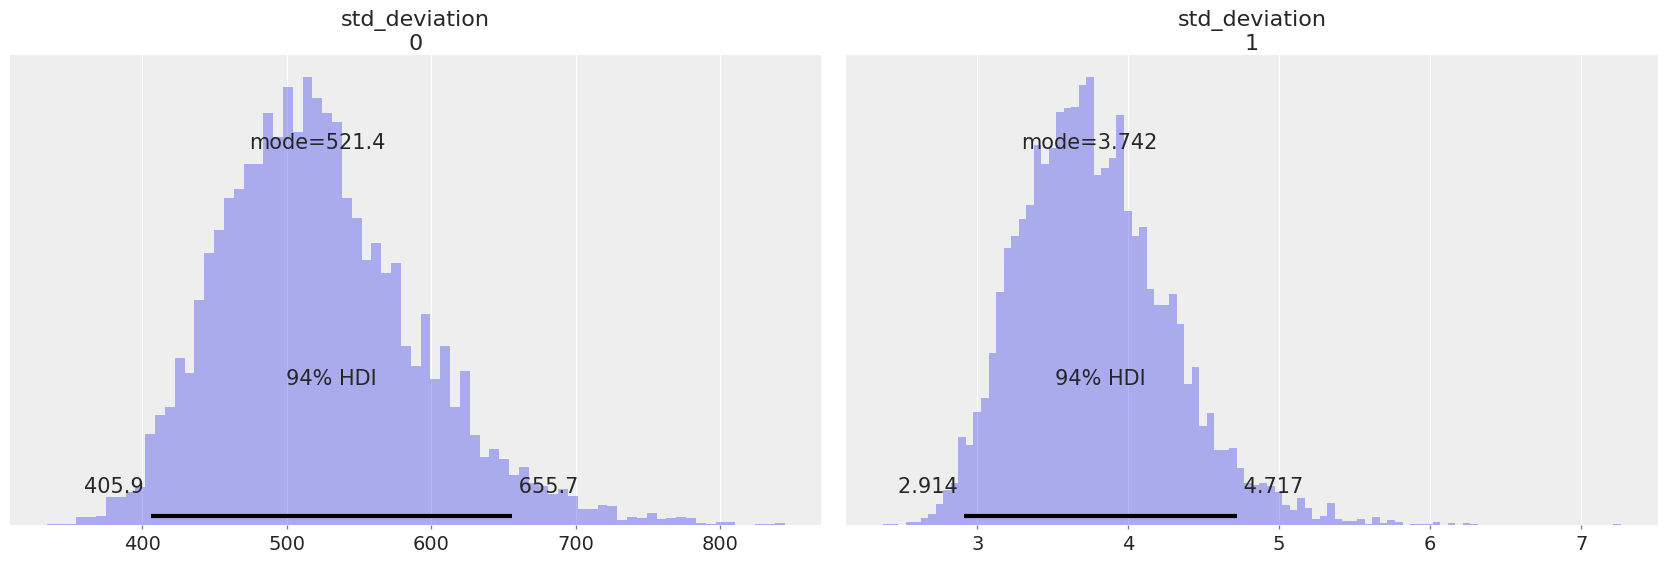

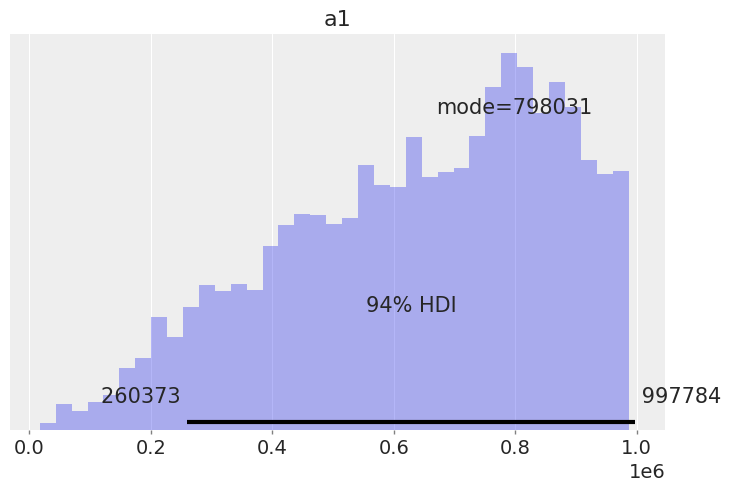

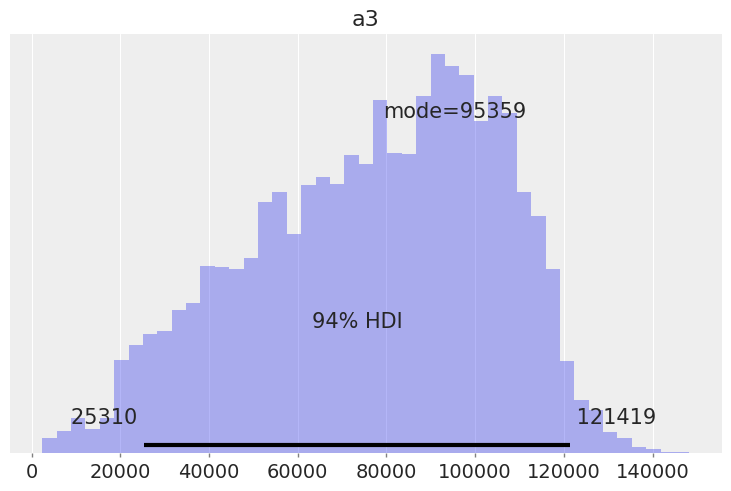

In [223]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_EP3[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal_EP3.png")

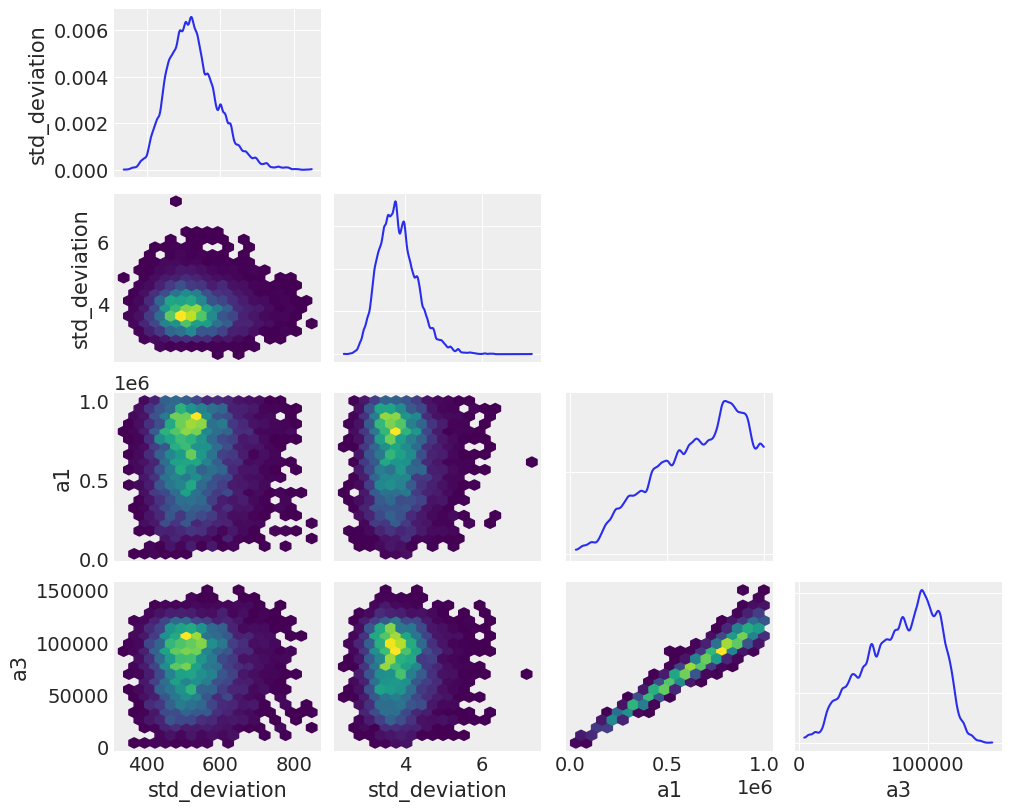

In [224]:
az.plot_pair(
    trace_calibration_EP3,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_EP3.png")

In [225]:
df_stats_summary = az.summary(
    data=trace_calibration_EP3,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

mean             sd         hdi_3%        hdi_97%
std_deviation[0]     526.339560      68.635788     405.871465     655.723730
std_deviation[1]       3.805110       0.497220       2.914429       4.716830
a1                652759.664316  224426.399288  260372.693430  997783.568352
a3                 78519.092635   27619.286119   25310.285955  121419.295967

Auxiliary functions to compute the Most Probable Value (MPV):

In [226]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [227]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_EP3, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_EP3.csv")  # salvando em um csv para consultas

df_stats_summary

Calculating MPV from KDE for a3: 100%|██████████| 3/3 [00:24<00:00,  8.14s/it]           


mean             sd         hdi_3%        hdi_97%  \
std_deviation[0]     526.339560      68.635788     405.871465     655.723730   
std_deviation[1]       3.805110       0.497220       2.914429       4.716830   
a1                652759.664316  224426.399288  260372.693430  997783.568352   
a3                 78519.092635   27619.286119   25310.285955  121419.295967   

                            mpv  
std_deviation[0]     516.838866  
std_deviation[1]       3.708905  
a1                819457.634846  
a3                 96032.136628

In [228]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_EP3["EP3_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_EP3["EP3_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_EP3["EP3_model"], 50, axis=0)

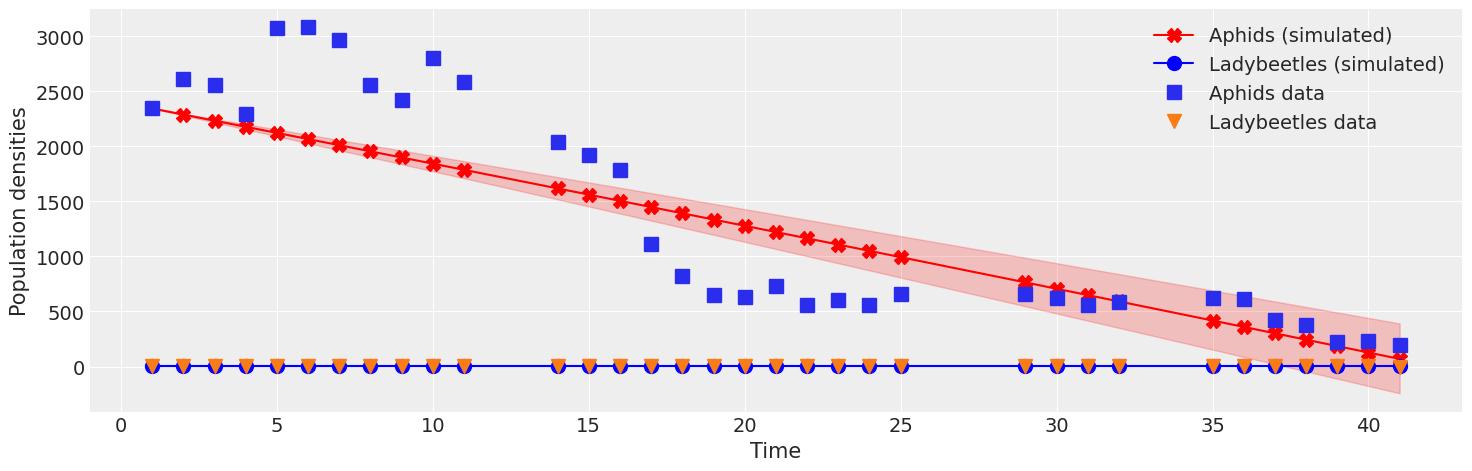

In [229]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration_EP3.png", dpi=300)
plt.show()

In [230]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_EP3.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_EP3.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering a3 realizations: 100%|██████████| 2/2 [00:00<00:00, 350.66it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.116 seconds


In [231]:
df_realizations

a1            a3
0      420400.590253  45962.631069
1      420400.590253  45962.631069
2      420400.590253  45962.631069
3      420400.590253  45962.631069
4      420400.590253  45962.631069
...              ...           ...
17995  594278.770856  75331.895049
17996  594278.770856  75331.895049
17997  497290.137150  60889.051680
17998  619888.886518  72184.264727
17999  537427.376518  68196.200555

[18000 rows x 2 columns]

# Logistic Prey Growth FR1 model

In [232]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def LP1_model(
    t,
    X,
    r1 = 1,
    r2 = 2,
    a1 = 1,
):
    u, v = X
    u_prime = r1 * u - r2 * u * u - a1 * u * v 
    v_prime = 0
    return u_prime, v_prime

def LP1_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 1,
    r2 = 2,
    a1 = 1,
):
    solution_ODE = solve_ivp(
        fun=LP1_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,r2,a1),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [233]:
def LP1_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [234]:
from scipy import optimize

seed = 1234

r1=0.0025591841125063588
r2=4.3094146773353513e-11
a1=0.005814656330586127
denom_min = 0.1
denom_max = 1.9
bounds_LP1 = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),  # r2
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
]

result_LP1 = optimize.differential_evolution(
    LP1_least_squares_error_ode,
    bounds=bounds_LP1,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        LP1_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=20000, # 2000
    polish=True,
    disp=True,
    seed = seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_LP1)

differential_evolution step 1: f(x)= 5.08532e+06
parameters = [1.34079111e-03 2.85712760e-11 5.71848973e-03]

differential_evolution step 2: f(x)= 5.08532e+06
parameters = [1.34079111e-03 2.85712760e-11 5.71848973e-03]

differential_evolution step 3: f(x)= 5.08465e+06
parameters = [1.56913728e-03 5.38408876e-11 5.65639673e-03]

differential_evolution step 4: f(x)= 5.08464e+06
parameters = [8.41787548e-04 4.34390591e-11 5.58561868e-03]

differential_evolution step 5: f(x)= 5.08463e+06
parameters = [7.47083612e-04 1.95151227e-11 5.54129103e-03]

differential_evolution step 6: f(x)= 5.08456e+06
parameters = [6.65041230e-04 2.85712760e-11 5.54875339e-03]

differential_evolution step 7: f(x)= 5.08456e+06
parameters = [9.03047866e-04 2.50496413e-11 5.57718187e-03]

differential_evolution step 8: f(x)= 5.08456e+06
parameters = [9.03047866e-04 2.50496413e-11 5.57718187e-03]

differential_evolution step 9: f(x)= 5.08456e+06
parameters = [9.03047866e-04 2.50496413e-11 5.57718187e-03]

differenti

* Retrieving the calibrated parameter values:

In [235]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    r2_deterministic,
    a1_deterministic,
) = result_LP1.x

solution_ODE_LP1 = LP1_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_LP1.x
)
t_computed_LP1, y_computed_LP1 = solution_ODE_LP1.t, solution_ODE_LP1.y
u_LP1, v_LP1 = y_computed_LP1

parameters_dict = {
    "Model": "LP1",
    u"$r1$": r1_deterministic,
    u"$r2$": r2_deterministic,
    u"$a1$": a1_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "r2=" + str(r2_deterministic) + "\n" + "a1=" + str(a1_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=0.0017306403790649382
r2=4.309414677335351e-12
a1=0.005696301937221108


#### Simulation

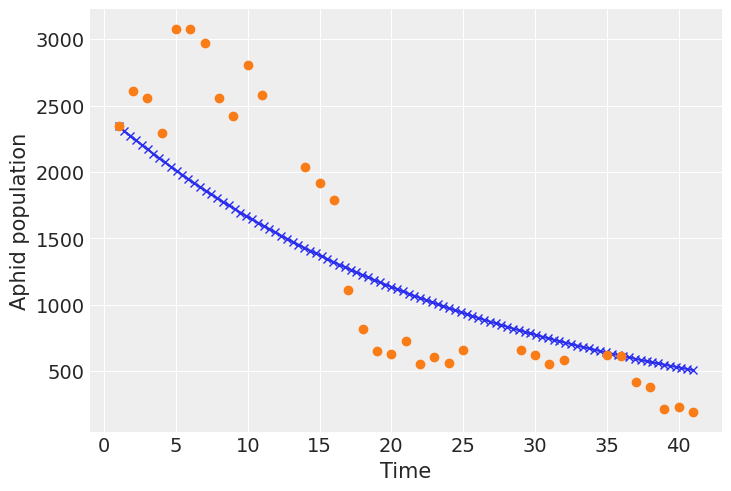

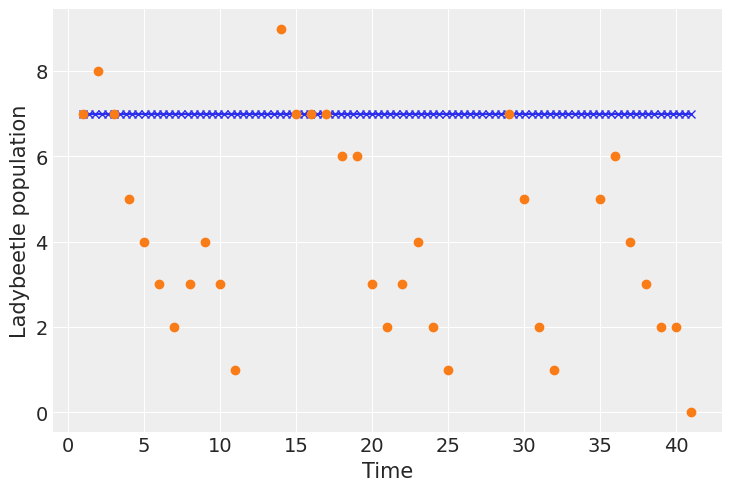

In [236]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_LP1, u_LP1, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_LP1, v_LP1, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [237]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    a1,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$a1$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [238]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = LP1_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        LP1_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 16/16 [00:00<00:00, 531.84it/s]


In [239]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$a1$     0.902751
$r1$    0.0972468
$r2$  1.83034e-06

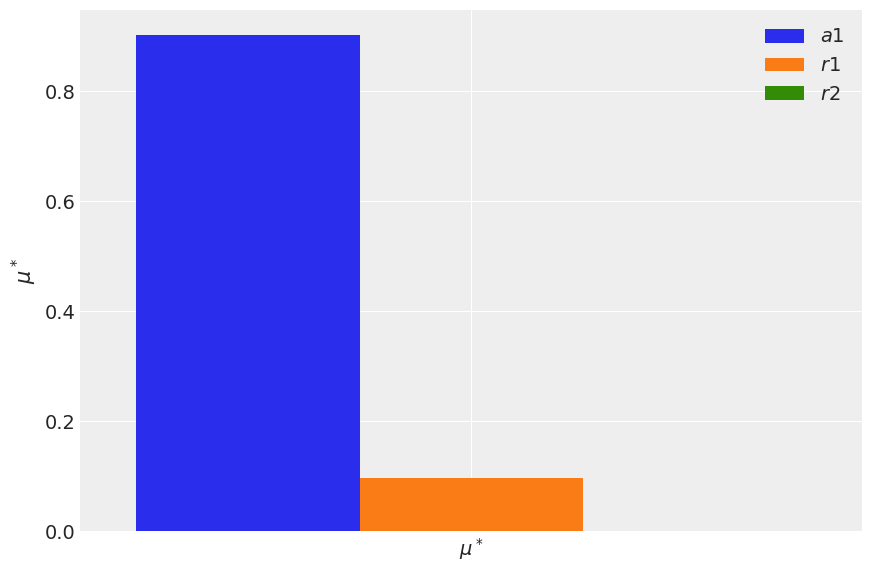

In [240]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares_LP1.png", dpi=300)
plt.show()

### Prey (pest) population

In [241]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    a1,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$a1$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [242]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_LP1 = LP1_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_LP1.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 16/16 [00:00<00:00, 776.86it/s]


In [243]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 192.31it/s]


Time       $r1$         $r2$      $a1$
0    1.404040  0.0592244  2.27879e-06  0.940773
1    1.808081  0.0599116  2.28104e-06  0.940086
2    2.212121  0.0590914  2.24246e-06  0.940906
3    2.616162  0.0591078  2.22905e-06   0.94089
4    3.020202  0.0591079  2.21337e-06   0.94089
..        ...        ...          ...       ...
94  39.383838  0.0636579  1.22765e-06  0.936341
95  39.787879  0.0637519  1.22207e-06  0.936247
96  40.191919  0.0638481  1.21667e-06  0.936151
97  40.595960   0.063947  1.21149e-06  0.936052
98  41.000000  0.0640488  1.20655e-06   0.93595

[99 rows x 4 columns]

In [244]:
df_sigmai

Time      $r1$         $r2$      $a1$
0    1.404040  0.300298  3.89958e-05  0.699663
1    1.808081  0.118004  8.54391e-06  0.881988
2    2.212121  0.121308   6.8213e-06  0.878685
3    2.616162  0.122696  6.40091e-06  0.877298
4    3.020202  0.122801  6.20183e-06  0.877193
..        ...       ...          ...       ...
94  39.383838   0.13093   3.7465e-06  0.869066
95  39.787879  0.131073  3.73465e-06  0.868923
96  40.191919   0.13122    3.723e-06  0.868777
97  40.595960  0.131369  3.71145e-06  0.868627
98  41.000000  0.131519   3.6999e-06  0.868477

[99 rows x 4 columns]

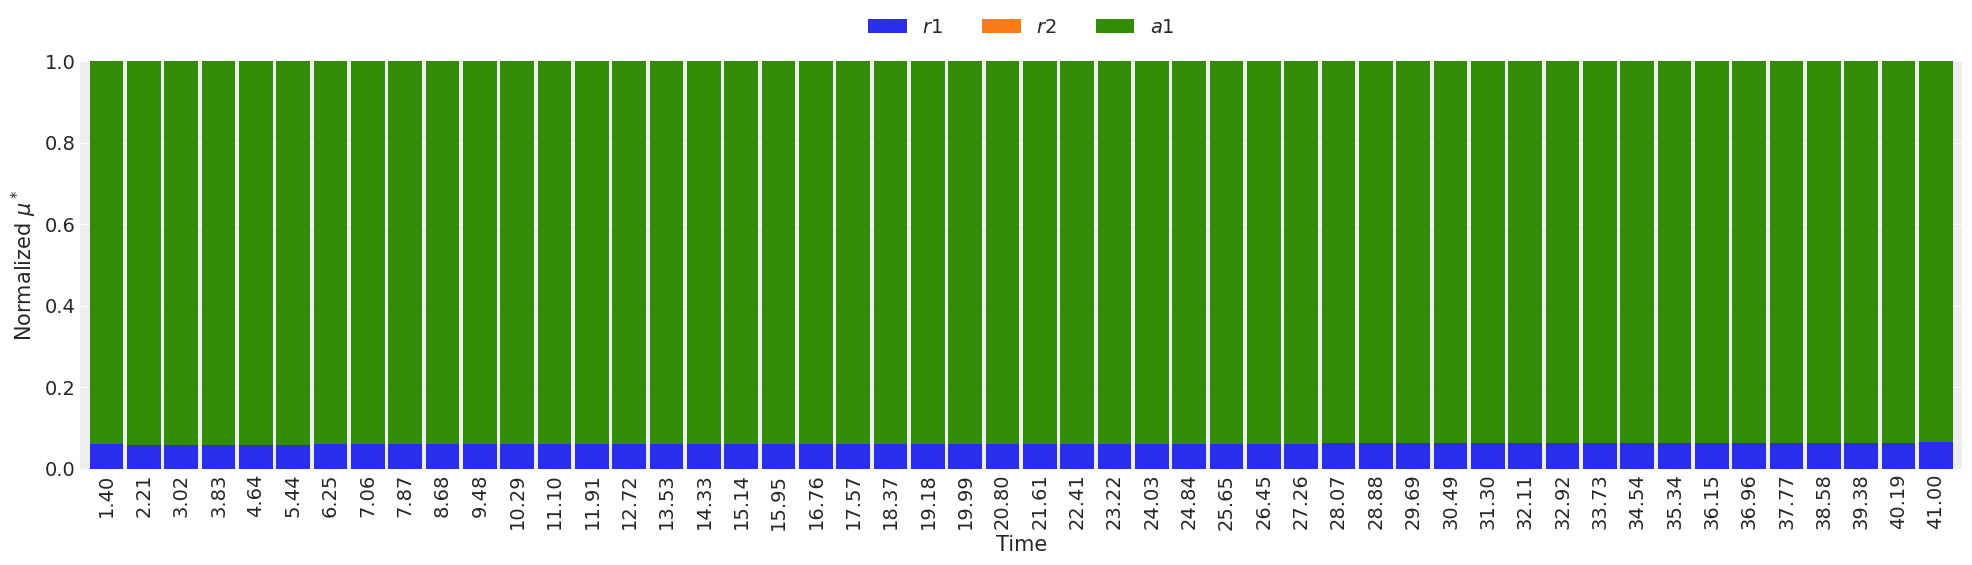

In [245]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_LP1.png", dpi=300)
plt.show()

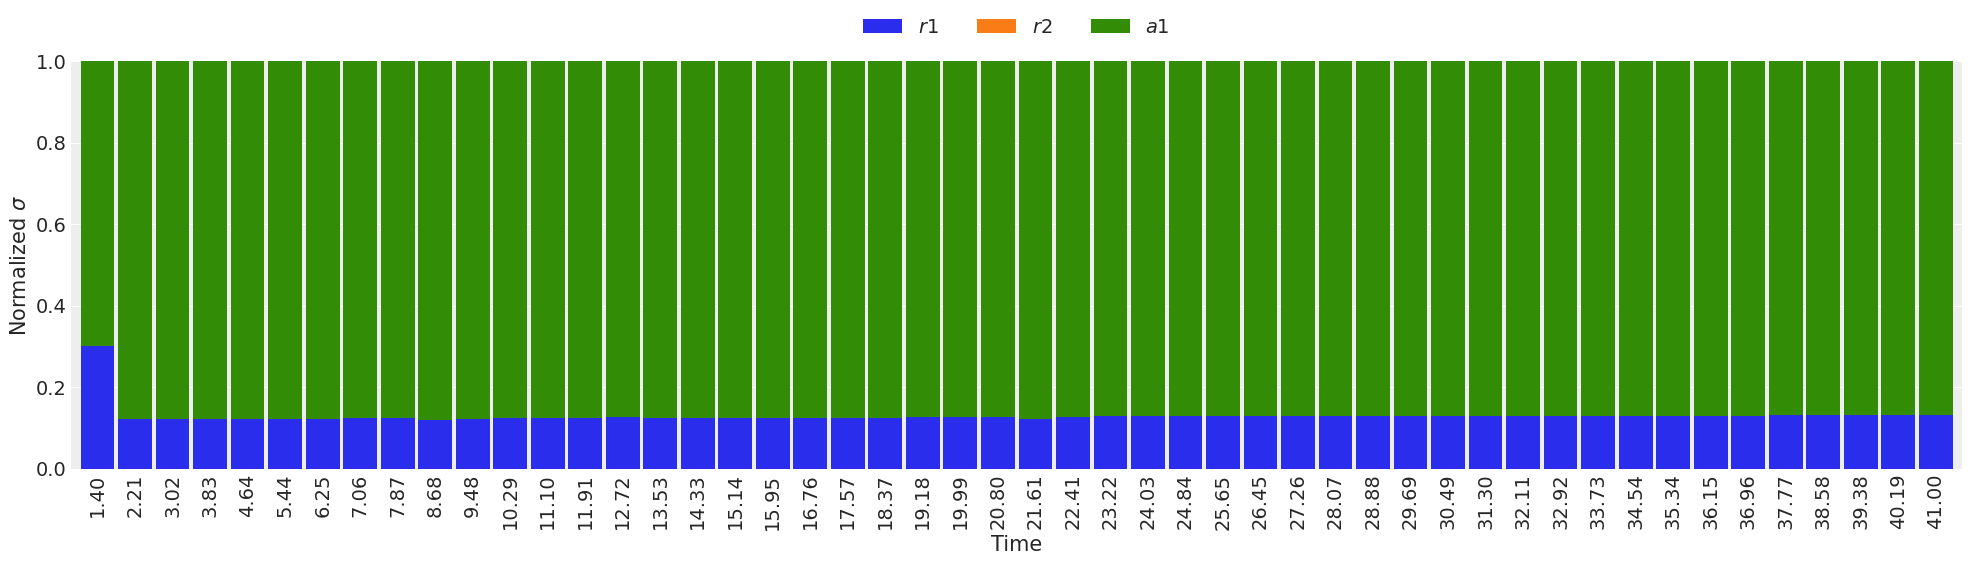

In [246]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_LP1.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [247]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [248]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_LP1,
    u_LP1,
    v_LP1,
    LP1_model,
    mean_values_params
)

pest_time_derivative_array

array([-89.37024667, -88.02862984, -86.71784764, -85.3917652 ,
       -84.0855969 , -82.79819356, -81.5293945 , -80.27919973,
       -79.04760923, -77.834623  , -76.64024105, -75.46446336,
       -74.30728993, -73.16872076, -72.04875584, -70.94662406,
       -69.86033361, -68.78978297, -67.73497214, -66.6959011 ,
       -65.67256986, -64.66497842, -63.67312677, -62.69701491,
       -61.73664284, -60.79201055, -59.89829661, -58.971759  ,
       -58.06052795, -57.16437839, -56.28308526, -55.41642351,
       -54.56416806, -53.72609386, -52.90197584, -52.09158894,
       -51.29470585, -50.51089233, -49.73976036, -48.98104768,
       -48.23449204, -47.49983119, -46.77680286, -46.0651448 ,
       -45.36459475, -44.67489047, -43.99576968, -43.32697015,
       -42.6682296 , -42.0192858 , -41.37987647, -40.74973937,
       -40.12861224, -39.51623282, -38.91236408, -38.31749069,
       -37.73178539, -37.15510465, -36.58730497, -36.02824282,
       -35.47777468, -34.93575704, -34.40204637, -33.87

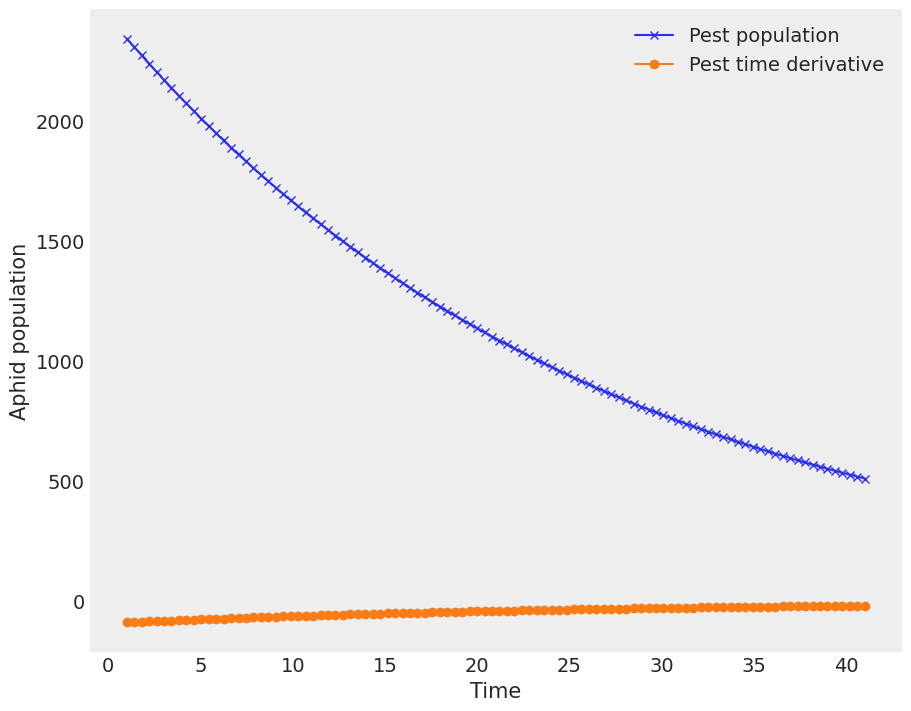

In [249]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_LP1, u_LP1, '-x', label='Pest population')
plt.plot(t_computed_LP1, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative_LP1.png", dpi=300)
plt.show()

In [250]:
mean_values_params = [
    r1,
    r2,
    a1,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$a1$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [251]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_LP1 = LP1_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_LP1.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        LP1_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 16/16 [00:00<00:00, 332.44it/s]


In [252]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 194.82it/s]


Time       $r1$         $r2$      $a1$
0    1.404040  0.0591402  2.29045e-06  0.940858
1    1.808081  0.0591111  2.24716e-06  0.940887
2    2.212121  0.0591221  2.20406e-06  0.940876
3    2.616162  0.0591194  2.16074e-06  0.940878
4    3.020202  0.0591212  2.11779e-06  0.940877
..        ...        ...          ...       ...
94  39.383838   0.219295  5.47892e-06  0.780699
95  39.787879   0.202479  5.04451e-06  0.797516
96  40.191919   0.187982   4.6705e-06  0.812013
97  40.595960   0.175353  4.34544e-06  0.824643
98  41.000000   0.164248  4.06075e-06  0.835748

[99 rows x 4 columns]

In [253]:
df_sigmai

Time      $r1$         $r2$      $a1$
0    1.404040  0.122225  6.14022e-06  0.877769
1    1.808081   0.12077  5.98305e-06  0.879224
2    2.212121  0.122339  6.01249e-06  0.877655
3    2.616162  0.122434  5.95418e-06   0.87756
4    3.020202  0.122526  5.89359e-06  0.877468
..        ...       ...          ...       ...
94  39.383838  0.151731  2.46296e-06  0.848267
95  39.787879  0.152549  2.43457e-06  0.847449
96  40.191919  0.153391   2.4064e-06  0.846607
97  40.595960  0.154263  2.37861e-06  0.845735
98  41.000000   0.15517  2.35138e-06  0.844828

[99 rows x 4 columns]

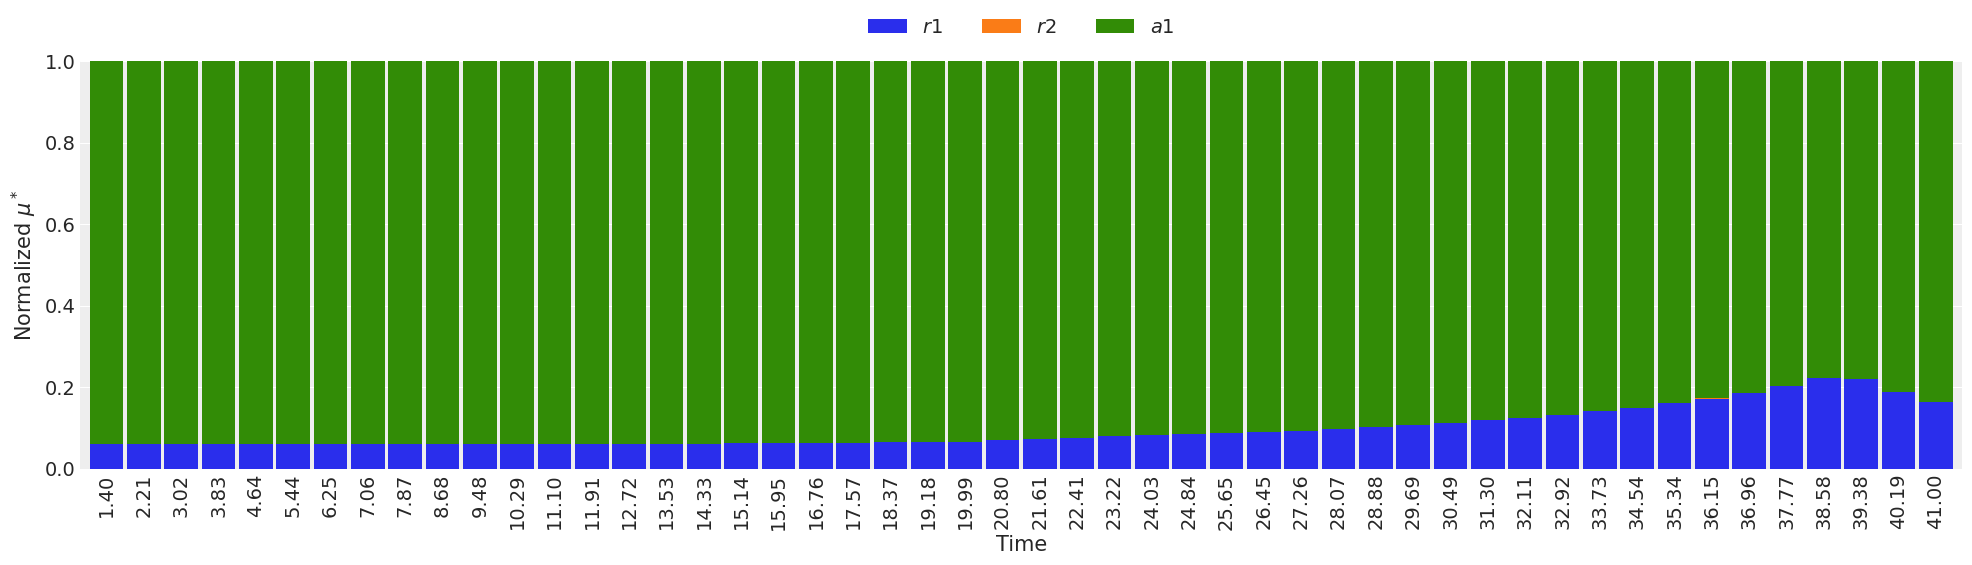

In [254]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_LP1.png", dpi=300)
plt.show()

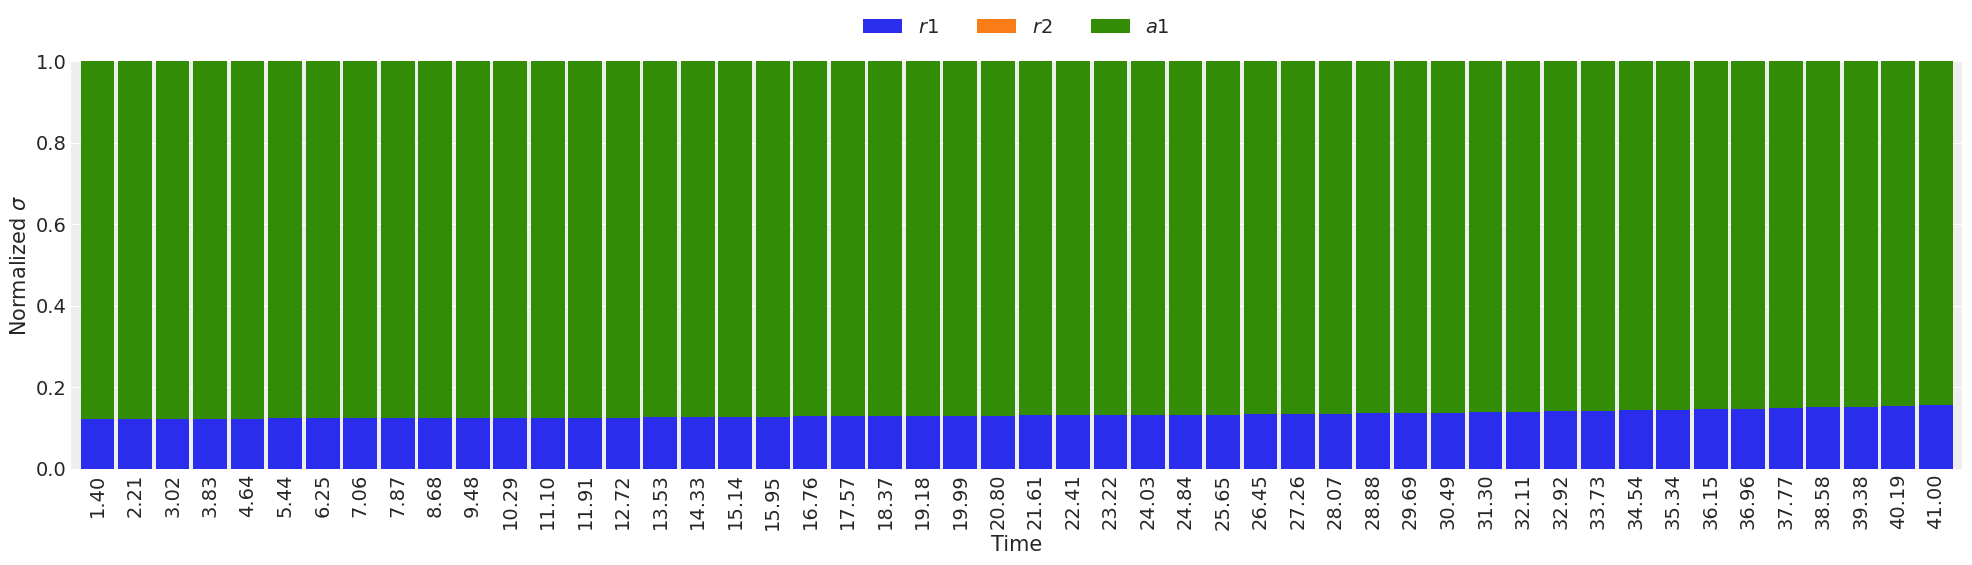

In [255]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_LP1.png", dpi=300)
plt.show()

## Bayesian calibration

In [256]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1
        t.dscalar,  # r2
        t.dscalar,  # a1
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def LP1_ode_wrapper(time_exp, r1, r2, a1, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, r2, a1]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        LP1_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [257]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_LP1:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1",
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
#    r2_ = pm.Uniform(
#        "r2",
#        lower=(1.0 - percent_calibration) * r2,
#        upper=(1.0 + percent_calibration) * r2,
#    )
    r2_ = pm.Data("r2", r2)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "LP1_model",
        LP1_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            a1_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1",
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
#    r2_ = pm.Uniform(
#        "r2",
#        lower=(1.0 - percent_calibration) * r2,
#        upper=(1.0 + percent_calibration) * r2,
#    )
    r2_ = pm.Data("r2", r2)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "LP1_model",
        LP1_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            a1_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1",
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
#    r2_ = pm.Uniform(
#        "r2",
#        lower=(1.0 - percent_calibration) * r2,
#        upper=(1.0 + percent_calibration) * r2,
#    )
    r2_ = pm.Data("r2", r2)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "LP1_model",
        LP1_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            a1_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_LP1:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_LP1 = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (4 chains in 4 jobs)
MLDA: [std_deviation, a1]


Sampling 4 chains for 1_000 tune and 4_500 draw iterations (4_000 + 18_000 draws total) took 418 seconds.
The number of effective samples is smaller than 10% for some parameters.


-- Monte Carlo simulations done in 7.469 minutes


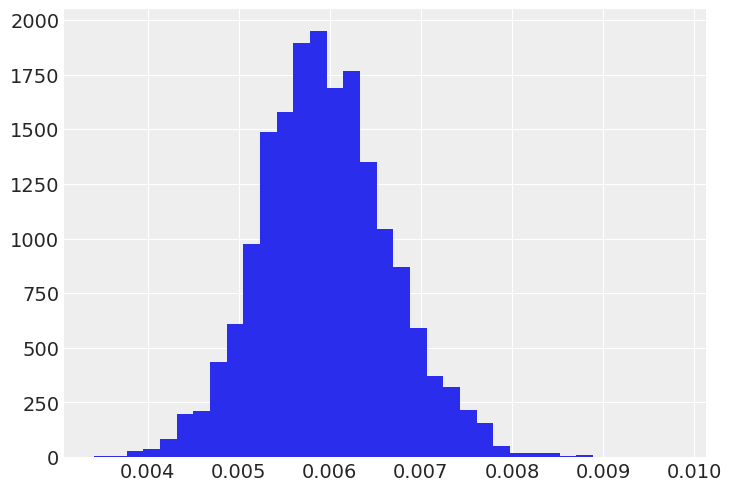

In [258]:
plt.hist(trace_calibration_LP1['a1'], bins=35)
plt.show()

In [259]:
calibration_variable_names = [
    "std_deviation",
    "a1",
]

100%|██████████| 2/2 [00:54<00:00, 27.28s/it]


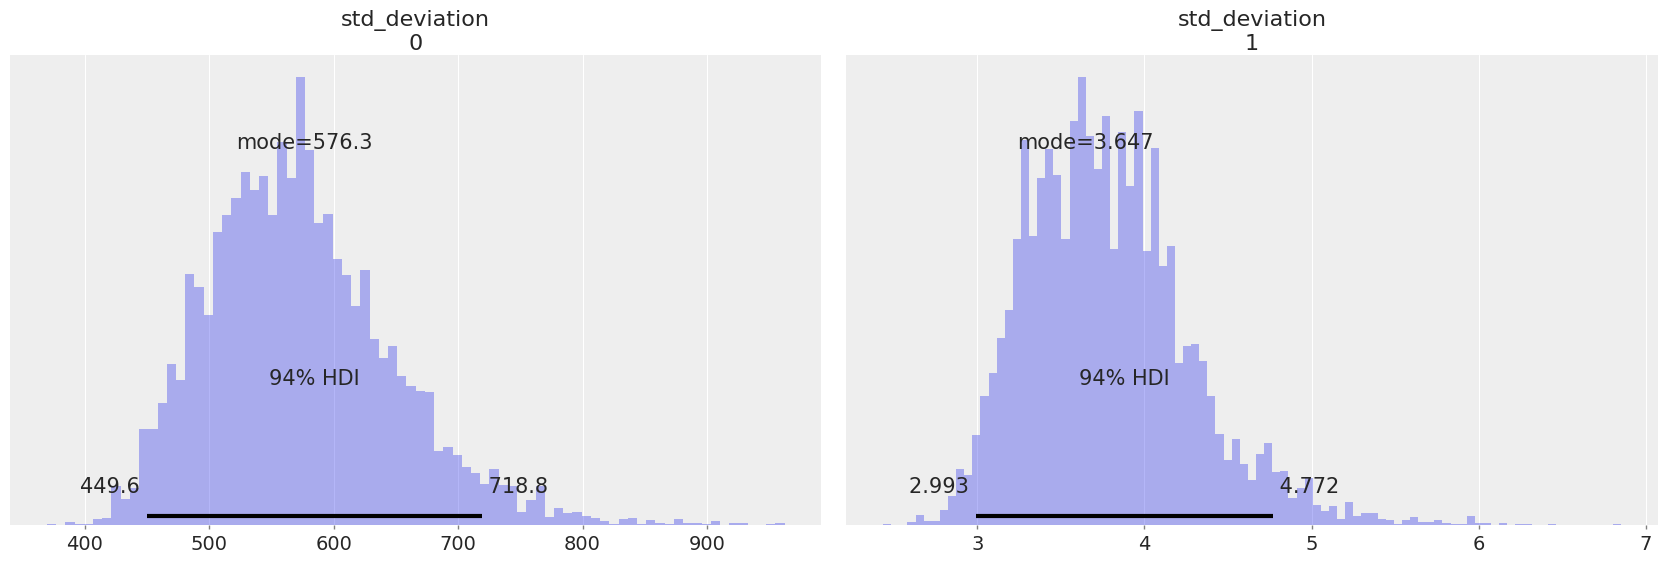

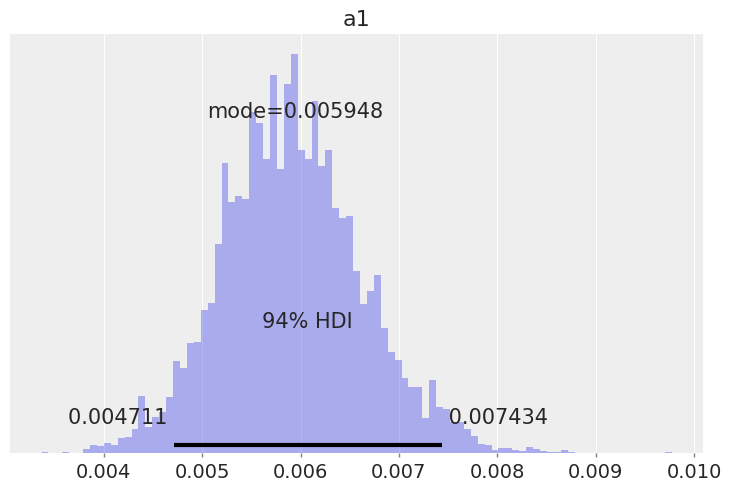

In [260]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_LP1[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal_LP1.png")

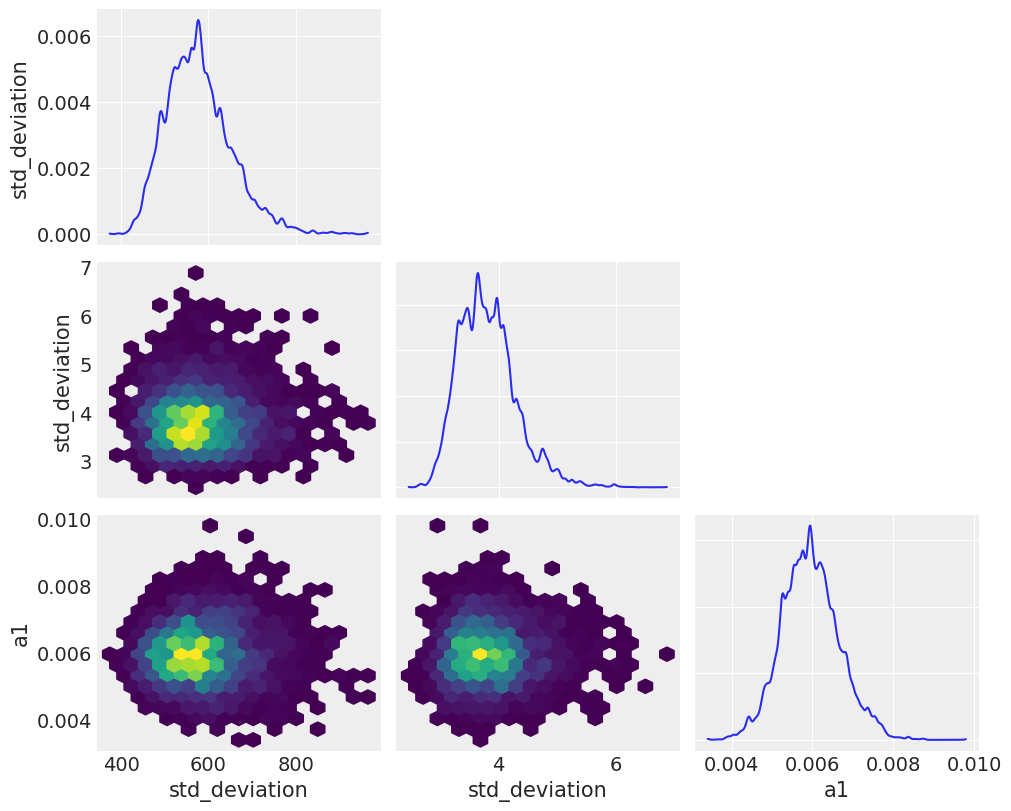

In [261]:
az.plot_pair(
    trace_calibration_LP1,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_LP1.png")

In [262]:
df_stats_summary = az.summary(
    data=trace_calibration_LP1,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

mean         sd      hdi_3%     hdi_97%
std_deviation[0]  577.294008  75.024146  449.616805  718.830776
std_deviation[1]    3.810130   0.491738    2.992760    4.771974
a1                  0.005955   0.000714    0.004711    0.007434

Auxiliary functions to compute the Most Probable Value (MPV):

In [263]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [264]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_LP1, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_LP1.csv")  # salvando em um csv para consultas

df_stats_summary

Calculating MPV from KDE for a1: 100%|██████████| 2/2 [00:24<00:00, 12.19s/it]           


mean         sd      hdi_3%     hdi_97%         mpv
std_deviation[0]  577.294008  75.024146  449.616805  718.830776  573.678913
std_deviation[1]    3.810130   0.491738    2.992760    4.771974    3.661963
a1                  0.005955   0.000714    0.004711    0.007434    0.005925

In [265]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_LP1["LP1_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_LP1["LP1_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_LP1["LP1_model"], 50, axis=0)

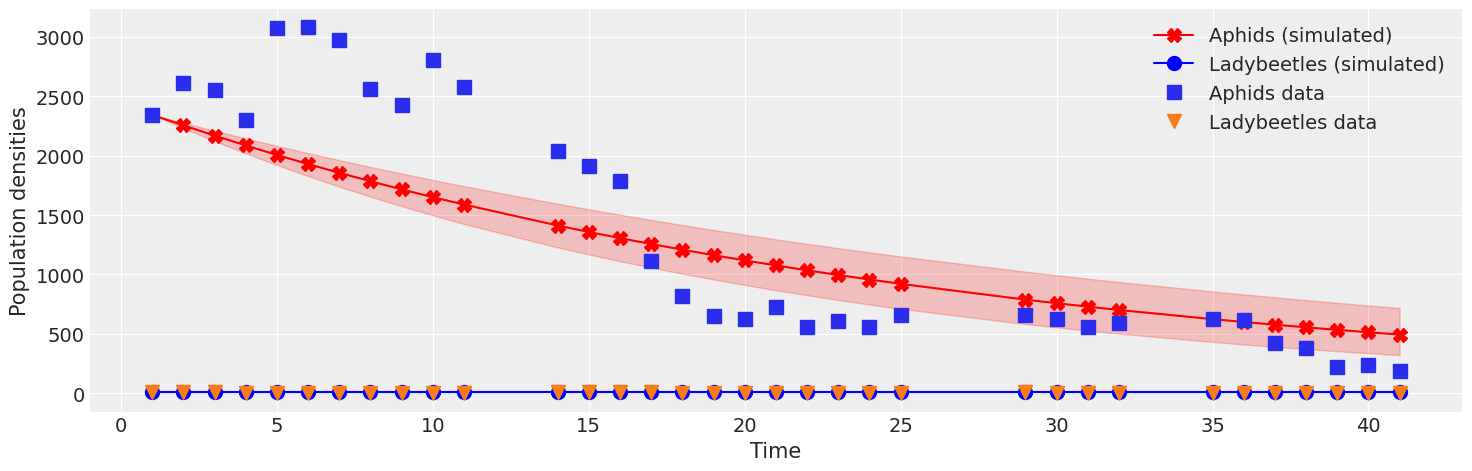

In [266]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration_LP1.png", dpi=300)
plt.show()

In [267]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_LP1.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_LP1.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering a1 realizations: 100%|██████████| 1/1 [00:00<00:00, 451.97it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.084 seconds


In [268]:
df_realizations

a1
0      0.005858
1      0.005857
2      0.005857
3      0.006449
4      0.006449
...         ...
17995  0.007628
17996  0.007129
17997  0.007129
17998  0.007129
17999  0.007198

[18000 rows x 1 columns]

# Logistic Prey Growth FR2 model

In [410]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def LP2_model(
    t,
    X,
    r1 = 1,
    r2 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    u, v = X
    u_prime = r1 * u - r2 * u * u - a1 * u * v / ( a2 + a3 * u )
    v_prime = 0
    return u_prime, v_prime

def LP2_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 1,
    r2 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    solution_ODE = solve_ivp(
        fun=LP2_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,r2,a1,a2,a3),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [411]:
def LP2_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [412]:
from scipy import optimize

seed = 1234

r1=0.10437445097500309
r2=5.107493312221164e-07
a1=0.01929726300101605
a2=0.45099505926342665
a3=0.0002915398916649021
denom_min = 0.1
denom_max = 1.9
bounds_LP2 = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),  # r2
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
    ( ( a2 * denom_min ), ( a2 * denom_max ) ),  # a2
    ( ( a3 * denom_min ), ( a3 * denom_max ) ),  # a3
]

result_LP2 = optimize.differential_evolution(
    LP2_least_squares_error_ode,
    bounds=bounds_LP2,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        LP2_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=20000, # 2000
    polish=True,
    disp=True,
    seed = seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_LP2)

differential_evolution step 1: f(x)= 3.66363e+06
parameters = [1.18756899e-01 3.51753424e-07 2.94402289e-02 7.76517675e-01
 3.14976925e-04]

differential_evolution step 2: f(x)= 3.66363e+06
parameters = [1.18756899e-01 3.51753424e-07 2.94402289e-02 7.76517675e-01
 3.14976925e-04]

differential_evolution step 3: f(x)= 3.54407e+06
parameters = [1.67425421e-01 3.52294621e-07 3.37522948e-02 6.82389895e-01
 2.63770007e-04]

differential_evolution step 4: f(x)= 3.54407e+06
parameters = [1.67425421e-01 3.52294621e-07 3.37522948e-02 6.82389895e-01
 2.63770007e-04]

differential_evolution step 5: f(x)= 3.50051e+06
parameters = [1.83930307e-01 5.61003101e-07 3.16741733e-02 6.14634598e-01
 2.19424593e-04]

differential_evolution step 6: f(x)= 3.50051e+06
parameters = [1.83930307e-01 5.61003101e-07 3.16741733e-02 6.14634598e-01
 2.19424593e-04]

differential_evolution step 7: f(x)= 3.50051e+06
parameters = [1.83930307e-01 5.61003101e-07 3.16741733e-02 6.14634598e-01
 2.19424593e-04]

differential_

differential_evolution step 59: f(x)= 3.46538e+06
parameters = [1.98311297e-01 5.10833336e-08 2.83797171e-02 4.99947808e-01
 1.89768843e-04]

     fun: 3465375.6873118277
     jac: array([-1.41449952e+06,  1.43254220e+10,  4.44394629e+05, -1.53931789e+04,
        4.73697258e+07])
 message: 'Optimization terminated successfully.'
    nfev: 9150
     nit: 59
 success: True
       x: array([1.98311297e-01, 5.10749331e-08, 2.83796016e-02, 4.99949367e-01,
       1.89770237e-04])


* Retrieving the calibrated parameter values:

In [413]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    r2_deterministic,
    a1_deterministic,
    a2_deterministic,
    a3_deterministic,
) = result_LP2.x

solution_ODE_LP2 = LP2_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_LP2.x
)
t_computed_LP2, y_computed_LP2 = solution_ODE_LP2.t, solution_ODE_LP2.y
u_LP2, v_LP2 = y_computed_LP2

parameters_dict = {
    "Model": "LP2",
    u"$r1$": r1_deterministic,
    u"$r2$": r2_deterministic,
    u"$a1$": a1_deterministic,
    u"$a2$": a2_deterministic,
    u"$a3$": a3_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "r2=" + str(r2_deterministic) + "\n" + "a1=" + str(a1_deterministic) + "\n" + "a2=" + str(a2_deterministic) + "\n" + "a3=" + str(a3_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=0.19831129711009443
r2=5.107493312221165e-08
a1=0.028379601644397567
a2=0.49994936651167016
a3=0.0001897702372972068


#### Simulation

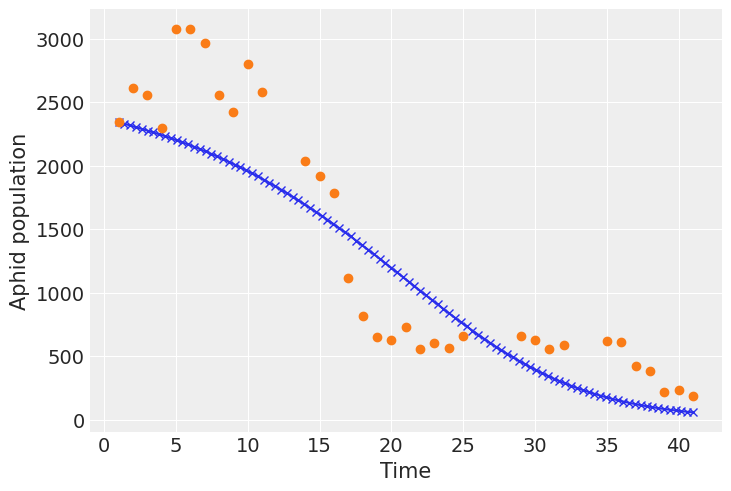

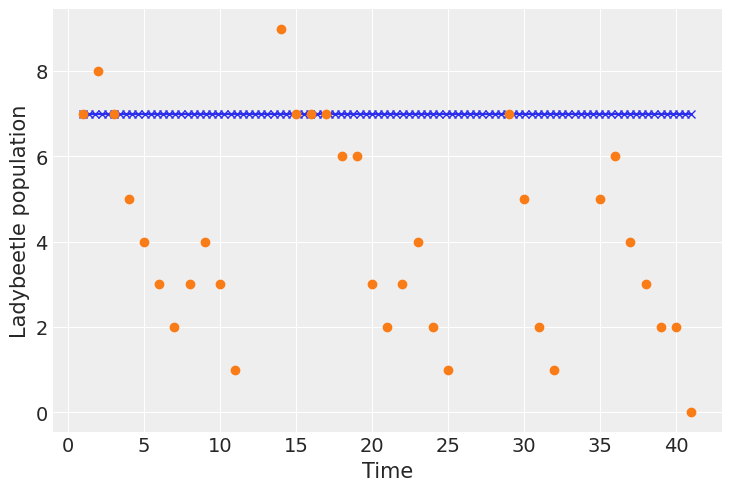

In [414]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_LP2, u_LP2, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_LP2, v_LP2, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [415]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [416]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = LP2_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        LP2_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 24/24 [00:00<00:00, 343.80it/s]


In [417]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$r1$   0.407401
$a1$   0.381515
$a3$   0.116421
$a2$  0.0509394
$r2$  0.0437234

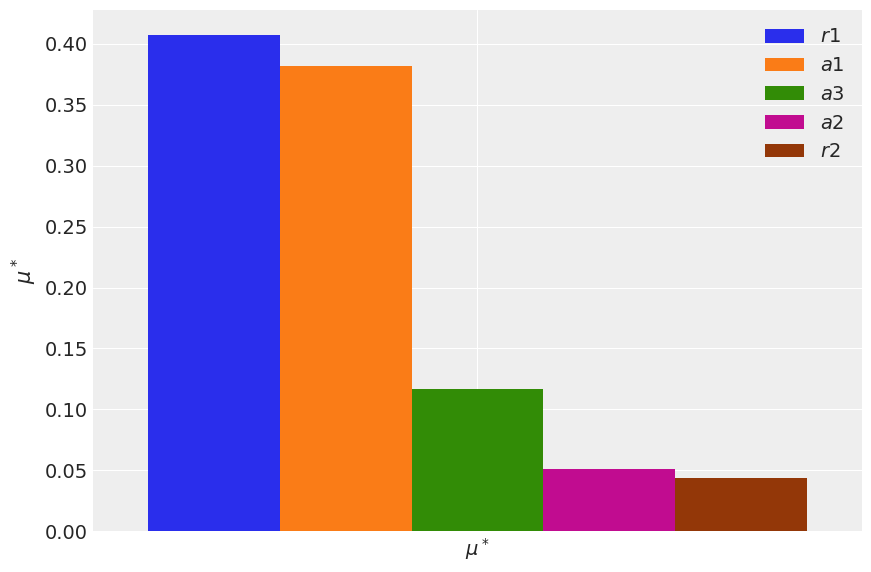

In [418]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares_LP2.png", dpi=300)
plt.show()

### Prey (pest) population

In [419]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [420]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_LP2 = LP2_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_LP2.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 24/24 [00:00<00:00, 476.37it/s]


In [421]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:01<00:00, 94.49it/s]


Time      $r1$        $r2$      $a1$       $a2$      $a3$
0    1.404040  0.320567  0.00379447  0.355774   0.138862  0.181003
1    1.808081  0.322388  0.00381454   0.35568   0.137089  0.181028
2    2.212121  0.322707  0.00388364  0.353899    0.13772  0.181791
3    2.616162  0.323658  0.00396885  0.353507   0.136761  0.182105
4    3.020202  0.324815  0.00402433  0.352648   0.135604  0.182909
..        ...       ...         ...       ...        ...       ...
94  39.383838   0.42656   0.0375522  0.301893  0.0496992  0.184295
95  39.787879  0.426254    0.038597  0.301052  0.0492946  0.184802
96  40.191919  0.425931   0.0396677  0.300144  0.0489003  0.185357
97  40.595960   0.42559    0.040764  0.299167  0.0485183  0.185961
98  41.000000  0.425231   0.0418856  0.298117  0.0481499  0.186617

[99 rows x 6 columns]

In [422]:
df_sigmai

Time        $r1$         $r2$      $a1$       $a2$       $a3$
0    1.404040  0.00675973  6.76685e-05  0.352301   0.367426   0.273446
1    1.808081   0.0156888  0.000170955  0.344675   0.368012   0.271453
2    2.212121   0.0152931  0.000349212  0.342102   0.365259   0.276997
3    2.616162   0.0263041  0.000483455  0.334634   0.364302   0.274276
4    3.020202   0.0369407  0.000752087  0.327122   0.362135    0.27305
..        ...         ...          ...       ...        ...        ...
94  39.383838    0.399035    0.0533688  0.421179  0.0681099   0.058307
95  39.787879     0.39758    0.0550231  0.420245  0.0682529  0.0588995
96  40.191919    0.396004    0.0567274  0.419263  0.0684461  0.0595595
97  40.595960    0.394304    0.0584823  0.418227  0.0686936  0.0602934
98  41.000000    0.392472    0.0602893  0.417137  0.0689987  0.0611026

[99 rows x 6 columns]

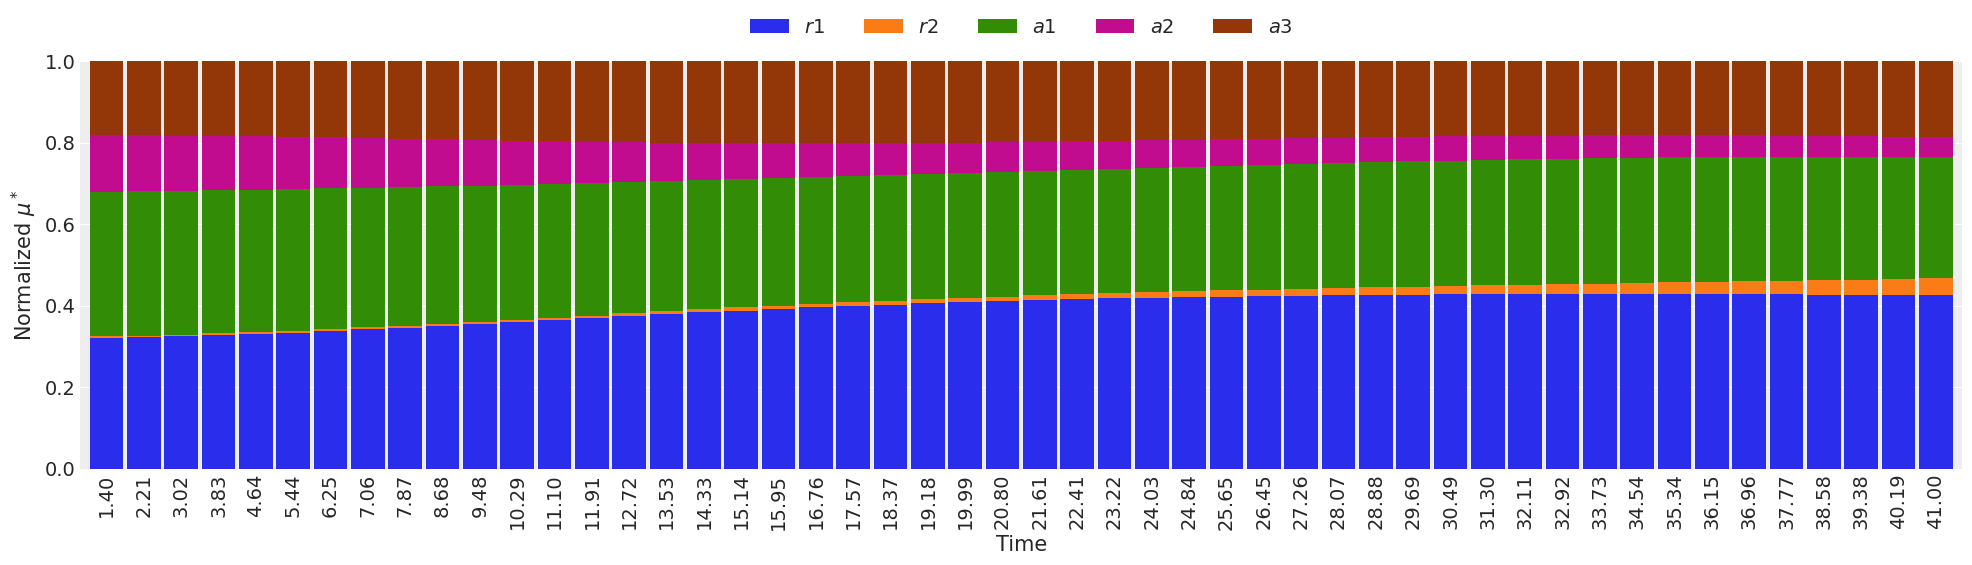

In [423]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_LP2.png", dpi=300)
plt.show()

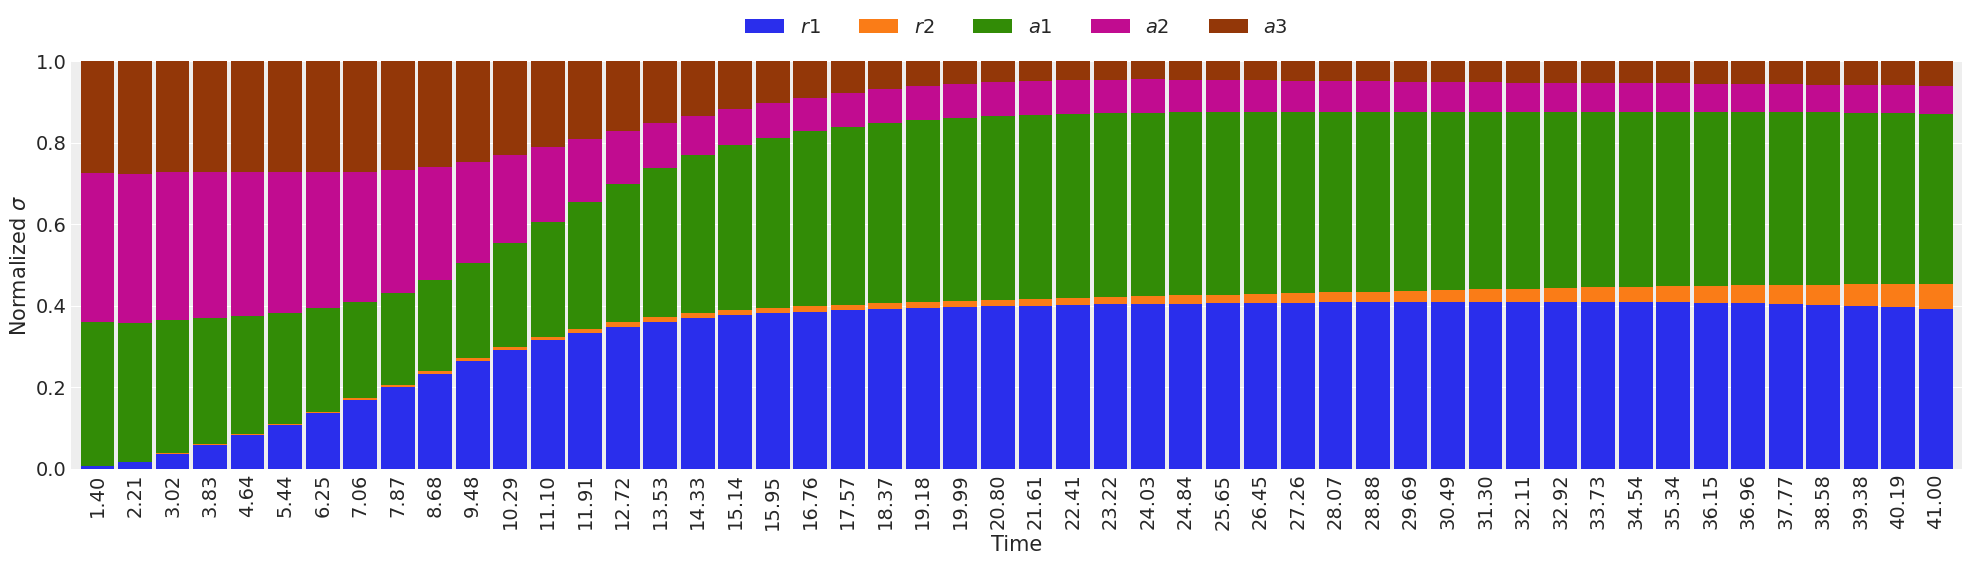

In [424]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_LP2.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [425]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [426]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_LP2,
    u_LP2,
    v_LP2,
    LP2_model,
    mean_values_params
)

pest_time_derivative_array

array([-37.33212442, -38.02565826, -38.71536968, -39.50776734,
       -40.20513435, -40.92379946, -41.66332265, -42.42498742,
       -43.20890734, -44.01440334, -44.8407578 , -45.68721264,
       -46.55296736, -47.43717683, -48.33894901, -49.25765354,
       -50.19538034, -51.15174961, -52.1254906 , -53.11525606,
       -54.11961767, -55.13706091, -56.1659797 , -57.20467039,
       -58.25144923, -59.30508318, -60.36359069, -61.42474376,
       -62.48617254, -63.5453551 , -64.59960617, -65.64606492,
       -66.68168145, -67.70237179, -68.70193882, -69.67690576,
       -70.62385602, -71.53915008, -72.41890758, -73.25898775,
       -74.05496786, -74.8021195 , -75.49472034, -76.12420814,
       -76.68579623, -77.17508793, -77.58740634, -77.91777185,
       -78.16087265, -78.31052434, -78.36226434, -78.31261426,
       -78.15791722, -77.89432635, -77.51779214, -77.02507289,
       -76.41701125, -75.69279097, -74.8513343 , -73.89158305,
       -72.81564605, -71.62997329, -70.33699785, -68.93

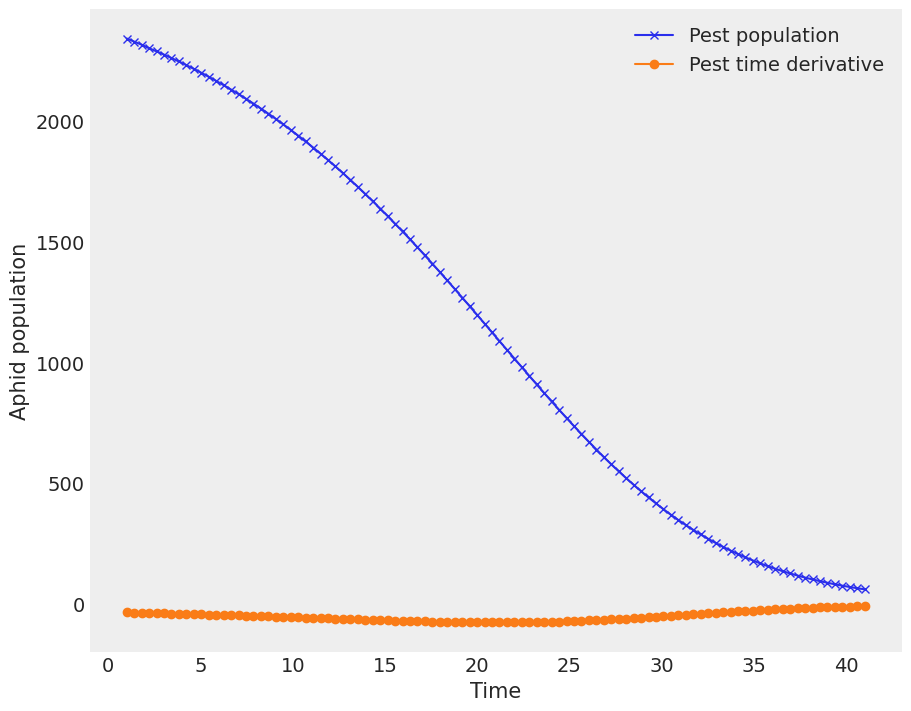

In [427]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_LP2, u_LP2, '-x', label='Pest population')
plt.plot(t_computed_LP2, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative_LP2.png", dpi=300)
plt.show()

In [428]:
mean_values_params = [
    r1,
    r2,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [429]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_LP2 = LP2_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_LP2.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        LP2_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 24/24 [00:00<00:00, 168.83it/s]


In [430]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:01<00:00, 73.55it/s]


Time      $r1$        $r2$      $a1$       $a2$      $a3$
0    1.404040  0.319348  0.00375576  0.359746   0.138641  0.178509
1    1.808081  0.321883  0.00388071  0.357771   0.136737  0.179729
2    2.212121  0.324481  0.00401151  0.355619   0.134853  0.181037
3    2.616162  0.327241  0.00414967  0.353504   0.132765   0.18234
4    3.020202  0.330183  0.00429189  0.351275   0.130493  0.183757
..        ...       ...         ...       ...        ...       ...
94  39.383838  0.416158   0.0679701      0.28  0.0379556  0.197915
95  39.787879  0.415184    0.070208   0.27676   0.037735  0.200113
96  40.191919  0.414184     0.07251  0.273336  0.0375609   0.20241
97  40.595960  0.413158   0.0748753  0.269721  0.0374388  0.204807
98  41.000000  0.412107   0.0773021   0.26591  0.0373733  0.207308

[99 rows x 6 columns]

In [431]:
df_sigmai

Time       $r1$         $r2$      $a1$       $a2$       $a3$
0    1.404040  0.0148745  0.000330522  0.351402   0.372518   0.260875
1    1.808081  0.0311566  0.000701047  0.337217   0.369539   0.261386
2    2.212121  0.0479389   0.00109803  0.322672   0.365495   0.262796
3    2.616162  0.0670178   0.00153938  0.307018   0.360644   0.263781
4    3.020202  0.0878346   0.00204458  0.290653   0.354496   0.264972
..        ...        ...          ...       ...        ...        ...
94  39.383838   0.347819    0.0994219  0.388291  0.0757134  0.0887546
95  39.787879   0.341087      0.10325  0.385354  0.0776494  0.0926597
96  40.191919   0.333912     0.107194   0.38228   0.079738  0.0968752
97  40.595960   0.326284     0.111251  0.379078  0.0819825   0.101404
98  41.000000   0.318191     0.115416  0.375762  0.0843848   0.106246

[99 rows x 6 columns]

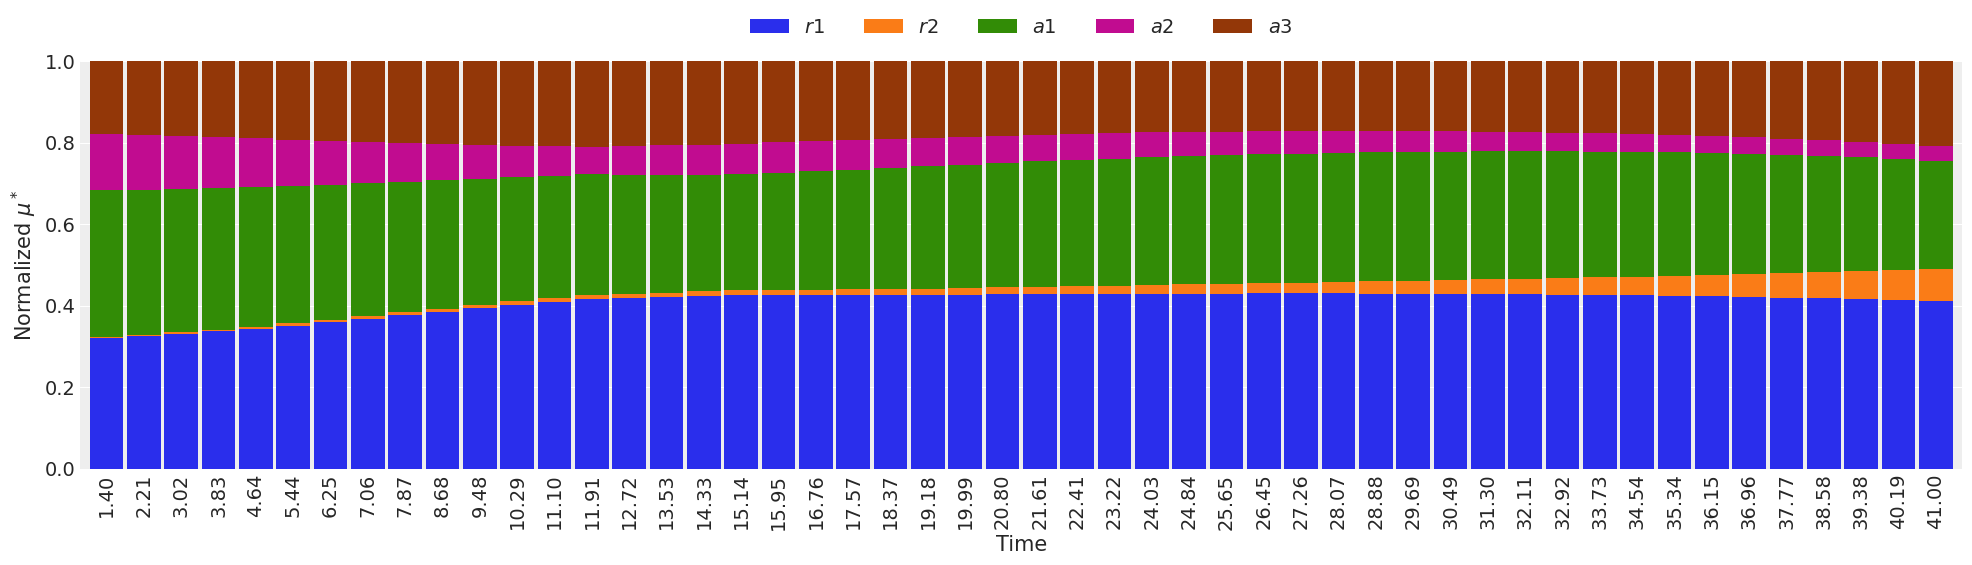

In [432]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_LP2.png", dpi=300)
plt.show()

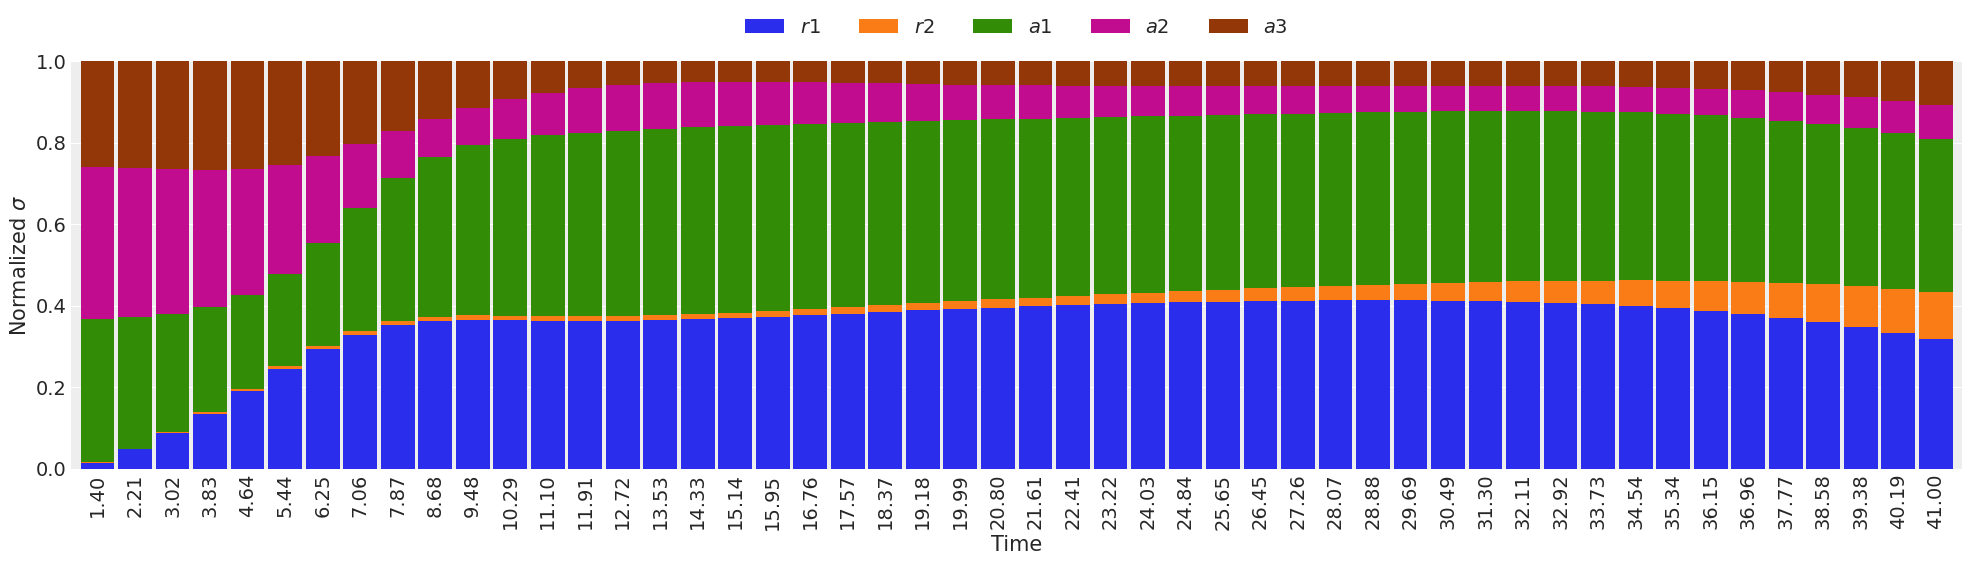

In [433]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_LP2.png", dpi=300)
plt.show()

## Bayesian calibration

In [434]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1
        t.dscalar,  # r2
        t.dscalar,  # a1
        t.dscalar,  # a2
        t.dscalar,  # a3
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def LP2_ode_wrapper(time_exp, r1, r2, a1, a2, a3, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, r2, a1, a2, a3]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        LP2_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [435]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_LP2:
    # Prior distributions for the model's parameters
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - percent_calibration) * r1,
        upper=(1.0 + 10 * percent_calibration) * r1,
    )
#    r2_ = pm.Uniform(
#        "r2",
#        lower=(1.0 - percent_calibration) * r2,
#        upper=(1.0 + percent_calibration) * r2,
#    )
    r2_ = pm.Data("r2", r2)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + 10 * percent_calibration) * a1,
    )
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
#    a3_ = pm.Uniform(
#        "a3", 
#        lower=(1.0 - percent_calibration) * a3,
#        upper=(1.0 + percent_calibration) * a3,
#    )
    a3_ = pm.Data("a3", a3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=800, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "LP2_model",
        LP2_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - percent_calibration) * r1,
        upper=(1.0 + 10 * percent_calibration) * r1,
    )
#    r2_ = pm.Uniform(
#        "r2",
#        lower=(1.0 - percent_calibration) * r2,
#        upper=(1.0 + percent_calibration) * r2,
#    )
    r2_ = pm.Data("r2", r2)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + 10 * percent_calibration) * a1,
    )
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
#    a3_ = pm.Uniform(
#        "a3", 
#        lower=(1.0 - percent_calibration) * a3,
#        upper=(1.0 + percent_calibration) * a3,
#    )
#    a3_ = pm.Uniform(
#        "a3", 
#        lower=(1.0 - percent_calibration) * a3,
#        upper=(1.0 + percent_calibration) * a3,
#    )
    a3_ = pm.Data("a3", a3)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=800, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "LP2_model",
        LP2_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - percent_calibration) * r1,
        upper=(1.0 + 10 * percent_calibration) * r1,
    )
#    r2_ = pm.Uniform(
#        "r2",
#        lower=(1.0 - percent_calibration) * r2,
#        upper=(1.0 + percent_calibration) * r2,
#    )
    r2_ = pm.Data("r2", r2)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + 10 * percent_calibration) * a1,
    )
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
#    a3_ = pm.Uniform(
#        "a3", 
#        lower=(1.0 - percent_calibration) * a3,
#        upper=(1.0 + percent_calibration) * a3,
#    )
    a3_ = pm.Data("a3", a3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=800, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "LP2_model",
        LP2_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_LP2:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_LP2 = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (4 chains in 4 jobs)
MLDA: [std_deviation, a1, r1]


Sampling 4 chains for 1_000 tune and 4_500 draw iterations (4_000 + 18_000 draws total) took 1114 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


-- Monte Carlo simulations done in 20.360 minutes


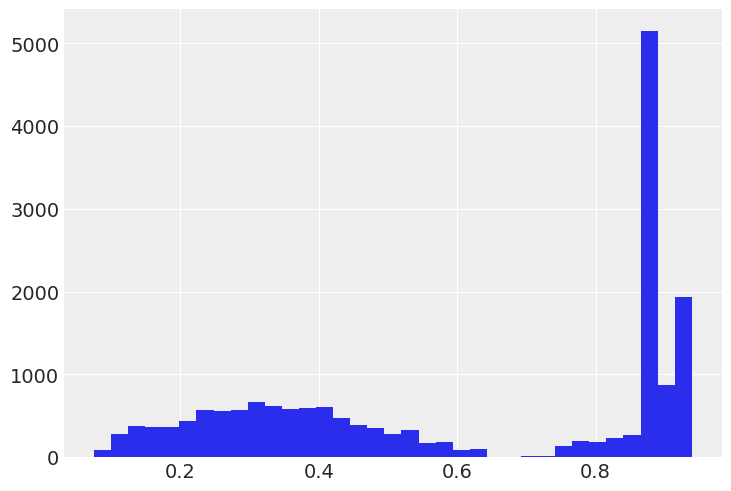

In [436]:
plt.hist(trace_calibration_LP2['r1'], bins=35)
plt.show()

In [437]:
calibration_variable_names = [
    "std_deviation",
    "r1",
    "a1",
]

In [ ]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_LP2[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal_LP2.png")

 67%|██████▋   | 2/3 [03:03<01:29, 89.93s/it]

In [ ]:
az.plot_pair(
    trace_calibration_LP2,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_LP2.png")

In [ ]:
df_stats_summary = az.summary(
    data=trace_calibration_LP2,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

Auxiliary functions to compute the Most Probable Value (MPV):

In [ ]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [ ]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_LP2, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_LP2.csv")  # salvando em um csv para consultas

df_stats_summary

In [ ]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_LP2["LP2_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_LP2["LP2_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_LP2["LP2_model"], 50, axis=0)

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration_LP2.png", dpi=300)
plt.show()

In [ ]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_LP2.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_LP2.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

In [ ]:
df_realizations

# Logistic Prey Growth FR3 model

In [ ]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def LP3_model(
    t,
    X,
    r1 = 1,
    r2 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    u, v = X
    u_prime = r1 * u - r2 * u * u - a1 * u * u * v / ( a2 + a3 * u * u )
    v_prime = 0
    return u_prime, v_prime

def LP3_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 1,
    r2 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    solution_ODE = solve_ivp(
        fun=LP3_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,r2,a1,a2,a3),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [ ]:
def LP3_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [ ]:
from scipy import optimize

seed = 1234

r1=0.0013449982979212053
r2=5.107493312221165e-09
a1=0.29248668073045164
a2=0.00010184919192640282
a3=0.034710039784000675
denom_min = 0.1
denom_max = 1.9
bounds_LP3 = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),  # r2
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
    ( ( a2 * denom_min ), ( a2 * denom_max ) ),  # a2
    ( ( a3 * denom_min ), ( a3 * denom_max ) ),  # a3
]

result_LP3 = optimize.differential_evolution(
    LP3_least_squares_error_ode,
    bounds=bounds_LP3,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        LP3_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=20000, # 2000
    polish=True,
    disp=True,
    seed = seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_LP3)

* Retrieving the calibrated parameter values:

In [ ]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    r2_deterministic,
    a1_deterministic,
    a2_deterministic,
    a3_deterministic,
) = result_LP3.x

solution_ODE_LP3 = LP3_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_LP3.x
)
t_computed_LP3, y_computed_LP3 = solution_ODE_LP3.t, solution_ODE_LP3.y
u_LP3, v_LP3 = y_computed_LP3

parameters_dict = {
    "Model": "LP3",
    u"$r1$": r1_deterministic,
    u"$r2$": r2_deterministic,
    u"$a1$": a1_deterministic,
    u"$a2$": a2_deterministic,
    u"$a3$": a3_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "r2=" + str(r2_deterministic) + "\n" + "a1=" + str(a1_deterministic) + "\n" + "a2=" + str(a2_deterministic) + "\n" + "a3=" + str(a3_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

#### Simulation

In [ ]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_LP3, u_LP3, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_LP3, v_LP3, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [ ]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [ ]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = LP3_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        LP3_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

In [ ]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

In [ ]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares_LP3.png", dpi=300)
plt.show()

### Prey (pest) population

In [ ]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [ ]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_LP3 = LP3_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_LP3.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

In [ ]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

In [ ]:
df_sigmai

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_LP3.png", dpi=300)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_LP3.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [ ]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [ ]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_LP3,
    u_LP3,
    v_LP3,
    LP3_model,
    mean_values_params
)

pest_time_derivative_array

In [ ]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_LP3, u_LP3, '-x', label='Pest population')
plt.plot(t_computed_LP3, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative_LP3.png", dpi=300)
plt.show()

In [ ]:
mean_values_params = [
    r1,
    r2,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [ ]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_LP3 = LP3_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_LP3.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        LP3_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

In [ ]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

In [ ]:
df_sigmai

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_LP3.png", dpi=300)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_LP3.png", dpi=300)
plt.show()

## Bayesian calibration

In [ ]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # r2
        t.dscalar,  # a1
        t.dscalar,  # a2
        t.dscalar,  # a3
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def LP3_ode_wrapper(time_exp, r1, r2, a1, a2, a3, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, r2, a1, a2, a3]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        LP3_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [ ]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_LP3:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
#    r2_ = pm.Uniform(
#        "r2",
#        lower=(1.0 - percent_calibration) * r2,
#        upper=(1.0 + percent_calibration) * r2,
#    )
    r2_ = pm.Data("r2", r2)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + percent_calibration) * a1,
    )
#    a2_ = pm.Uniform(
#        "a2",
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 + percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "LP3_model",
        LP3_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
#    r2_ = pm.Uniform(
#        "r2",
#        lower=(1.0 - percent_calibration) * r2,
#        upper=(1.0 + percent_calibration) * r2,
#    )
    r2_ = pm.Data("r2", r2)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + percent_calibration) * a1,
    )
#    a2_ = pm.Uniform(
#        "a2",
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 + percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "LP3_model",
        LP3_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
#    r2_ = pm.Uniform(
#        "r2",
#        lower=(1.0 - percent_calibration) * r2,
#        upper=(1.0 + percent_calibration) * r2,
#    )
    r2_ = pm.Data("r2", r2)
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=1e6#(1.0 + percent_calibration) * a1,
    )
#    a2_ = pm.Uniform(
#        "a2",
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
    a3_ = pm.Uniform(
        "a3", 
        lower=(1.0 - percent_calibration) * a3,
        upper=1e6#(1.0 + percent_calibration) * a3,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "LP3_model",
        LP3_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_LP3:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_LP3 = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")

In [ ]:
plt.hist(trace_calibration_LP3['a1'], bins=35)
plt.show()

In [ ]:
calibration_variable_names = [
    "std_deviation",
    "a1",
    "a3",
]

In [ ]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_LP3[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal_LP3.png")

In [ ]:
az.plot_pair(
    trace_calibration_LP3,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_LP3.png")

In [ ]:
df_stats_summary = az.summary(
    data=trace_calibration_LP3,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

Auxiliary functions to compute the Most Probable Value (MPV):

In [ ]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [ ]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_LP3, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_LP3.csv")  # salvando em um csv para consultas

df_stats_summary

In [ ]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_LP3["LP3_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_LP3["LP3_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_LP3["LP3_model"], 50, axis=0)

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration_LP3.png", dpi=300)
plt.show()

In [ ]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_LP3.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_LP3.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

In [ ]:
df_realizations

# Allee Prey Growth FR1 model

## The parameters r1 and r3 are very close to zero

In [ ]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def AP1_model(
    t,
    X,
    r1 = 1,
    r2 = 1,
    r3 = 1,
    a1 = 1,
):
    u, v = X
    u_prime = ( r1 * u - r2 * u * u ) * ( r2 * u * u - r3 * u ) - a1 * u * v 
    v_prime = 0
    return u_prime, v_prime

def AP1_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 1,
    r2 = 1,
    r3 = 1,
    a1 = 1,
):
    solution_ODE = solve_ivp(
        fun=AP1_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,r2,r3,a1),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [ ]:
def AP1_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [ ]:
from scipy import optimize

seed = 1234

r1=0.00025591841125063587
r2=8.187887886937167e-11
r3=0.03133563264585748
a1=0.003699720734502655
denom_min = 0.1
denom_max = 1.9
bounds_AP1 = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),  # r2
    ( ( r3 * denom_min ), ( r3 * denom_max ) ),  # r3
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
]

result_AP1 = optimize.differential_evolution(
    AP1_least_squares_error_ode,
    bounds=bounds_AP1,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        AP1_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=20000, # 2000
    polish=True,
    disp=True,
    seed = seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_AP1)

* Retrieving the calibrated parameter values:

In [ ]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    r2_deterministic,
    r3_deterministic,
    a1_deterministic,
) = result_AP1.x

solution_ODE_AP1 = AP1_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_AP1.x
)
t_computed_AP1, y_computed_AP1 = solution_ODE_AP1.t, solution_ODE_AP1.y
u_AP1, v_AP1 = y_computed_AP1

parameters_dict = {
    "Model": "AP1",
    u"$r1$": r1_deterministic,
    u"$r2$": r2_deterministic,
    u"$r3$": r3_deterministic,
    u"$a1$": a1_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "r2=" + str(r2_deterministic) + "\n" + "r3=" + str(r3_deterministic) + "\n" + "a1=" + str(a1_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

#### Simulation

In [ ]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_AP1, u_AP1, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_AP1, v_AP1, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [ ]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    r3,
    a1,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$r3$",
    r"$a1$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [ ]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = AP1_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        AP1_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

In [ ]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

In [ ]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares_AP1.png", dpi=300)
plt.show()

### Prey (pest) population

In [ ]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    r3,
    a1,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$r3$",
    r"$a1$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [ ]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_AP1 = AP1_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_AP1.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

In [ ]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

In [ ]:
df_sigmai

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_AP1.png", dpi=300)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_AP1.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [ ]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [ ]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_AP1,
    u_AP1,
    v_AP1,
    AP1_model,
    mean_values_params
)

pest_time_derivative_array

In [ ]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_AP1, u_AP1, '-x', label='Pest population')
plt.plot(t_computed_AP1, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative_AP1.png", dpi=300)
plt.show()

In [ ]:
mean_values_params = [
    r1,
    r2,
    r3,
    a1,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$r3$",
    r"$a1$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [ ]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_AP1 = AP1_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_AP1.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        AP1_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

In [ ]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

In [ ]:
df_sigmai

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_AP1.png", dpi=300)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_AP1.png", dpi=300)
plt.show()

## Bayesian calibration

In [ ]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1
        t.dscalar,  # r2
        t.dscalar,  # r3
        t.dscalar,  # a1
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def AP1_ode_wrapper(time_exp, r1, r2, r3, a1, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, r2, r3, a1]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        AP1_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [ ]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_AP1:
    # Prior distributions for the model's parameters
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - percent_calibration) * r1,
        upper=(1.0 + 20 * percent_calibration) * r1,
    )
#    r2_ = pm.Uniform(
#        "r2",
#        lower=(1.0 - percent_calibration) * r2,
#        upper=(1.0 + percent_calibration) * r2,
#    )
    r2_ = pm.Data("r2", r2)
    r3_ = pm.Uniform(
        "r3",
        lower=(1.0 - percent_calibration) * r3,
        upper=(1.0 + 20 * percent_calibration) * r3,
    )
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
#    a1_ = pm.Data("a1", a1)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "AP1_model",
        AP1_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            r3_,
            a1_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - percent_calibration) * r1,
        upper=(1.0 + 20 * percent_calibration) * r1,
    )
#    r2_ = pm.Uniform(
#        "r2",
#        lower=(1.0 - percent_calibration) * r2,
#        upper=(1.0 + percent_calibration) * r2,
#    )
    r2_ = pm.Data("r2", r2)
    r3_ = pm.Uniform(
        "r3",
        lower=(1.0 - percent_calibration) * r3,
        upper=(1.0 + 20 * percent_calibration) * r3,
    )
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
#    a1_ = pm.Data("a1", a1)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "AP1_model",
        AP1_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            r3_,
            a1_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - percent_calibration) * r1,
        upper=(1.0 + 20 * percent_calibration) * r1,
    )
#    r2_ = pm.Uniform(
#        "r2",
#        lower=(1.0 - percent_calibration) * r2,
#        upper=(1.0 + percent_calibration) * r2,
#    )
    r2_ = pm.Data("r2", r2)
    r3_ = pm.Uniform(
        "r3",
        lower=(1.0 - percent_calibration) * r3,
        upper=(1.0 + 20 * percent_calibration) * r3,
    )
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
#    a1_ = pm.Data("a1", a1)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "AP1_model",
        AP1_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            r3_,
            a1_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_AP1:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_AP1 = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")

In [ ]:
plt.hist(trace_calibration_AP1['r1'], bins=35)
plt.show()

In [ ]:
calibration_variable_names = [
    "std_deviation",
    "r1",
    "r3",
    "a1", # included a1
]

In [ ]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_AP1[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal_AP1.png")

In [ ]:
az.plot_pair(
    trace_calibration_AP1,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_AP1.png")

In [ ]:
df_stats_summary = az.summary(
    data=trace_calibration_AP1,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

Auxiliary functions to compute the Most Probable Value (MPV):

In [ ]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [ ]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_AP1, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_AP1.csv")  # salvando em um csv para consultas

df_stats_summary

In [ ]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_AP1["AP1_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_AP1["AP1_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_AP1["AP1_model"], 50, axis=0)

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration_AP1.png", dpi=300)
plt.show()

In [ ]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_AP1.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_AP1.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

In [ ]:
df_realizations

# Allee Prey Growth FR2 model

## I can't reach a sinusoidal pattern for all calibrated parameters

In [ ]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def AP2_model(
    t,
    X,
    r1 = 1,
    r2 = 1,
    r3 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    u, v = X
    u_prime = ( r1 * u - r2 * u * u ) * ( r2 * u * u - r3 * u ) - a1 * u * v / ( a2 + a3 * u )
    v_prime = 0
    return u_prime, v_prime

def AP2_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 1,
    r2 = 1,
    r3 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    solution_ODE = solve_ivp(
        fun=AP2_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,r2,r3,a1,a2,a3),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [ ]:
def AP2_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [ ]:
from scipy import optimize

seed = 1234

r1=0.11562168675891937
r2=9.074476369486926e-07
r3=0.0020683597238106855
a1=0.0019297724951409106
a2=0.8083006578721604
a3=2.95741489956641e-05
denom_min = 0.1
denom_max = 1.9
bounds_AP2 = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),  # r2
    ( ( r3 * denom_min ), ( r3 * denom_max ) ),  # r3
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
    ( ( a2 * denom_min ), ( a2 * denom_max ) ),  # a2
    ( ( a3 * denom_min ), ( a3 * denom_max ) ),  # a3
]

result_AP2 = optimize.differential_evolution(
    AP2_least_squares_error_ode,
    bounds=bounds_AP2,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        AP2_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=20000, # 2000
    polish=True,
    disp=True,
    seed = seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_AP2)

* Retrieving the calibrated parameter values:

In [ ]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    r2_deterministic,
    r3_deterministic,
    a1_deterministic,
    a2_deterministic,
    a3_deterministic,
) = result_AP2.x

solution_ODE_AP2 = AP2_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_AP2.x
)
t_computed_AP2, y_computed_AP2 = solution_ODE_AP2.t, solution_ODE_AP2.y
u_AP2, v_AP2 = y_computed_AP2

parameters_dict = {
    "Model": "AP2",
    u"$r1$": r1_deterministic,
    u"$r2$": r2_deterministic,
    u"$r3$": r3_deterministic,
    u"$a1$": a1_deterministic,
    u"$a2$": a2_deterministic,
    u"$a3$": a3_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "r2=" + str(r2_deterministic) + "\n" + "r3=" + str(r3_deterministic) + "\n" + "a1=" + str(a1_deterministic) + "\n" + "a2=" + str(a2_deterministic) + "\n" + "a3=" + str(a3_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

#### Simulation

In [ ]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_AP2, u_AP2, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_AP2, v_AP2, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [ ]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    r3,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$r3$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [ ]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = AP2_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        AP2_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

In [ ]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

In [ ]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares_AP2.png", dpi=300)
plt.show()

### Prey (pest) population

In [ ]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    r3,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$r3$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [ ]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_AP2 = AP2_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_AP2.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

In [ ]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

In [ ]:
df_sigmai

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_AP2.png", dpi=300)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_AP2.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [ ]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [ ]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_AP2,
    u_AP2,
    v_AP2,
    AP2_model,
    mean_values_params
)

pest_time_derivative_array

In [ ]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_AP2, u_AP2, '-x', label='Pest population')
plt.plot(t_computed_AP2, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative_AP2.png", dpi=300)
plt.show()

In [ ]:
mean_values_params = [
    r1,
    r2,
    r3,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$r3$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [ ]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_AP2 = AP2_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_AP2.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        AP2_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

In [ ]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

In [ ]:
df_sigmai

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_AP2.png", dpi=300)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_AP2.png", dpi=300)
plt.show()

## Bayesian calibration

In [ ]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1
        t.dscalar,  # r2
        t.dscalar,  # r3
        t.dscalar,  # a1
        t.dscalar,  # a2
        t.dscalar,  # a3
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def AP2_ode_wrapper(time_exp, r1, r2, r3, a1, a2, a3, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, r2, r3, a1, a2, a3]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        AP2_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [ ]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_AP2:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    r2_ = pm.Uniform(
        "r2", 
        lower=(1.0 - percent_calibration) * r2,
        upper=(1.0 + percent_calibration) * r2,
    )
    r3_ = pm.Uniform(
        "r3",
        lower=(1.0 - percent_calibration) * r3,
        upper=(1.0 + percent_calibration) * r3,
    )
#    a1_ = pm.Uniform(
#        "a1", 
#        lower=(1.0 - percent_calibration) * a1,
#        upper=(1.0 + percent_calibration) * a1,
#    )
    a1_ = pm.Data("a1", a1)
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
#    a3_ = pm.Uniform(
#        "a3", 
#        lower=(1.0 - percent_calibration) * a3,
#        upper=(1.0 + percent_calibration) * a3,
#    )
    a3_ = pm.Data("a3", a3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "AP2_model",
        AP2_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            r3_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    r2_ = pm.Uniform(
        "r2", 
        lower=(1.0 - percent_calibration) * r2,
        upper=(1.0 + percent_calibration) * r2,
    )
    r3_ = pm.Uniform(
        "r3",
        lower=(1.0 - percent_calibration) * r3,
        upper=(1.0 + percent_calibration) * r3,
    )
#    a1_ = pm.Uniform(
#        "a1", 
#        lower=(1.0 - percent_calibration) * a1,
#        upper=(1.0 + percent_calibration) * a1,
#    )
    a1_ = pm.Data("a1", a1)
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
#    a3_ = pm.Uniform(
#        "a3", 
#        lower=(1.0 - percent_calibration) * a3,
#        upper=(1.0 + percent_calibration) * a3,
#    )
    a3_ = pm.Data("a3", a3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "AP2_model",
        AP2_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            r3_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    r2_ = pm.Uniform(
        "r2", 
        lower=(1.0 - percent_calibration) * r2,
        upper=(1.0 + percent_calibration) * r2,
    )
    r3_ = pm.Uniform(
        "r3",
        lower=(1.0 - percent_calibration) * r3,
        upper=(1.0 + percent_calibration) * r3,
    )
#    a1_ = pm.Uniform(
#        "a1", 
#        lower=(1.0 - percent_calibration) * a1,
#        upper=(1.0 + percent_calibration) * a1,
#    )
    a1_ = pm.Data("a1", a1)
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
    a2_ = pm.Data("a2", a2)
#    a3_ = pm.Uniform(
#        "a3", 
#        lower=(1.0 - percent_calibration) * a3,
#        upper=(1.0 + percent_calibration) * a3,
#    )
    a3_ = pm.Data("a3", a3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "AP2_model",
        AP2_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            r3_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_AP2:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_AP2 = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")

In [ ]:
plt.hist(trace_calibration_AP2['r2'], bins=35)
plt.show()

In [ ]:
calibration_variable_names = [
    "std_deviation",
    "r2",
    "r3",
]

In [ ]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_AP2[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal_AP2.png")

In [ ]:
az.plot_pair(
    trace_calibration_AP2,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_AP2.png")

In [ ]:
df_stats_summary = az.summary(
    data=trace_calibration_AP2,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

Auxiliary functions to compute the Most Probable Value (MPV):

In [ ]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [ ]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_AP2, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_AP2.csv")  # salvando em um csv para consultas

df_stats_summary

In [ ]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_AP2["AP2_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_AP2["AP2_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_AP2["AP2_model"], 50, axis=0)

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration_AP2.png", dpi=300)
plt.show()

In [ ]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_AP2.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_AP2.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

In [ ]:
df_realizations

# Allee Prey Growth FR3 model

## I can't reach a sinusoidal pattern for all calibrated parameters

In [ ]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def AP3_model(
    t,
    X,
    r1 = 1,
    r2 = 1,
    r3 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    u, v = X
    u_prime = ( r1 * u - r2 * u * u ) * ( r2 * u * u - r3 * u ) - a1 * u * u * v / ( a2 + a3 * u * u )
    v_prime = 0
    return u_prime, v_prime

def AP3_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 1,
    r2 = 1,
    r3 = 1,
    a1 = 1,
    a2 = 1,
    a3 = 1,
):
    solution_ODE = solve_ivp(
        fun=AP3_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,r2,r3,a1,a2,a3),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [ ]:
def AP3_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [ ]:
from scipy import optimize

seed = 1234

r1=0.09096034819104581
r2=1.0447969232498829e-06
r3=0.002414772393279044
a1=0.001563078527810546
a2=1.0366698235781737
a3=0.0006702488786416308
denom_min = 0.1
denom_max = 1.9
bounds_AP3 = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),  # r2
    ( ( r3 * denom_min ), ( r3 * denom_max ) ),  # r3
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
    ( ( a2 * denom_min ), ( a2 * denom_max ) ),  # a2
    ( ( a3 * denom_min ), ( a3 * denom_max ) ),  # a3
]

result_AP3 = optimize.differential_evolution(
    AP3_least_squares_error_ode,
    bounds=bounds_AP3,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        AP3_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=20000, # 2000
    polish=True,
    disp=True,
    seed = seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_AP3)

* Retrieving the calibrated parameter values:

In [ ]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    r2_deterministic,
    r3_deterministic,
    a1_deterministic,
    a2_deterministic,
    a3_deterministic,
) = result_AP3.x

solution_ODE_AP3 = AP3_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_AP3.x
)
t_computed_AP3, y_computed_AP3 = solution_ODE_AP3.t, solution_ODE_AP3.y
u_AP3, v_AP3 = y_computed_AP3

parameters_dict = {
    "Model": "AP3",
    u"$r1$": r1_deterministic,
    u"$r2$": r2_deterministic,
    u"$r3$": r3_deterministic,
    u"$a1$": a1_deterministic,
    u"$a2$": a2_deterministic,
    u"$a3$": a3_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "r2=" + str(r2_deterministic) + "\n" + "r3=" + str(r3_deterministic) + "\n" + "a1=" + str(a1_deterministic) + "\n" + "a2=" + str(a2_deterministic) + "\n" + "a3=" + str(a3_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

#### Simulation

In [ ]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_AP3, u_AP3, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_AP3, v_AP3, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [ ]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    r3,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$r3$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [ ]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = AP3_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        AP3_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

In [ ]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

In [ ]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares_AP3.png", dpi=300)
plt.show()

### Prey (pest) population

In [ ]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    r3,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$r3$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [ ]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_AP3 = AP3_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_AP3.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

In [ ]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

In [ ]:
df_sigmai

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_AP3.png", dpi=300)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_AP3.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [ ]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [ ]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_AP3,
    u_AP3,
    v_AP3,
    AP3_model,
    mean_values_params
)

pest_time_derivative_array

In [ ]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_AP3, u_AP3, '-x', label='Pest population')
plt.plot(t_computed_AP3, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative_AP3.png", dpi=300)
plt.show()

In [ ]:
mean_values_params = [
    r1,
    r2,
    r3,
    a1,
    a2,
    a3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$r3$",
    r"$a1$",
    r"$a2$",
    r"$a3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [ ]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_AP3 = AP3_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_AP3.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        AP3_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

In [ ]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

In [ ]:
df_sigmai

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_AP3.png", dpi=300)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_AP3.png", dpi=300)
plt.show()

## Bayesian calibration

In [ ]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # r2
        t.dscalar,  # r3
        t.dscalar,  # a1
        t.dscalar,  # a2
        t.dscalar,  # a3
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def AP3_ode_wrapper(time_exp, r1, r2, r3, a1, a2, a3, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, r2, r3, a1, a2, a3]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        AP3_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [ ]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_AP3:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    r2_ = pm.Uniform(
        "r2",
        lower=(1.0 - percent_calibration) * r2,
        upper=(1.0 + percent_calibration) * r2,
    )
    r3_ = pm.Uniform(
        "r3",
        lower=(1.0 - percent_calibration) * r3,
        upper=(1.0 + percent_calibration) * r3,
    )
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
#    a1_ = pm.Data("a1", a1)
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
#    a2_ = pm.Data("a2", a2)
#    a3_ = pm.Uniform(
#        "a3", 
#        lower=(1.0 - percent_calibration) * a3,
#        upper=(1.0 + percent_calibration) * a3,
#    )
    a3_ = pm.Data("a3", a3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "AP3_model",
        AP3_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            r3_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    r2_ = pm.Uniform(
        "r2",
        lower=(1.0 - percent_calibration) * r2,
        upper=(1.0 + percent_calibration) * r2,
    )
    r3_ = pm.Uniform(
        "r3",
        lower=(1.0 - percent_calibration) * r3,
        upper=(1.0 + percent_calibration) * r3,
    )
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
#    a1_ = pm.Data("a1", a1)
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
#    a2_ = pm.Data("a2", a2)
#    a3_ = pm.Uniform(
#        "a3", 
#        lower=(1.0 - percent_calibration) * a3,
#        upper=(1.0 + percent_calibration) * a3,
#    )
    a3_ = pm.Data("a3", a3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "AP3_model",
        AP3_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            r3_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
#    r1_ = pm.Uniform(
#        "r1", 
#        lower=(1.0 - percent_calibration) * r1,
#        upper=(1.0 + percent_calibration) * r1,
#    )
    r1_ = pm.Data("r1", r1)
    r2_ = pm.Uniform(
        "r2",
        lower=(1.0 - percent_calibration) * r2,
        upper=(1.0 + percent_calibration) * r2,
    )
    r3_ = pm.Uniform(
        "r3",
        lower=(1.0 - percent_calibration) * r3,
        upper=(1.0 + percent_calibration) * r3,
    )
    a1_ = pm.Uniform(
        "a1", 
        lower=(1.0 - percent_calibration) * a1,
        upper=(1.0 + percent_calibration) * a1,
    )
#    a1_ = pm.Data("a1", a1)
#    a2_ = pm.Uniform(
#        "a2", 
#        lower=(1.0 - percent_calibration) * a2,
#        upper=(1.0 + percent_calibration) * a2,
#    )
#    a2_ = pm.Data("a2", a2)
#    a3_ = pm.Uniform(
#        "a3", 
#        lower=(1.0 - percent_calibration) * a3,
#        upper=(1.0 + percent_calibration) * a3,
#    )
    a3_ = pm.Data("a3", a3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "AP3_model",
        AP3_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            r3_,
            a1_,
            a2_,
            a3_,
            u0_,
            v0_,
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_AP3:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_AP3 = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")

In [ ]:
plt.hist(trace_calibration_AP3['r2'], bins=35)
plt.show()

In [ ]:
calibration_variable_names = [
    "std_deviation",
    "r2",
    "r3",
    "a1", # changed a3 with a1
]

In [ ]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_AP3[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal_AP3.png")

In [ ]:
az.plot_pair(
    trace_calibration_AP3,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_AP3.png")

In [ ]:
df_stats_summary = az.summary(
    data=trace_calibration_AP3,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

Auxiliary functions to compute the Most Probable Value (MPV):

In [ ]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [ ]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_AP3, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_AP3.csv")  # salvando em um csv para consultas

df_stats_summary

In [ ]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_AP3["AP3_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_AP3["AP3_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_AP3["AP3_model"], 50, axis=0)

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration_AP3.png", dpi=300)
plt.show()

In [ ]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_AP3.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_AP3.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

In [ ]:
df_realizations

# Model comparison/selection

## From PyMC3

Check [this example](https://docs.pymc.io/pymc-examples/examples/diagnostics_and_criticism/model_comparison.html) for further information.

TL;DR: The "score", which is "loo" or "waic" in the printed dataframe bellow, should the greatest for the best model. The `weight` is one of the most important information, because it loosely tell the probability of the model to be the "correct one" among all the compared models.

In [ ]:
print("\n*** Performing model comparison ***")
start_time = time.time()

models_to_compare = {
    "CP1": trace_calibration_CP1,
    "CP2": trace_calibration_CP2,
    "CP3": trace_calibration_CP3,
    "EP1": trace_calibration_EP1,
    "EP2": trace_calibration_EP2,
    "EP3": trace_calibration_EP3,
    "LP1": trace_calibration_LP1,
    "LP2": trace_calibration_LP2,
    "LP3": trace_calibration_LP3,
    "AP1": trace_calibration_AP1,
    "AP2": trace_calibration_AP2,
    "AP3": trace_calibration_AP3,
}

# Choose ic='loo' or ic='waic'
df_model_comparison = pm.compare(
    models_to_compare, 
    ic='waic',
    method='BB-pseudo-BMA',
    b_samples=3000,
    seed=seed
)

duration = time.time() - start_time

print(f"-- Model comparison done in {duration / 60:.3f} minutes")

df_model_comparison

In [ ]:
az.plot_compare(df_model_comparison, figsize=(12, 4), insample_dev=False)

plt.show()

## Custom (and basic) information criteria

The criteria employed here are:

* AIC -- Akaike Information Criterion
* BIC -- Bayesian Information Criterion

Both ICs are based on the residual of least squares. This approach has as hypothesis that the error residuals, i.e., $\sum_{i = 1}^n (y^{\text{obs}}_i - y^{\text{model}}_i)^2$, are independent identical normal, with zero mean.

An auxiliary quantity is defined in order to compare the models (relative to the best one):

\begin{equation}
\mathcal{L}^{\text{rel}}_i := \exp{\left(\frac{\text{IC}_{\text{min}} - \text{IC}_i}{2}\right)}
\end{equation}

where $\text{IC}_i$ is the information criterion value (it can be AIC or BIC) for the $i$th model, and $\text{IC}_{\text{min}}$ is the minimum (i.e., the best model) information criterion value from the set of compared models.

This auxiliary quantity is known as "relative likelihood". It is proportional to the probability that the $i$th model minimizes the information loss. For the best model, this value will be always equal to 1.

In [ ]:
def calculate_aic_score(trace, rv_model_name, num_of_parameters, observations):
    u_observed, v_observed = observations.T
    k = num_of_parameters
    n = observations.shape[0]
    aic_scores = list()
    progress_bar = tqdm(trace[rv_model_name])
    for model_realization in progress_bar:
        progress_bar.set_description(f"Calculating AIC for {rv_model_name}")
        u_realization, v_realization = model_realization.T
        u_realization_residual = u_observed - u_realization
        v_realization_residual = v_observed - v_realization
        u_residual_sum_of_squares = np.sum(u_realization_residual * u_realization_residual)
        v_residual_sum_of_squares = np.sum(v_realization_residual * v_realization_residual)
        total_residual_sum_of_squares = u_residual_sum_of_squares + v_residual_sum_of_squares
        
        # Information criterion in terms of least-squares error residuals
        realization_aic_score = 2 * k + n * np.log(total_residual_sum_of_squares)
        aic_scores.append(realization_aic_score)

    aic_scores = np.array(aic_scores)
    return aic_scores


def calculate_aicc_score(trace, rv_model_name, num_of_parameters, observations):
    u_observed, v_observed = observations.T
    k = num_of_parameters
    n = observations.shape[0]
    aic_scores = list()
    progress_bar = tqdm(trace[rv_model_name])
    for model_realization in progress_bar:
        progress_bar.set_description(f"Calculating AICc for {rv_model_name}")
        u_realization, v_realization = model_realization.T
        u_realization_residual = u_observed - u_realization
        v_realization_residual = v_observed - v_realization
        u_residual_sum_of_squares = np.sum(u_realization_residual * u_realization_residual)
        v_residual_sum_of_squares = np.sum(v_realization_residual * v_realization_residual)
        total_residual_sum_of_squares = u_residual_sum_of_squares + v_residual_sum_of_squares
        
        # Information criterion in terms of least-squares error residuals
        realization_aic_score = 2 * k + n * np.log(total_residual_sum_of_squares)
        realization_aic_score += 2 * (k * k + k) / (n - k - 1)
        aic_scores.append(realization_aic_score)

    aic_scores = np.array(aic_scores)
    return aic_scores



def calculate_bic_score(trace, rv_model_name, num_of_parameters, observations):
    u_observed, v_observed = observations.T
    k = num_of_parameters
    n = observations.shape[0]
    bic_scores = list()
    progress_bar = tqdm(trace[rv_model_name])
    for model_realization in progress_bar:
        progress_bar.set_description(f"Calculating BIC for {rv_model_name}")
        u_realization, v_realization = model_realization.T
        u_realization_residual = u_observed - u_realization
        v_realization_residual = v_observed - v_realization
        u_residual_sum_of_squares = np.sum(u_realization_residual * u_realization_residual)
        v_residual_sum_of_squares = np.sum(v_realization_residual * v_realization_residual)
        total_residual_sum_of_squares = u_residual_sum_of_squares + v_residual_sum_of_squares
        
        # Information criterion in terms of least-squares error residuals
        realization_bic_score = k * np.log(n) + n * np.log(total_residual_sum_of_squares / n)
        bic_scores.append(realization_bic_score)

    bic_scores = np.array(bic_scores)
    return bic_scores

In [ ]:
aic_scores = calculate_aic_score(trace_calibration_CP1, 'CP1_model', 5, observations_to_fit)
aic_mpv = _scalar_rv_mvp_estimation(aic_scores)

In [ ]:
plt.hist(aic_scores, bins=30)
plt.axvline(x=aic_mpv, color='red', linestyle='--')
plt.xlabel("AIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aicc_scores = calculate_aicc_score(trace_calibration_CP1, 'CP1_model', 5, observations_to_fit)
aicc_mpv = _scalar_rv_mvp_estimation(aicc_scores)

In [ ]:
plt.hist(aicc_scores, bins=30)
plt.axvline(x=aicc_mpv, color='red', linestyle='--')
plt.xlabel("AICc score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
bic_scores = calculate_bic_score(trace_calibration_CP1, 'CP1_model', 5, observations_to_fit)
bic_mpv = _scalar_rv_mvp_estimation(bic_scores)

In [ ]:
plt.hist(bic_scores, bins=30)
plt.axvline(bic_mpv, color='red', linestyle='--')
plt.xlabel("BIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aic_scores = calculate_aic_score(trace_calibration_CP2, 'CP2_model', 5, observations_to_fit)
aic_mpv = _scalar_rv_mvp_estimation(aic_scores)

In [ ]:
plt.hist(aic_scores, bins=30)
plt.axvline(x=aic_mpv, color='red', linestyle='--')
plt.xlabel("AIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aicc_scores = calculate_aicc_score(trace_calibration_CP2, 'CP2_model', 5, observations_to_fit)
aicc_mpv = _scalar_rv_mvp_estimation(aicc_scores)

In [ ]:
plt.hist(aicc_scores, bins=30)
plt.axvline(x=aicc_mpv, color='red', linestyle='--')
plt.xlabel("AICc score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
bic_scores = calculate_bic_score(trace_calibration_CP2, 'CP2_model', 5, observations_to_fit)
bic_mpv = _scalar_rv_mvp_estimation(bic_scores)

In [ ]:
plt.hist(bic_scores, bins=30)
plt.axvline(bic_mpv, color='red', linestyle='--')
plt.xlabel("BIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aic_scores = calculate_aic_score(trace_calibration_CP3, 'CP3_model', 5, observations_to_fit)
aic_mpv = _scalar_rv_mvp_estimation(aic_scores)

In [ ]:
plt.hist(aic_scores, bins=30)
plt.axvline(x=aic_mpv, color='red', linestyle='--')
plt.xlabel("AIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aicc_scores = calculate_aicc_score(trace_calibration_CP3, 'CP3_model', 5, observations_to_fit)
aicc_mpv = _scalar_rv_mvp_estimation(aicc_scores)

In [ ]:
plt.hist(aicc_scores, bins=30)
plt.axvline(x=aicc_mpv, color='red', linestyle='--')
plt.xlabel("AICc score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
bic_scores = calculate_bic_score(trace_calibration_CP3, 'CP3_model', 5, observations_to_fit)
bic_mpv = _scalar_rv_mvp_estimation(bic_scores)

In [ ]:
plt.hist(bic_scores, bins=30)
plt.axvline(bic_mpv, color='red', linestyle='--')
plt.xlabel("BIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aic_scores = calculate_aic_score(trace_calibration_EP1, 'EP1_model', 5, observations_to_fit)
aic_mpv = _scalar_rv_mvp_estimation(aic_scores)

In [ ]:
plt.hist(aic_scores, bins=30)
plt.axvline(x=aic_mpv, color='red', linestyle='--')
plt.xlabel("AIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aicc_scores = calculate_aicc_score(trace_calibration_EP1, 'EP1_model', 5, observations_to_fit)
aicc_mpv = _scalar_rv_mvp_estimation(aicc_scores)

In [ ]:
plt.hist(aicc_scores, bins=30)
plt.axvline(x=aicc_mpv, color='red', linestyle='--')
plt.xlabel("AICc score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
bic_scores = calculate_bic_score(trace_calibration_EP1, 'EP1_model', 5, observations_to_fit)
bic_mpv = _scalar_rv_mvp_estimation(bic_scores)

In [ ]:
plt.hist(bic_scores, bins=30)
plt.axvline(bic_mpv, color='red', linestyle='--')
plt.xlabel("BIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aic_scores = calculate_aic_score(trace_calibration_EP2, 'EP2_model', 5, observations_to_fit)
aic_mpv = _scalar_rv_mvp_estimation(aic_scores)

In [ ]:
plt.hist(aic_scores, bins=30)
plt.axvline(x=aic_mpv, color='red', linestyle='--')
plt.xlabel("AIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aicc_scores = calculate_aicc_score(trace_calibration_EP2, 'EP2_model', 5, observations_to_fit)
aicc_mpv = _scalar_rv_mvp_estimation(aicc_scores)

In [ ]:
plt.hist(aicc_scores, bins=30)
plt.axvline(x=aicc_mpv, color='red', linestyle='--')
plt.xlabel("AICc score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
bic_scores = calculate_bic_score(trace_calibration_EP2, 'EP2_model', 5, observations_to_fit)
bic_mpv = _scalar_rv_mvp_estimation(bic_scores)

In [ ]:
plt.hist(bic_scores, bins=30)
plt.axvline(bic_mpv, color='red', linestyle='--')
plt.xlabel("BIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aic_scores = calculate_aic_score(trace_calibration_EP3, 'EP3_model', 5, observations_to_fit)
aic_mpv = _scalar_rv_mvp_estimation(aic_scores)

In [ ]:
plt.hist(aic_scores, bins=30)
plt.axvline(x=aic_mpv, color='red', linestyle='--')
plt.xlabel("AIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aicc_scores = calculate_aicc_score(trace_calibration_EP3, 'EP3_model', 5, observations_to_fit)
aicc_mpv = _scalar_rv_mvp_estimation(aicc_scores)

In [ ]:
plt.hist(aicc_scores, bins=30)
plt.axvline(x=aicc_mpv, color='red', linestyle='--')
plt.xlabel("AICc score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
bic_scores = calculate_bic_score(trace_calibration_EP3, 'EP3_model', 5, observations_to_fit)
bic_mpv = _scalar_rv_mvp_estimation(bic_scores)

In [ ]:
plt.hist(bic_scores, bins=30)
plt.axvline(bic_mpv, color='red', linestyle='--')
plt.xlabel("BIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aic_scores = calculate_aic_score(trace_calibration_LP1, 'LP1_model', 5, observations_to_fit)
aic_mpv = _scalar_rv_mvp_estimation(aic_scores)

In [ ]:
plt.hist(aic_scores, bins=30)
plt.axvline(x=aic_mpv, color='red', linestyle='--')
plt.xlabel("AIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aicc_scores = calculate_aicc_score(trace_calibration_LP1, 'LP1_model', 5, observations_to_fit)
aicc_mpv = _scalar_rv_mvp_estimation(aicc_scores)

In [ ]:
plt.hist(aicc_scores, bins=30)
plt.axvline(x=aicc_mpv, color='red', linestyle='--')
plt.xlabel("AICc score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
bic_scores = calculate_bic_score(trace_calibration_LP1, 'LP1_model', 5, observations_to_fit)
bic_mpv = _scalar_rv_mvp_estimation(bic_scores)

In [ ]:
plt.hist(bic_scores, bins=30)
plt.axvline(bic_mpv, color='red', linestyle='--')
plt.xlabel("BIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aic_scores = calculate_aic_score(trace_calibration_LP2, 'LP2_model', 5, observations_to_fit)
aic_mpv = _scalar_rv_mvp_estimation(aic_scores)

In [ ]:
plt.hist(aic_scores, bins=30)
plt.axvline(x=aic_mpv, color='red', linestyle='--')
plt.xlabel("AIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aicc_scores = calculate_aicc_score(trace_calibration_LP2, 'LP2_model', 5, observations_to_fit)
aicc_mpv = _scalar_rv_mvp_estimation(aicc_scores)

In [ ]:
plt.hist(aicc_scores, bins=30)
plt.axvline(x=aicc_mpv, color='red', linestyle='--')
plt.xlabel("AICc score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
bic_scores = calculate_bic_score(trace_calibration_LP2, 'LP2_model', 5, observations_to_fit)
bic_mpv = _scalar_rv_mvp_estimation(bic_scores)

In [ ]:
plt.hist(bic_scores, bins=30)
plt.axvline(bic_mpv, color='red', linestyle='--')
plt.xlabel("BIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aic_scores = calculate_aic_score(trace_calibration_LP3, 'LP3_model', 5, observations_to_fit)
aic_mpv = _scalar_rv_mvp_estimation(aic_scores)

In [ ]:
plt.hist(aic_scores, bins=30)
plt.axvline(x=aic_mpv, color='red', linestyle='--')
plt.xlabel("AIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aicc_scores = calculate_aicc_score(trace_calibration_LP3, 'LP3_model', 5, observations_to_fit)
aicc_mpv = _scalar_rv_mvp_estimation(aicc_scores)

In [ ]:
plt.hist(aicc_scores, bins=30)
plt.axvline(x=aicc_mpv, color='red', linestyle='--')
plt.xlabel("AICc score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
bic_scores = calculate_bic_score(trace_calibration_LP3, 'LP3_model', 5, observations_to_fit)
bic_mpv = _scalar_rv_mvp_estimation(bic_scores)

In [ ]:
plt.hist(bic_scores, bins=30)
plt.axvline(bic_mpv, color='red', linestyle='--')
plt.xlabel("BIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aic_scores = calculate_aic_score(trace_calibration_AP1, 'AP1_model', 5, observations_to_fit)
aic_mpv = _scalar_rv_mvp_estimation(aic_scores)

In [ ]:
plt.hist(aic_scores, bins=30)
plt.axvline(x=aic_mpv, color='red', linestyle='--')
plt.xlabel("AIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aicc_scores = calculate_aicc_score(trace_calibration_AP1, 'AP1_model', 5, observations_to_fit)
aicc_mpv = _scalar_rv_mvp_estimation(aicc_scores)

In [ ]:
plt.hist(aicc_scores, bins=30)
plt.axvline(x=aicc_mpv, color='red', linestyle='--')
plt.xlabel("AICc score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
bic_scores = calculate_bic_score(trace_calibration_AP1, 'AP1_model', 5, observations_to_fit)
bic_mpv = _scalar_rv_mvp_estimation(bic_scores)

In [ ]:
plt.hist(bic_scores, bins=30)
plt.axvline(bic_mpv, color='red', linestyle='--')
plt.xlabel("BIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aic_scores = calculate_aic_score(trace_calibration_AP2, 'AP2_model', 5, observations_to_fit)
aic_mpv = _scalar_rv_mvp_estimation(aic_scores)

In [ ]:
plt.hist(aic_scores, bins=30)
plt.axvline(x=aic_mpv, color='red', linestyle='--')
plt.xlabel("AIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aicc_scores = calculate_aicc_score(trace_calibration_AP2, 'AP2_model', 5, observations_to_fit)
aicc_mpv = _scalar_rv_mvp_estimation(aicc_scores)

In [ ]:
plt.hist(aicc_scores, bins=30)
plt.axvline(x=aicc_mpv, color='red', linestyle='--')
plt.xlabel("AICc score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
bic_scores = calculate_bic_score(trace_calibration_AP2, 'AP2_model', 5, observations_to_fit)
bic_mpv = _scalar_rv_mvp_estimation(bic_scores)

In [ ]:
plt.hist(bic_scores, bins=30)
plt.axvline(bic_mpv, color='red', linestyle='--')
plt.xlabel("BIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aic_scores = calculate_aic_score(trace_calibration_AP3, 'AP3_model', 5, observations_to_fit)
aic_mpv = _scalar_rv_mvp_estimation(aic_scores)

In [ ]:
plt.hist(aic_scores, bins=30)
plt.axvline(x=aic_mpv, color='red', linestyle='--')
plt.xlabel("AIC score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
aicc_scores = calculate_aicc_score(trace_calibration_AP3, 'AP3_model', 5, observations_to_fit)
aicc_mpv = _scalar_rv_mvp_estimation(aicc_scores)

In [ ]:
plt.hist(aicc_scores, bins=30)
plt.axvline(x=aicc_mpv, color='red', linestyle='--')
plt.xlabel("AICc score")
plt.ylabel("Frequency")

plt.show()

In [ ]:
bic_scores = calculate_bic_score(trace_calibration_AP3, 'AP3_model', 5, observations_to_fit)
bic_mpv = _scalar_rv_mvp_estimation(bic_scores)

In [ ]:
plt.hist(bic_scores, bins=30)
plt.axvline(bic_mpv, color='red', linestyle='--')
plt.xlabel("BIC score")
plt.ylabel("Frequency")

plt.show()

Now we define convenient functions to compare models according to the ICs.

In [ ]:
def compare_aic(
    models_to_compare: dict, 
    models_num_of_parameters: dict, 
    observations: np.ndarray
) -> pd.DataFrame:
    compare_result = {
        'model': list(),
        'AIC': list(),
    }
    for model_name in models_to_compare:
        model_trace = models_to_compare[model_name]
        model_num_of_parameters = models_num_of_parameters[model_name]
        model_aic_scores = calculate_aic_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_aic_mpv = _scalar_rv_mvp_estimation(model_aic_scores)
        compare_result['model'].append(model_name)
        compare_result['AIC'].append(model_aic_mpv)
    
    df_compare_results = pd.DataFrame(compare_result)
    df_compare_results.set_index('model', inplace=True)
    df_compare_results.sort_values(by=['AIC'], ascending=True, inplace=True)
    return df_compare_results


def compare_aicc(
    models_to_compare: dict, 
    models_num_of_parameters: dict, 
    observations: np.ndarray
) -> pd.DataFrame:
    compare_result = {
        'model': list(),
        'AICc': list(),
    }
    for model_name in models_to_compare:
        model_trace = models_to_compare[model_name]
        model_num_of_parameters = models_num_of_parameters[model_name]
        model_aicc_scores = calculate_aicc_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_aicc_mpv = _scalar_rv_mvp_estimation(model_aicc_scores)
        compare_result['model'].append(model_name)
        compare_result['AICc'].append(model_aicc_mpv)
    
    df_compare_results = pd.DataFrame(compare_result)
    df_compare_results.set_index('model', inplace=True)
    df_compare_results.sort_values(by=['AICc'], ascending=True, inplace=True)
    return df_compare_results


def compare_bic(
    models_to_compare: dict, 
    models_num_of_parameters: dict, 
    observations: np.ndarray
) -> pd.DataFrame:
    compare_result = {
        'model': list(),
        'BIC': list(),
    }
    for model_name in models_to_compare:
        model_trace = models_to_compare[model_name]
        model_num_of_parameters = models_num_of_parameters[model_name]
        model_bic_scores = calculate_bic_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_bic_mpv = _scalar_rv_mvp_estimation(model_bic_scores)
        compare_result['model'].append(model_name)
        compare_result['BIC'].append(model_bic_mpv)
    
    df_compare_results = pd.DataFrame(compare_result)
    df_compare_results.set_index('model', inplace=True)
    df_compare_results.sort_values(by=['BIC'], ascending=True, inplace=True)
    return df_compare_results


def compare_ic(
    models_to_compare: dict, 
    models_num_of_parameters: dict, 
    observations: np.ndarray,
    ic_to_sort: str = 'AIC'
) -> pd.DataFrame:
    # Dict to store results
    compare_result = {
        'model': list(),
        'AIC': list(),
        'AICc': list(),
        'BIC': list(),
    }
    
    # Calculate Information Criteria
    for model_name in models_to_compare:
        compare_result['model'].append(model_name)
        model_trace = models_to_compare[model_name]
        model_num_of_parameters = models_num_of_parameters[model_name]
        
        # Compute AIC score
        model_aic_scores = calculate_aic_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_aic_mpv = _scalar_rv_mvp_estimation(model_aic_scores)
        compare_result['AIC'].append(model_aic_mpv)
        
        # Compute AICc score
        model_aicc_scores = calculate_aicc_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_aicc_mpv = _scalar_rv_mvp_estimation(model_aicc_scores)
        compare_result['AICc'].append(model_aicc_mpv)
        
        # Compute BIC score
        model_bic_scores = calculate_bic_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_bic_mpv = _scalar_rv_mvp_estimation(model_bic_scores)
        compare_result['BIC'].append(model_bic_mpv)
        
    # Gathering results in a DataFrame
    df_compare_results = pd.DataFrame(compare_result)
    
    # Calculate relative likelihoods
    available_ICs = ['AIC', 'AICc', 'BIC']
    for ic in available_ICs:
        ic_array = np.array(compare_result[ic])
        min_ic_value = ic_array.min()
        ic_relative_likelihoods = np.exp((min_ic_value - ic_array) / 2)
        df_compare_results[f'weight_{ic}'] = ic_relative_likelihoods
            
    df_compare_results.set_index('model', inplace=True)
    df_compare_results.sort_values(by=[ic_to_sort], ascending=True, inplace=True)
    return df_compare_results

In [ ]:
models_to_compare = {
    # Model names have to be the same as used in PyMC3 sampling
    "CP1_model": trace_calibration_CP1,
    "CP2_model": trace_calibration_CP2,
    "CP3_model": trace_calibration_CP3,
    "EP1_model": trace_calibration_EP1,
    "EP2_model": trace_calibration_EP2,
    "EP3_model": trace_calibration_EP3,
    "LP1_model": trace_calibration_LP1,
    "LP2_model": trace_calibration_LP2,
    "LP3_model": trace_calibration_LP3,
    "AP1_model": trace_calibration_AP1,
    "AP2_model": trace_calibration_AP2,
    "AP3_model": trace_calibration_AP3,
}

# Num of calibrated parameters for each model
models_num_of_parameters = {
    # Model names have to be the same as used in PyMC3 sampling
    "CP1_model": 3,
    "CP2_model": 4,
    "CP3_model": 4,
    "EP1_model": 3,
    "EP2_model": 4,
    "EP3_model": 4,
    "LP1_model": 3,
    "LP2_model": 5,
    "LP3_model": 4,
    "AP1_model": 5,
    "AP2_model": 4,
    "AP3_model": 5,
}

df_compare_aic = compare_aic(
    models_to_compare,
    models_num_of_parameters,
    observations_to_fit
)

df_compare_aic

In [ ]:
df_compare_bic = compare_bic(
    models_to_compare,
    models_num_of_parameters,
    observations_to_fit
)

df_compare_bic

In [ ]:
df_compare_ic = compare_ic(
    models_to_compare,
    models_num_of_parameters,
    observations_to_fit
)

df_compare_ic

In [ ]:
df_ic_values = df_compare_ic[['AIC', 'AICc', 'BIC']].T
df_ic_weights = df_compare_ic[['weight_AIC', 'weight_AICc', 'weight_BIC']].T

In [ ]:
ax = df_ic_values.plot.bar(figsize=(8, 6), rot=0)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()

In [ ]:
ax = df_ic_weights.plot.bar(figsize=(8, 6), rot=0)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()

# Uncertainty propagation

## CP1 model

In [ ]:
import copy

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_CP1 = copy.deepcopy(fine_model_CP1)
with fine_model_to_forecast_CP1:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_CP1,
        var_names=["CP1_model"],
        random_seed=seed
    )["CP1_model"]

In [ ]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

In [ ]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections_CP1.png", dpi=300)
plt.show()

## CP2 model

In [ ]:
import copy

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_CP2 = copy.deepcopy(fine_model_CP2)
with fine_model_to_forecast_CP2:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_CP2,
        var_names=["CP2_model"],
        random_seed=seed
    )["CP2_model"]

In [ ]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

In [ ]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections_CP2.png", dpi=300)
plt.show()

## CP3 model

In [ ]:
import copy

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_CP3 = copy.deepcopy(fine_model_CP3)
with fine_model_to_forecast_CP3:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_CP3,
        var_names=["CP3_model"],
        random_seed=seed
    )["CP3_model"]

In [ ]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

In [ ]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections_CP3.png", dpi=300)
plt.show()

## EP1 model

In [ ]:
import copy

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_EP1 = copy.deepcopy(fine_model_EP1)
with fine_model_to_forecast_EP1:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_EP1,
        var_names=["EP1_model"],
        random_seed=seed
    )["EP1_model"]

In [ ]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

In [ ]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections_EP1.png", dpi=300)
plt.show()

## EP2 model

In [ ]:
import copy

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_EP2 = copy.deepcopy(fine_model_EP2)
with fine_model_to_forecast_EP2:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_EP2,
        var_names=["EP2_model"],
        random_seed=seed
    )["EP2_model"]

In [ ]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

In [ ]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections_EP2.png", dpi=300)
plt.show()

## EP3 model

In [ ]:
import copy

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_EP3 = copy.deepcopy(fine_model_EP3)
with fine_model_to_forecast_EP3:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_EP3,
        var_names=["EP3_model"],
        random_seed=seed
    )["EP3_model"]

In [ ]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

In [ ]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections_EP3.png", dpi=300)
plt.show()

## LP1 model

In [ ]:
import copy

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_LP1 = copy.deepcopy(fine_model_LP1)
with fine_model_to_forecast_LP1:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_LP1,
        var_names=["LP1_model"],
        random_seed=seed
    )["LP1_model"]

In [ ]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

In [ ]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections_LP1.png", dpi=300)
plt.show()

## LP2 model

In [ ]:
import copy

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_LP2 = copy.deepcopy(fine_model_LP2)
with fine_model_to_forecast_LP2:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_LP2,
        var_names=["LP2_model"],
        random_seed=seed
    )["LP2_model"]

In [ ]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

In [ ]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections_LP2.png", dpi=300)
plt.show()

## LP3 model

In [ ]:
import copy

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_LP3 = copy.deepcopy(fine_model_LP3)
with fine_model_to_forecast_LP3:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_LP3,
        var_names=["LP3_model"],
        random_seed=seed
    )["LP3_model"]

In [ ]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

In [ ]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections_LP3.png", dpi=300)
plt.show()

## AP1 model

In [ ]:
import copy

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_AP1 = copy.deepcopy(fine_model_AP1)
with fine_model_to_forecast_AP1:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_AP1,
        var_names=["AP1_model"],
        random_seed=seed
    )["AP1_model"]

In [ ]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

In [ ]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections_AP1.png", dpi=300)
plt.show()

## AP2 model

In [ ]:
import copy

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_AP2 = copy.deepcopy(fine_model_AP2)
with fine_model_to_forecast_AP2:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_AP2,
        var_names=["AP2_model"],
        random_seed=seed
    )["AP2_model"]

In [ ]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

In [ ]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections_AP2.png", dpi=300)
plt.show()

## AP3 model

In [ ]:
import copy

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_AP3 = copy.deepcopy(fine_model_AP3)
with fine_model_to_forecast_AP3:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_AP3,
        var_names=["AP3_model"],
        random_seed=seed
    )["AP3_model"]

In [ ]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

In [ ]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections_AP3.png", dpi=300)
plt.show()